In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
from itertools import combinations

# Configurações de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# 📊 **FASE 2: COMPREENSÃO DOS DADOS (DATA UNDERSTANDING)**

## 🔍 **2.1 Coleta e Carregamento dos Dados**

### **Dataset: Pima Indians Diabetes Database**
- **Fonte**: National Institute of Diabetes and Digestive and Kidney Diseases
- **População**: Mulheres de herança Pima com pelo menos 21 anos
- **Contexto**: Estudo longitudinal sobre diabetes em população de alto risco
- **Aplicação**: Desenvolvimento de modelos preditivos para detecção precoce

In [2]:
# ===== CARREGAMENTO INICIAL DOS DADOS =====

# Carregar o dataset principal a partir de arquivo local
df = pd.read_csv('diabetes_cleaned_KNN_CONSTRAINTS.csv')

print("\n" + "="*60)
print("📋 DADOS CARREGADOS COM SUCESSO")
print("="*60)
print(f"Dataset original: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"\nPrimeira visão da distribuição da variável target:")
print(df['Outcome'].value_counts())
print(f"\nPercentual de balanceamento inicial:")
balanceamento = df['Outcome'].value_counts(normalize=True) * 100
print(f"Não-Diabetes: {balanceamento[0]:.1f}%")
print(f"Diabetes: {balanceamento[1]:.1f}%")
print(f"\n⚠️  Observação: Dataset desbalanceado - {balanceamento[0]:.1f}% vs {balanceamento[1]:.1f}%")
print("🔄 Será necessário tratamento de balanceamento")


📋 DADOS CARREGADOS COM SUCESSO
Dataset original: 768 linhas, 8 colunas

Primeira visão da distribuição da variável target:
Outcome
0    500
1    268
Name: count, dtype: int64

Percentual de balanceamento inicial:
Não-Diabetes: 65.1%
Diabetes: 34.9%

⚠️  Observação: Dataset desbalanceado - 65.1% vs 34.9%
🔄 Será necessário tratamento de balanceamento


In [3]:
# Visualização das primeiras amostras
print("\n📋 PRIMEIRAS 5 AMOSTRAS")
print("=" * 50)
display(df.head())

print("\n📊 ESTATÍSTICAS DESCRITIVAS")
print("=" * 50)
display(df.describe())

print("\n🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET")
print("=" * 50)
target_dist = df['Outcome'].value_counts()
print(f"Não-diabéticos (0): {target_dist[0]} ({target_dist[0]/len(df)*100:.1f}%)")
print(f"Diabéticos (1): {target_dist[1]} ({target_dist[1]/len(df)*100:.1f}%)")


📋 PRIMEIRAS 5 AMOSTRAS


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,26.6,0.351,31,0
2,8,183.0,64.0,29.4,23.3,0.672,32,1
3,1,89.0,66.0,23.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,43.1,2.288,33,1



📊 ESTATÍSTICAS DESCRITIVAS


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.748698,72.341927,28.884375,32.457682,0.471876,33.240885,0.348958
std,3.369578,30.463612,12.191613,9.486765,6.883050,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,22.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.800000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,35.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,67.100000,2.420000,81.000000,1.000000



🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET
Não-diabéticos (0): 500 (65.1%)
Diabéticos (1): 268 (34.9%)


## 📈 **2.2 Análise Exploratória dos Dados**

### **Verificação de Qualidade dos Dados**
Análise detalhada para identificar:
- **Valores ausentes**: Verificação de dados faltantes
- **Valores zero anômalos**: Identificação de zeros biologicamente impossíveis
- **Distribuições das variáveis**: Análise estatística das features
- **Correlações**: Relacionamento entre variáveis preditoras

In [4]:
# ===== ANÁLISE EXPLORATÓRIA DETALHADA =====

print("\n" + "="*70)
print("🔍 ANÁLISE EXPLORATÓRIA DETALHADA DOS DADOS")
print("="*70)

# Informações básicas do dataset
print("\n📊 INFORMAÇÕES GERAIS:")
print(f"Shape: {df.shape}")
print(f"Tipos de dados:\n{df.dtypes}")
print(f"\nMemória utilizada: {df.memory_usage(deep=True).sum():,.0f} bytes")

# Estatísticas descritivas
print("\n📊 ESTATÍSTICAS DESCRITIVAS:")
print(df.describe().round(2))

# Verificar valores ausentes
print("\n🔍 VALORES AUSENTES:")
valores_ausentes = df.isnull().sum()
if valores_ausentes.sum() == 0:
    print("✅ Nenhum valor ausente encontrado")
else:
    print(valores_ausentes[valores_ausentes > 0])

# Verificar valores suspeitos (zeros em variáveis que não deveriam ser zero)
print("\n⚠️  VALORES SUSPEITOS (zeros em variáveis biológicas):")
vars_biologicas = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
for var in vars_biologicas:
    zeros = (df[var] == 0).sum()
    if zeros > 0:
        print(f"{var}: {zeros} zeros ({zeros/len(df):.1%})")

# Distribuição da variável target
print("\n🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET:")
print(df['Outcome'].value_counts())
print("\nProporções:")
print(df['Outcome'].value_counts(normalize=True).round(3))

# Correlações básicas
print("\n🔗 CORRELAÇÕES COM A VARIÁVEL TARGET:")
correlacoes = df.corr()['Outcome'].abs().sort_values(ascending=False)
print(correlacoes[correlacoes.index != 'Outcome'].round(3))


🔍 ANÁLISE EXPLORATÓRIA DETALHADA DOS DADOS

📊 INFORMAÇÕES GERAIS:
Shape: (768, 8)
Tipos de dados:
Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Memória utilizada: 49,284 bytes

📊 ESTATÍSTICAS DESCRITIVAS:
       Pregnancies  Glucose  BloodPressure  SkinThickness     BMI  \
count       768.00   768.00         768.00         768.00  768.00   
mean          3.85   121.75          72.34          28.88   32.46   
std           3.37    30.46          12.19           9.49    6.88   
min           0.00    44.00          24.00           7.00   18.20   
25%           1.00    99.75          64.00          22.00   27.50   
50%           3.00   117.00          72.00          28.80   32.30   
75%           6.00   141.00          80.00          35

# 3️⃣ **FASE 3: PREPARAÇÃO DOS DADOS**
## 🔧 Preparação e Pré-processamento dos Dados

### 📍 **Estratégia de Pré-processamento (Melhores Práticas)**

#### **📏 Ordem Correta do Pipeline**:
1. **Divisão inicial dos dados** (antes de qualquer processamento)
2. **Tratamento de outliers** (aplicado apenas nos dados de treino)
3. **Balanceamento** (após remoção de outliers, apenas no treino)
4. **Normalização** (scaler ajustado apenas no treino final)
5. **Avaliação** (dados de validação e teste permanecem originais)

#### **🕰️ Por que esta Ordem é Crucial**:
- **Evita vazamento de dados** (data leakage)
- **Garante avaliação honesta** em dados não vistos
- **SMOTE trabalha com dados limpos** (sem outliers)
- **Normalização não é contaminada** por outliers

### 📊 **Fase 3.1: Divisão Estratificada dos Dados**

#### **Estratégia de Divisão**:
- **Treino**: 60% (460 amostras)
- **Validação**: 20% (154 amostras)
- **Teste**: 20% (154 amostras)

#### **Justificativas**:
- **Treino (60%)**: Máximo de dados para aprendizado
- **Validação (20%)**: Seleção de hiperparâmetros e threshold
- **Teste (20%)**: Avaliação final independente
- **Estratificação**: Mantém proporção de classes em todos os conjuntos

---

In [5]:
# ===== FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS =====

print("\n" + "="*70)
print("📊 FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS")
print("="*70)

# Separar features e target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"\n📋 Dimensões originais:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Classes no target: {y.unique()}")

# ETAPA 1: Separar 20% para teste (conjunto final de avaliação)
print(f"\n🔄 ETAPA 1: Separando conjunto de teste (20%)")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# ETAPA 2: Dividir os 80% restantes em treino (60% total) e validação (20% total)
print(f"🔄 ETAPA 2: Separando treino e validação dos 80% restantes")
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 25% de 80% = 20% do total
    random_state=42, 
    stratify=y_temp
)

print(f"\n📈 RESULTADO DA DIVISÃO:")
print("-"*50)
print(f"{'Conjunto':<12} {'Amostras':<10} {'% Total':<10} {'% Classe 0':<12} {'% Classe 1':<12}")
print("-"*50)

# Calcular estatísticas para cada conjunto
conjuntos = [
    ('Treino', X_train, y_train),
    ('Validação', X_val, y_val),
    ('Teste', X_test, y_test)
]

for nome, X_conj, y_conj in conjuntos:
    total_amostras = len(y_conj)
    perc_total = total_amostras / len(y) * 100
    classe_0 = (y_conj == 0).sum()
    classe_1 = (y_conj == 1).sum()
    perc_classe_0 = classe_0 / total_amostras * 100
    perc_classe_1 = classe_1 / total_amostras * 100
    
    print(f"{nome:<12} {total_amostras:<10} {perc_total:<10} {perc_classe_0:<12} {perc_classe_1:<12}")

print("-"*50)

# Verificar se a estratificação foi bem-sucedida
print(f"\n✅ VERIFICAÇÃO DA ESTRATIFICAÇÃO:")
original_ratio = y.mean()
print(f"Proporção original de diabetes: {original_ratio:.3f}")

for nome, _, y_conj in conjuntos:
    ratio = y_conj.mean()
    print(f"Proporção em {nome}: {ratio:.3f} (diferença: {abs(ratio - original_ratio):.3f})")

print(f"\n🎯 OBJETIVO ALCANÇADO: Todos os conjuntos mantêm proporções similares!")

# Salvar informações da divisão
divisao_info = {
    'treino_size': len(y_train),
    'val_size': len(y_val),
    'test_size': len(y_test),
    'original_ratio': original_ratio,
    'treino_ratio': y_train.mean(),
    'val_ratio': y_val.mean(),
    'test_ratio': y_test.mean()
}

print(f"\n💾 Informações da divisão salvas para referência futura.")


📊 FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS

📋 Dimensões originais:
Features (X): (768, 7)
Target (y): (768,)
Classes no target: [1 0]

🔄 ETAPA 1: Separando conjunto de teste (20%)
🔄 ETAPA 2: Separando treino e validação dos 80% restantes

📈 RESULTADO DA DIVISÃO:
--------------------------------------------------
Conjunto     Amostras   % Total    % Classe 0   % Classe 1  
--------------------------------------------------
Treino       460        59.895833333333336 65.21739130434783 34.78260869565217
Validação    154        20.052083333333336 64.93506493506493 35.064935064935064
Teste        154        20.052083333333336 64.93506493506493 35.064935064935064
--------------------------------------------------

✅ VERIFICAÇÃO DA ESTRATIFICAÇÃO:
Proporção original de diabetes: 0.349
Proporção em Treino: 0.348 (diferença: 0.001)
Proporção em Validação: 0.351 (diferença: 0.002)
Proporção em Teste: 0.351 (diferença: 0.002)

🎯 OBJETIVO ALCANÇADO: Todos os conjuntos mantêm proporções similares!

### 🎯 **Fase 3.2: Tratamento de Outliers**

#### **📈 Método IQR (Interquartile Range)**

**Princípio**: Outliers são valores que estão:
- **Abaixo de Q1 - 1.5 × IQR**
- **Acima de Q3 + 1.5 × IQR**

Onde:
- **Q1**: Primeiro quartil (25º percentil)
- **Q3**: Terceiro quartil (75º percentil)
- **IQR**: Q3 - Q1 (Intervalo Interquartil)

#### **⚠️ Por que Aplicar APENAS no Treino?**

1. **Evitar Data Leakage**: Informações de validação/teste não podem influenciar o treino
2. **Simular Realidade**: Em produção, novos dados podem ter outliers
3. **Avaliação Honesta**: Performance em dados "reais" e não processados
4. **Robustez**: Modelo deve ser resistente a outliers em novos dados

---


📊 FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO DETALHADA

📈 RESULTADO GERAL DA REMOÇÃO DE OUTLIERS:
Amostras originais: 460
Amostras após limpeza: 451
Total de outliers removidos: 9
Percentual removido: 2.0%

📊 DETALHES POR FEATURE:
--------------------------------------------------------------------------------------------------------------
Feature                   Q1       Q3       IQR      Lower    Upper    Outliers  %     
--------------------------------------------------------------------------------------------------------------
Pregnancies               1.00     6.00     5.00     -11.50   18.50    0         0.0   
Glucose                   100.00   141.00   41.00    -2.50    243.50   0         0.0   
BloodPressure             64.00    80.00    16.00    24.00    120.00   0         0.0   
SkinThickness             22.20    35.00    12.80    -9.80    67.00    1         0.2   
BMI                       27.60    36.80    9.20     4.60     59.80    1         0.2   
DiabetesPed

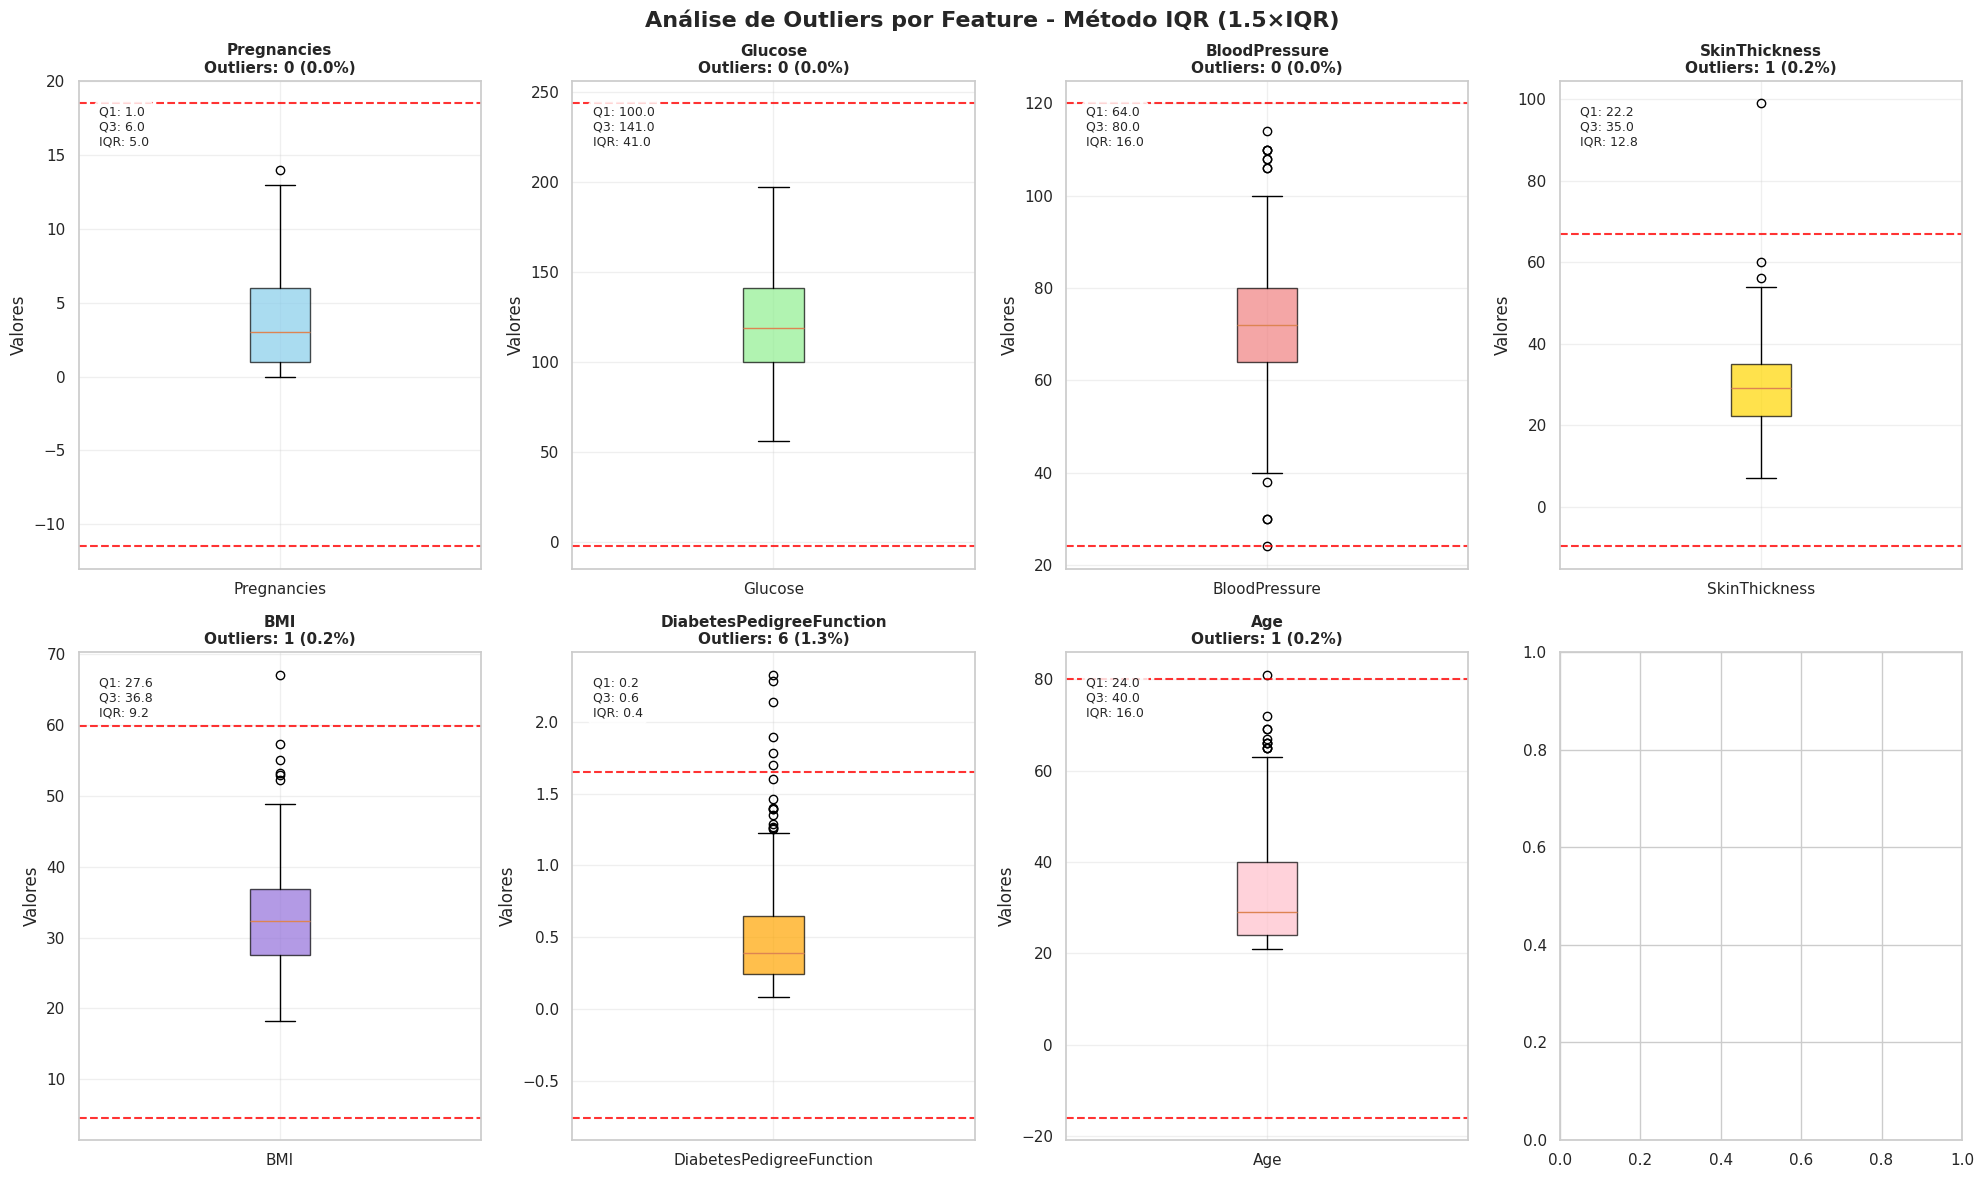

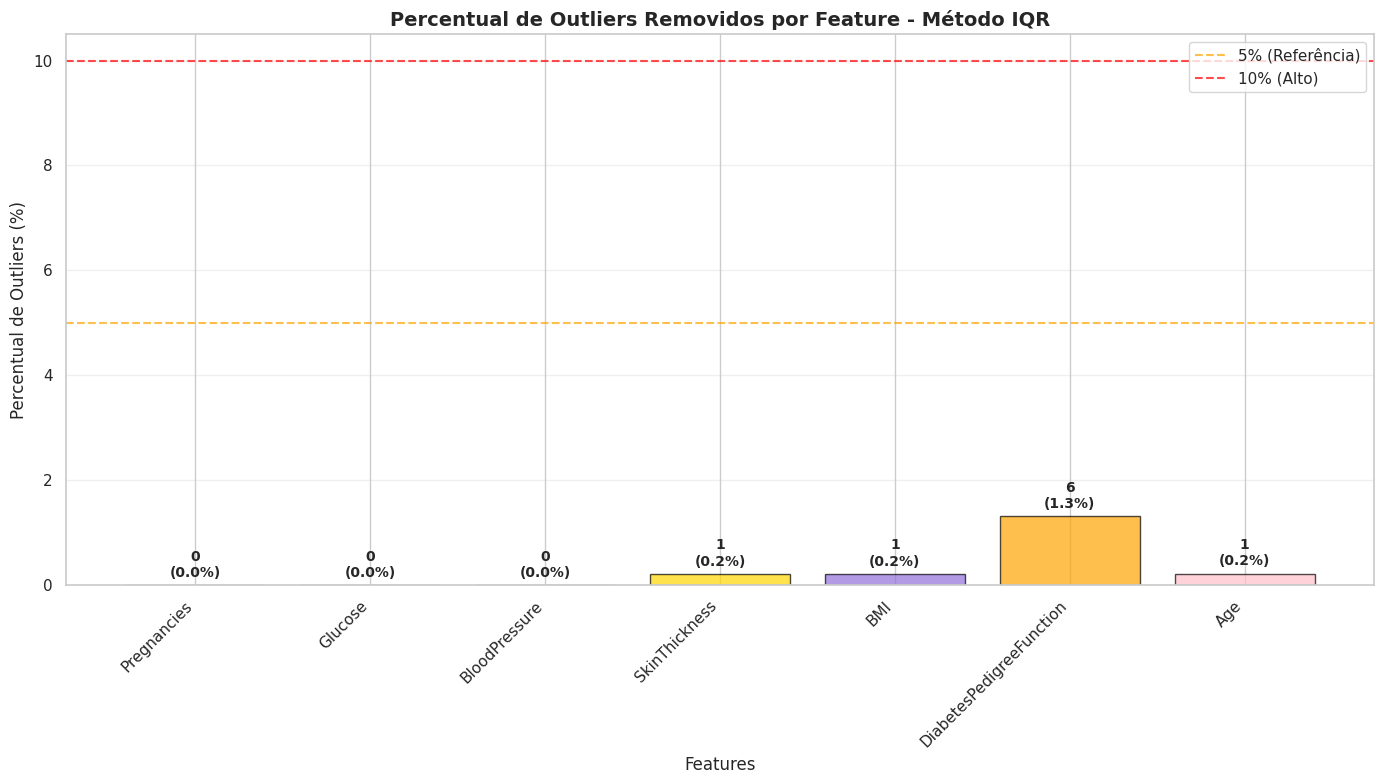

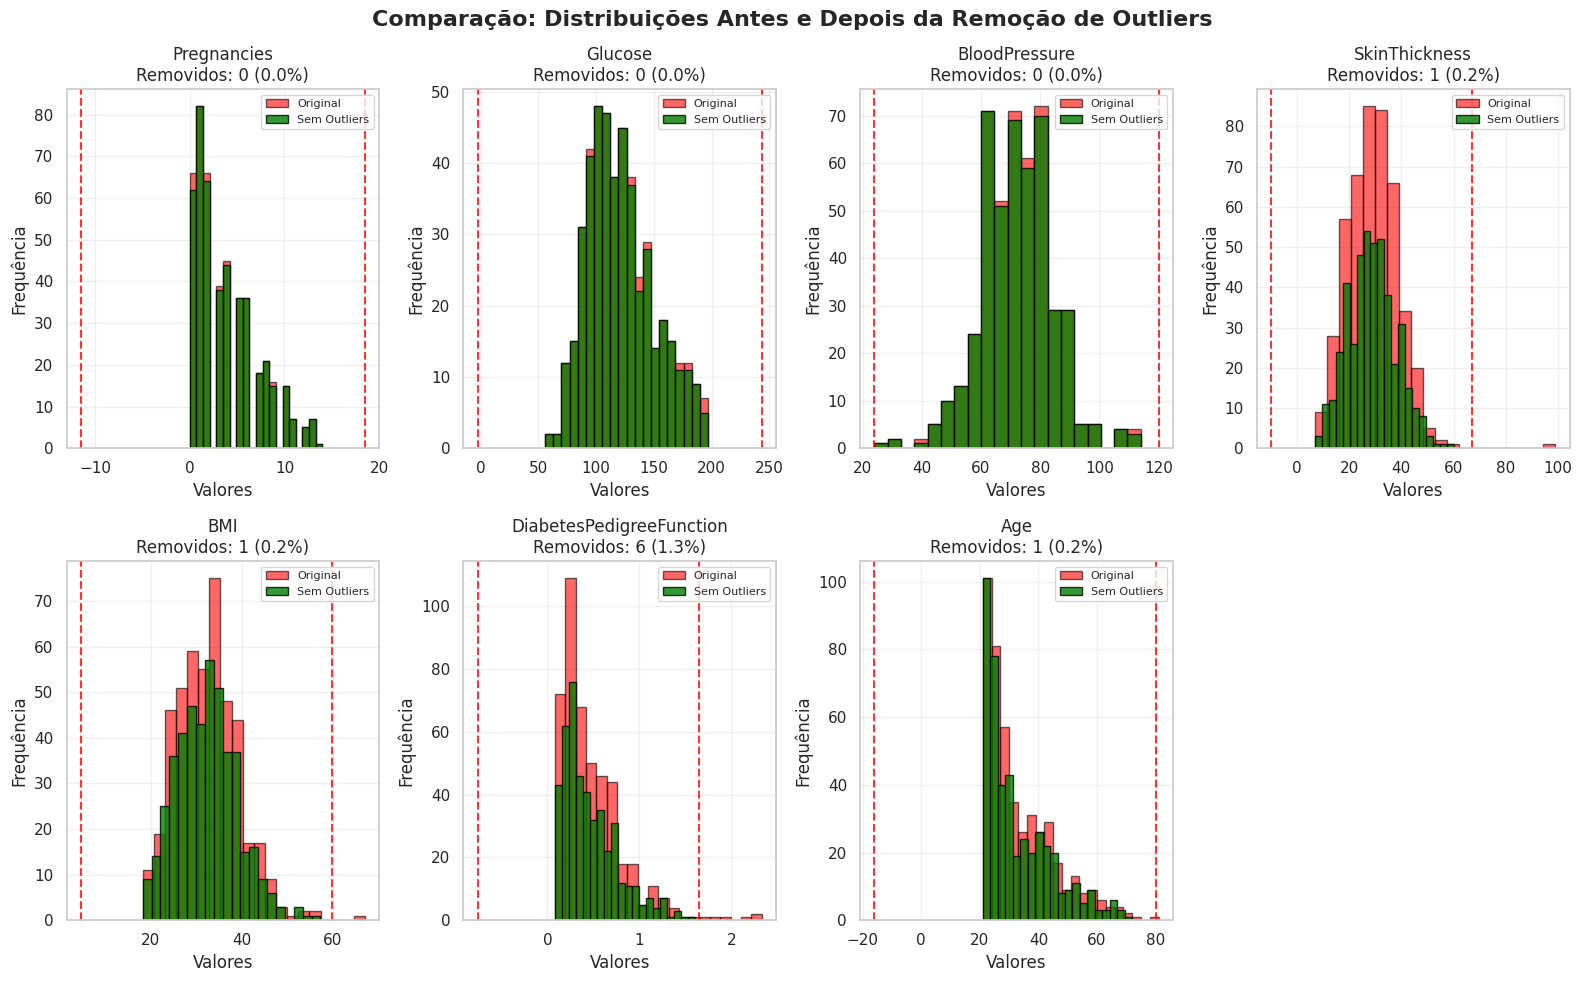


📋 IMPACTO DETALHADO DA REMOÇÃO DE OUTLIERS:
Feature                   Min Orig  Max Orig  Min Limpo  Max Limpo  Abaixo  Acima  Total 
Pregnancies               0.0       14.0      0.0        14.0       0       0      0     
Glucose                   56.0      197.0     56.0       197.0      0       0      0     
BloodPressure             24.0      114.0     24.0       114.0      0       0      0     
SkinThickness             7.0       99.0      7.0        60.0       0       1      1     
BMI                       18.2      67.1      18.2       57.3       0       1      1     
DiabetesPedigreeFunction  0.1       2.3       0.1        1.6        0       6      6     
Age                       21.0      81.0      21.0       72.0       0       1      1     

🎯 IMPACTO NO BALANCEAMENTO DE CLASSES:
Antes da limpeza:
  Classe 0: 300 (65.2%)
  Classe 1: 160 (34.8%)
Após a limpeza:
  Classe 0: 296 (65.6%)
  Classe 1: 155 (34.4%)
✅ Balanceamento original preservado!

✅ Análise de outliers concl

In [6]:
# ===== FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO =====

print("\n" + "="*70)
print("📊 FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO DETALHADA")
print("="*70)

# Função para remover outliers com informações detalhadas
def remove_outliers_iqr_detailed(data, columns):
      """
      Remove outliers usando o método IQR com informações detalhadas por feature
      """
      clean_data = data.copy()
      outlier_info = {}
      
      for column in columns:
            Q1 = clean_data[column].quantile(0.25)
            Q3 = clean_data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2.5 * IQR
            upper_bound = Q3 + 2.5 * IQR
            
            # Identificar outliers
            outliers_mask = (clean_data[column] < lower_bound) | (clean_data[column] > upper_bound)
            outliers_count = outliers_mask.sum()
            
            # Armazenar informações
            outlier_info[column] = {
                  'Q1': Q1,
                  'Q3': Q3,
                  'IQR': IQR,
                  'lower_bound': lower_bound,
                  'upper_bound': upper_bound,
                  'outliers_count': outliers_count,
                  'outliers_percentage': (outliers_count / len(clean_data)) * 100,
                  'original_min': clean_data[column].min(),
                  'original_max': clean_data[column].max(),
                  'outliers_below': (clean_data[column] < lower_bound).sum(),
                  'outliers_above': (clean_data[column] > upper_bound).sum()
            }
            
            # Remover outliers
            clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]
      
      return clean_data, outlier_info

# Aplicar remoção de outliers com informações detalhadas
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X_train_clean_df = pd.DataFrame(X_train, columns=feature_columns)
y_train_clean = y_train.copy()

X_train_clean_df, outlier_details = remove_outliers_iqr_detailed(X_train_clean_df, feature_columns)
y_train_clean = y_train_clean[X_train_clean_df.index]

# Calcular total de outliers removidos
total_outliers = len(X_train) - len(X_train_clean_df)

print(f"\n📈 RESULTADO GERAL DA REMOÇÃO DE OUTLIERS:")
print(f"Amostras originais: {len(X_train)}")
print(f"Amostras após limpeza: {len(X_train_clean_df)}")
print(f"Total de outliers removidos: {total_outliers}")
print(f"Percentual removido: {(total_outliers / len(X_train)) * 100:.1f}%")

# Exibir detalhes por feature
print(f"\n📊 DETALHES POR FEATURE:")
print("-" * 110)
print(f"{'Feature':<25} {'Q1':<8} {'Q3':<8} {'IQR':<8} {'Lower':<8} {'Upper':<8} {'Outliers':<9} {'%':<6}")
print("-" * 110)

for feature, info in outlier_details.items():
      print(f"{feature:<25} {info['Q1']:<8.2f} {info['Q3']:<8.2f} {info['IQR']:<8.2f} "
              f"{info['lower_bound']:<8.2f} {info['upper_bound']:<8.2f} {info['outliers_count']:<9} "
              f"{info['outliers_percentage']:<6.1f}")

# ===== VISUALIZAÇÃO DOS OUTLIERS =====

# Criar figura com subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Análise de Outliers por Feature - Método IQR (1.5×IQR)', fontsize=16, fontweight='bold')

# Cores para os gráficos
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'mediumpurple', 'orange', 'pink', 'lightgray']

for idx, (feature, info) in enumerate(outlier_details.items()):
      row = idx // 4
      col = idx % 4
      
      # Dados originais
      original_data = pd.DataFrame(X_train, columns=feature_columns)[feature]
      
      # Criar boxplot
      box_data = [original_data]
      bp = axes[row, col].boxplot(box_data, patch_artist=True, tick_labels=[feature])
      bp['boxes'][0].set_facecolor(colors[idx])
      bp['boxes'][0].set_alpha(0.7)
      
      # Adicionar linhas de referência IQR
      axes[row, col].axhline(y=info['lower_bound'], color='red', linestyle='--', 
                                      alpha=0.8, label=f'Lower: {info["lower_bound"]:.1f}')
      axes[row, col].axhline(y=info['upper_bound'], color='red', linestyle='--', 
                                      alpha=0.8, label=f'Upper: {info["upper_bound"]:.1f}')
      
      # Configurar título e labels
      axes[row, col].set_title(f'{feature}\nOutliers: {info["outliers_count"]} ({info["outliers_percentage"]:.1f}%)', 
                                          fontsize=11, fontweight='bold')
      axes[row, col].set_ylabel('Valores')
      axes[row, col].grid(True, alpha=0.3)
      
      # Adicionar texto com estatísticas
      stats_text = f"Q1: {info['Q1']:.1f}\nQ3: {info['Q3']:.1f}\nIQR: {info['IQR']:.1f}"
      axes[row, col].text(0.05, 0.95, stats_text, transform=axes[row, col].transAxes, 
                                 verticalalignment='top', fontsize=9, 
                                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# ===== GRÁFICO DE BARRAS COM PERCENTUAL DE OUTLIERS =====

plt.figure(figsize=(14, 8))

features = list(outlier_details.keys())
outlier_percentages = [outlier_details[feature]['outliers_percentage'] for feature in features]
outlier_counts = [outlier_details[feature]['outliers_count'] for feature in features]

# Criar gráfico de barras
bars = plt.bar(features, outlier_percentages, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

# Adicionar valores nas barras
for i, (bar, count, percentage) in enumerate(zip(bars, outlier_counts, outlier_percentages)):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')

plt.title('Percentual de Outliers Removidos por Feature - Método IQR', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentual de Outliers (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar linha de referência
plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='5% (Referência)')
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10% (Alto)')

plt.legend()
plt.tight_layout()
plt.show()

# ===== COMPARAÇÃO ANTES E DEPOIS =====

plt.figure(figsize=(16, 10))

for idx, feature in enumerate(feature_columns):
      plt.subplot(2, 4, idx + 1)
      
      # Dados originais e limpos
      original_data = pd.DataFrame(X_train, columns=feature_columns)[feature]
      clean_data = X_train_clean_df[feature]
      
      # Histogramas sobrepostos
      plt.hist(original_data, bins=20, alpha=0.6, label='Original', color='red', edgecolor='black')
      plt.hist(clean_data, bins=20, alpha=0.8, label='Sem Outliers', color='green', edgecolor='black')
      
      # Adicionar estatísticas
      info = outlier_details[feature]
      plt.axvline(info['lower_bound'], color='red', linestyle='--', alpha=0.8)
      plt.axvline(info['upper_bound'], color='red', linestyle='--', alpha=0.8)
      
      plt.title(f'{feature}\nRemovidos: {info["outliers_count"]} ({info["outliers_percentage"]:.1f}%)')
      plt.xlabel('Valores')
      plt.ylabel('Frequência')
      plt.legend(fontsize=8)
      plt.grid(True, alpha=0.3)

plt.suptitle('Comparação: Distribuições Antes e Depois da Remoção de Outliers', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ===== IMPACTO NUMÉRICO DETALHADO =====

print(f"\n📋 IMPACTO DETALHADO DA REMOÇÃO DE OUTLIERS:")
print("=" * 115)
print(f"{'Feature':<25} {'Min Orig':<9} {'Max Orig':<9} {'Min Limpo':<10} {'Max Limpo':<10} {'Abaixo':<7} {'Acima':<6} {'Total':<6}")
print("=" * 115)

for feature, info in outlier_details.items():
      clean_data = X_train_clean_df[feature]
      print(f"{feature:<25} {info['original_min']:<9.1f} {info['original_max']:<9.1f} "
              f"{clean_data.min():<10.1f} {clean_data.max():<10.1f} "
              f"{info['outliers_below']:<7} {info['outliers_above']:<6} {info['outliers_count']:<6}")

print("=" * 115)

# ===== DISTRIBUIÇÃO DE CLASSES APÓS LIMPEZA =====

print(f"\n🎯 IMPACTO NO BALANCEAMENTO DE CLASSES:")
print(f"Antes da limpeza:")
print(f"  Classe 0: {(y_train == 0).sum()} ({(y_train == 0).mean():.1%})")
print(f"  Classe 1: {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")

print(f"Após a limpeza:")
print(f"  Classe 0: {(y_train_clean == 0).sum()} ({(y_train_clean == 0).mean():.1%})")
print(f"  Classe 1: {(y_train_clean == 1).sum()} ({(y_train_clean == 1).mean():.1%})")

# Verificar se o balanceamento foi mantido
diff_original = abs((y_train == 0).mean() - (y_train_clean == 0).mean())
if diff_original < 0.02:
      print("✅ Balanceamento original preservado!")
else:
      print("⚠️ Pequena alteração no balanceamento (normal)")

print(f"\n✅ Análise de outliers concluída!")
print(f"💾 {total_outliers} outliers removidos usando método IQR (Q1-1.5×IQR, Q3+1.5×IQR)")
print(f"🎯 Dados limpos prontos para a próxima etapa (SMOTE)")

In [7]:
# ===== FASE 3.4: NORMALIZAÇÃO DOS DADOS =====

print("\n" + "="*70)
print("📊 FASE 3.4: NORMALIZAÇÃO DOS DADOS")
print("="*70)

# Criar StandardScaler
scaler = StandardScaler()

print(f"\n🔄 Normalizando dados...")
print(f"Dados de treino limpos: {X_train_clean_df.shape}")

# Normalizar dados de treino (ajustar o scaler)
X_train_scaled = scaler.fit_transform(X_train_clean_df)

# Normalizar dados de validação e teste (aplicar transformação)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ NORMALIZAÇÃO CONCLUÍDA:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled: {X_val_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

# Verificar normalização
print(f"\nVerificação da normalização (deve ser ~0 e ~1):")
print(f"Média do treino: {X_train_scaled.mean():.6f}")
print(f"Desvio do treino: {X_train_scaled.std():.6f}")

print(f"\n✅ Dados normalizados e prontos para SMOTE!")


📊 FASE 3.4: NORMALIZAÇÃO DOS DADOS

🔄 Normalizando dados...
Dados de treino limpos: (451, 7)

✅ NORMALIZAÇÃO CONCLUÍDA:
X_train_scaled: (451, 7)
X_val_scaled: (154, 7)
X_test_scaled: (154, 7)

Verificação da normalização (deve ser ~0 e ~1):
Média do treino: -0.000000
Desvio do treino: 1.000000

✅ Dados normalizados e prontos para SMOTE!


In [8]:
# ===== FASE 3.3: BALANCEAMENTO COM SMOTE CORRIGIDO =====

print("\n" + "="*70)
print("🎯 FASE 3.3: BALANCEAMENTO COM SMOTE")
print("="*70)

# Exibir estado antes do SMOTE
print(f"\n📈 ESTADO ANTES DO SMOTE:")
print(f"Total de amostras: {len(X_train_clean_df)}")
print(f"Classe 0 (não-diabetes): {(y_train_clean == 0).sum()} ({(y_train_clean == 0).mean():.1%})")
print(f"Classe 1 (diabetes): {(y_train_clean == 1).sum()} ({(y_train_clean == 1).mean():.1%})")
print(f"Ratio de desbalanceamento: {(y_train_clean == 0).sum() / (y_train_clean == 1).sum():.1f}:1")

# Inicializar SMOTE
print(f"\n🤖 Inicializando SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)

print(f"Parâmetros do SMOTE:")
print(f"- k_neighbors: {smote.k_neighbors} (número de vizinhos para geração)")
print(f"- random_state: {smote.random_state} (para reprodutibilidade)")
print(f"- sampling_strategy: 'auto' (equilibra automaticamente)")

# Aplicar SMOTE nos dados normalizados
print(f"\n🔄 Aplicando SMOTE nos dados normalizados...")
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_clean)

# Exibir resultados
print(f"\n✅ RESULTADO DO SMOTE:")
print(f"Amostras antes: {len(X_train_scaled)}")
print(f"Amostras depois: {len(X_train_balanced)}")
print(f"Amostras sintéticas criadas: {len(X_train_balanced) - len(X_train_scaled)}")

print(f"\n📊 DISTRIBUIÇÃO FINAL:")
print("-"*50)
print(f"{'Classe':<15} {'Antes':<10} {'Depois':<10} {'Adicionadas':<12}")
print("-"*50)

# Classe 0 (não-diabetes)
antes_0 = (y_train_clean == 0).sum()
depois_0 = (y_train_balanced == 0).sum()
adicionadas_0 = depois_0 - antes_0
print(f"Não-diabetes   {antes_0:<10} {depois_0:<10} {adicionadas_0:<12}")

# Classe 1 (diabetes)
antes_1 = (y_train_clean == 1).sum()
depois_1 = (y_train_balanced == 1).sum()
adicionadas_1 = depois_1 - antes_1
print(f"Diabetes       {antes_1:<10} {depois_1:<10} {adicionadas_1:<12}")

print("-"*50)
print(f"Total          {len(y_train_clean):<10} {len(y_train_balanced):<10} {len(y_train_balanced) - len(y_train_clean):<12}")

# Verificar balanceamento final
ratio_final = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()
print(f"\n🎯 VERIFICAÇÃO DO BALANCEAMENTO:")
print(f"Proporção final - Classe 0: {(y_train_balanced == 0).mean():.1%}")
print(f"Proporção final - Classe 1: {(y_train_balanced == 1).mean():.1%}")
print(f"Novo ratio: {ratio_final:.1f}:1")

if abs((y_train_balanced == 0).mean() - 0.5) < 0.01:
    print("✅ Balanceamento perfeito alcançado (50:50)!")
else:
    print("⚠️ Balanceamento quase perfeito.")

print(f"\n✅ SMOTE aplicado com sucesso! Dados prontos para treinamento.")


🎯 FASE 3.3: BALANCEAMENTO COM SMOTE

📈 ESTADO ANTES DO SMOTE:
Total de amostras: 451
Classe 0 (não-diabetes): 296 (65.6%)
Classe 1 (diabetes): 155 (34.4%)
Ratio de desbalanceamento: 1.9:1

🤖 Inicializando SMOTE...
Parâmetros do SMOTE:
- k_neighbors: 5 (número de vizinhos para geração)
- random_state: 42 (para reprodutibilidade)
- sampling_strategy: 'auto' (equilibra automaticamente)

🔄 Aplicando SMOTE nos dados normalizados...

✅ RESULTADO DO SMOTE:
Amostras antes: 451
Amostras depois: 592
Amostras sintéticas criadas: 141

📊 DISTRIBUIÇÃO FINAL:
--------------------------------------------------
Classe          Antes      Depois     Adicionadas 
--------------------------------------------------
Não-diabetes   296        296        0           
Diabetes       155        296        141         
--------------------------------------------------
Total          451        592        141         

🎯 VERIFICAÇÃO DO BALANCEAMENTO:
Proporção final - Classe 0: 50.0%
Proporção final - Classe 1:

In [9]:
# ===== FASE 3.3: COMPARAÇÃO DE MÉTODOS DE BALANCEAMENTO =====

print("\n" + "="*80)
print("🎯 FASE 3.3: COMPARAÇÃO DE MÉTODOS DE BALANCEAMENTO")
print("="*80)

from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

print(f"\n📋 MÉTODOS DE BALANCEAMENTO A SEREM TESTADOS:")
print("1. SMOTE (Synthetic Minority Oversampling Technique)")
print("2. Upsampling/Oversampling (Random Oversampling)")
print("3. Reponderação (Class Weight)")

print(f"\n📊 ESTADO ATUAL DOS DADOS (APÓS REMOÇÃO DE OUTLIERS):")
print(f"Total de amostras: {len(X_train_clean_df)}")
print(f"Classe 0 (não-diabetes): {(y_train_clean == 0).sum()} ({(y_train_clean == 0).mean():.1%})")
print(f"Classe 1 (diabetes): {(y_train_clean == 1).sum()} ({(y_train_clean == 1).mean():.1%})")
print(f"Ratio de desbalanceamento: {(y_train_clean == 0).sum() / (y_train_clean == 1).sum():.1f}:1")


🎯 FASE 3.3: COMPARAÇÃO DE MÉTODOS DE BALANCEAMENTO

📋 MÉTODOS DE BALANCEAMENTO A SEREM TESTADOS:
1. SMOTE (Synthetic Minority Oversampling Technique)
2. Upsampling/Oversampling (Random Oversampling)
3. Reponderação (Class Weight)

📊 ESTADO ATUAL DOS DADOS (APÓS REMOÇÃO DE OUTLIERS):
Total de amostras: 453
Classe 0 (não-diabetes): 296 (65.3%)
Classe 1 (diabetes): 157 (34.7%)
Ratio de desbalanceamento: 1.9:1


In [9]:
# ===== MÉTODO 2: UPSAMPLING/OVERSAMPLING CORRIGIDO =====

print("\n" + "="*70)
print("📊 MÉTODO 2: UPSAMPLING/OVERSAMPLING (RANDOM OVERSAMPLING)")
print("="*70)

from sklearn.utils import resample

# Separar classes dos dados limpos e normalizados
X_majority = X_train_scaled[y_train_clean == 0]
X_minority = X_train_scaled[y_train_clean == 1]
y_majority = y_train_clean[y_train_clean == 0]
y_minority = y_train_clean[y_train_clean == 1]

print(f"\n📈 ANTES DO UPSAMPLING:")
print(f"Classe majoritária (0): {len(X_majority)} amostras")
print(f"Classe minoritária (1): {len(X_minority)} amostras")

# Fazer upsampling da classe minoritária
X_minority_upsampled = resample(X_minority,
                               replace=True,  # Permitir duplicatas
                               n_samples=len(X_majority),  # Igualar ao tamanho da classe majoritária
                               random_state=42)

y_minority_upsampled = resample(y_minority,
                               replace=True,
                               n_samples=len(X_majority),
                               random_state=42)

# Combinar classe majoritária com classe minoritária upsampled
X_train_upsampled = np.vstack([X_majority, X_minority_upsampled])
y_train_upsampled = np.concatenate([y_majority, y_minority_upsampled])

# Embaralhar os dados
from sklearn.utils import shuffle
X_train_upsampled, y_train_upsampled = shuffle(X_train_upsampled, y_train_upsampled, random_state=42)

print(f"\n✅ UPSAMPLING - RESULTADOS:")
print(f"Amostras antes: {len(X_train_scaled)}")
print(f"Amostras depois: {len(X_train_upsampled)}")
print(f"Classe 0: {(y_train_upsampled == 0).sum()} ({(y_train_upsampled == 0).mean():.1%})")
print(f"Classe 1: {(y_train_upsampled == 1).sum()} ({(y_train_upsampled == 1).mean():.1%})")
print(f"Amostras duplicadas: {len(X_train_upsampled) - len(X_train_scaled)}")

# Verificar balanceamento
ratio_upsampled = (y_train_upsampled == 0).sum() / (y_train_upsampled == 1).sum()
print(f"Novo ratio: {ratio_upsampled:.1f}:1")

if abs((y_train_upsampled == 0).mean() - 0.5) < 0.01:
    print("✅ Balanceamento perfeito alcançado (50:50)!")
else:
    print("⚠️ Balanceamento quase perfeito.")


📊 MÉTODO 2: UPSAMPLING/OVERSAMPLING (RANDOM OVERSAMPLING)

📈 ANTES DO UPSAMPLING:
Classe majoritária (0): 296 amostras
Classe minoritária (1): 155 amostras

✅ UPSAMPLING - RESULTADOS:
Amostras antes: 451
Amostras depois: 592
Classe 0: 296 (50.0%)
Classe 1: 296 (50.0%)
Amostras duplicadas: 141
Novo ratio: 1.0:1
✅ Balanceamento perfeito alcançado (50:50)!


In [10]:
# ===== MÉTODO 3: REPONDERAÇÃO (CLASS WEIGHT) CORRIGIDO =====

print("\n" + "="*70)
print("📊 MÉTODO 3: REPONDERAÇÃO (CLASS WEIGHT)")
print("="*70)

from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos das classes automaticamente
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train_clean), 
                                   y=y_train_clean)

# Criar dicionário de pesos
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n⚖️ PESOS CALCULADOS AUTOMATICAMENTE:")
print(f"Classe 0 (não-diabetes): {class_weight_dict[0]:.3f}")
print(f"Classe 1 (diabetes): {class_weight_dict[1]:.3f}")
print(f"Ratio dos pesos (Classe 1 / Classe 0): {class_weight_dict[1] / class_weight_dict[0]:.2f}")

# Para reponderação, usamos os dados originais limpos e normalizados
X_train_weighted = X_train_scaled.copy()
y_train_weighted = y_train_clean.copy()

print(f"\n✅ REPONDERAÇÃO - CONFIGURAÇÃO:")
print(f"Amostras de treino: {len(X_train_weighted)}")
print(f"Classe 0: {(y_train_weighted == 0).sum()} ({(y_train_weighted == 0).mean():.1%})")
print(f"Classe 1: {(y_train_weighted == 1).sum()} ({(y_train_weighted == 1).mean():.1%})")
print(f"💡 Nota: O balanceamento é feito internamente pelos algoritmos que suportam class_weight")

# Verificar quais modelos suportam class_weight
models_with_class_weight = [
    'Random Forest', 'XGBoost', 'LightGBM', 
    'Decision Tree', 'SVM', 'Logistic Regression'
]

models_without_class_weight = ['Gradient Boosting', 'AdaBoost', 'kNN', 'Naive Bayes']

print(f"\n📋 COMPATIBILIDADE COM CLASS_WEIGHT:")
print(f"✅ Suportam reponderação: {', '.join(models_with_class_weight)}")
print(f"❌ Não suportam reponderação: {', '.join(models_without_class_weight)}")


📊 MÉTODO 3: REPONDERAÇÃO (CLASS WEIGHT)

⚖️ PESOS CALCULADOS AUTOMATICAMENTE:
Classe 0 (não-diabetes): 0.762
Classe 1 (diabetes): 1.455
Ratio dos pesos (Classe 1 / Classe 0): 1.91

✅ REPONDERAÇÃO - CONFIGURAÇÃO:
Amostras de treino: 451
Classe 0: 296 (65.6%)
Classe 1: 155 (34.4%)
💡 Nota: O balanceamento é feito internamente pelos algoritmos que suportam class_weight

📋 COMPATIBILIDADE COM CLASS_WEIGHT:
✅ Suportam reponderação: Random Forest, XGBoost, LightGBM, Decision Tree, SVM, Logistic Regression
❌ Não suportam reponderação: Gradient Boosting, AdaBoost, kNN, Naive Bayes



📊 VISUALIZAÇÃO COMPARATIVA DOS MÉTODOS DE BALANCEAMENTO


IndexError: index 7 is out of bounds for axis 1 with size 7

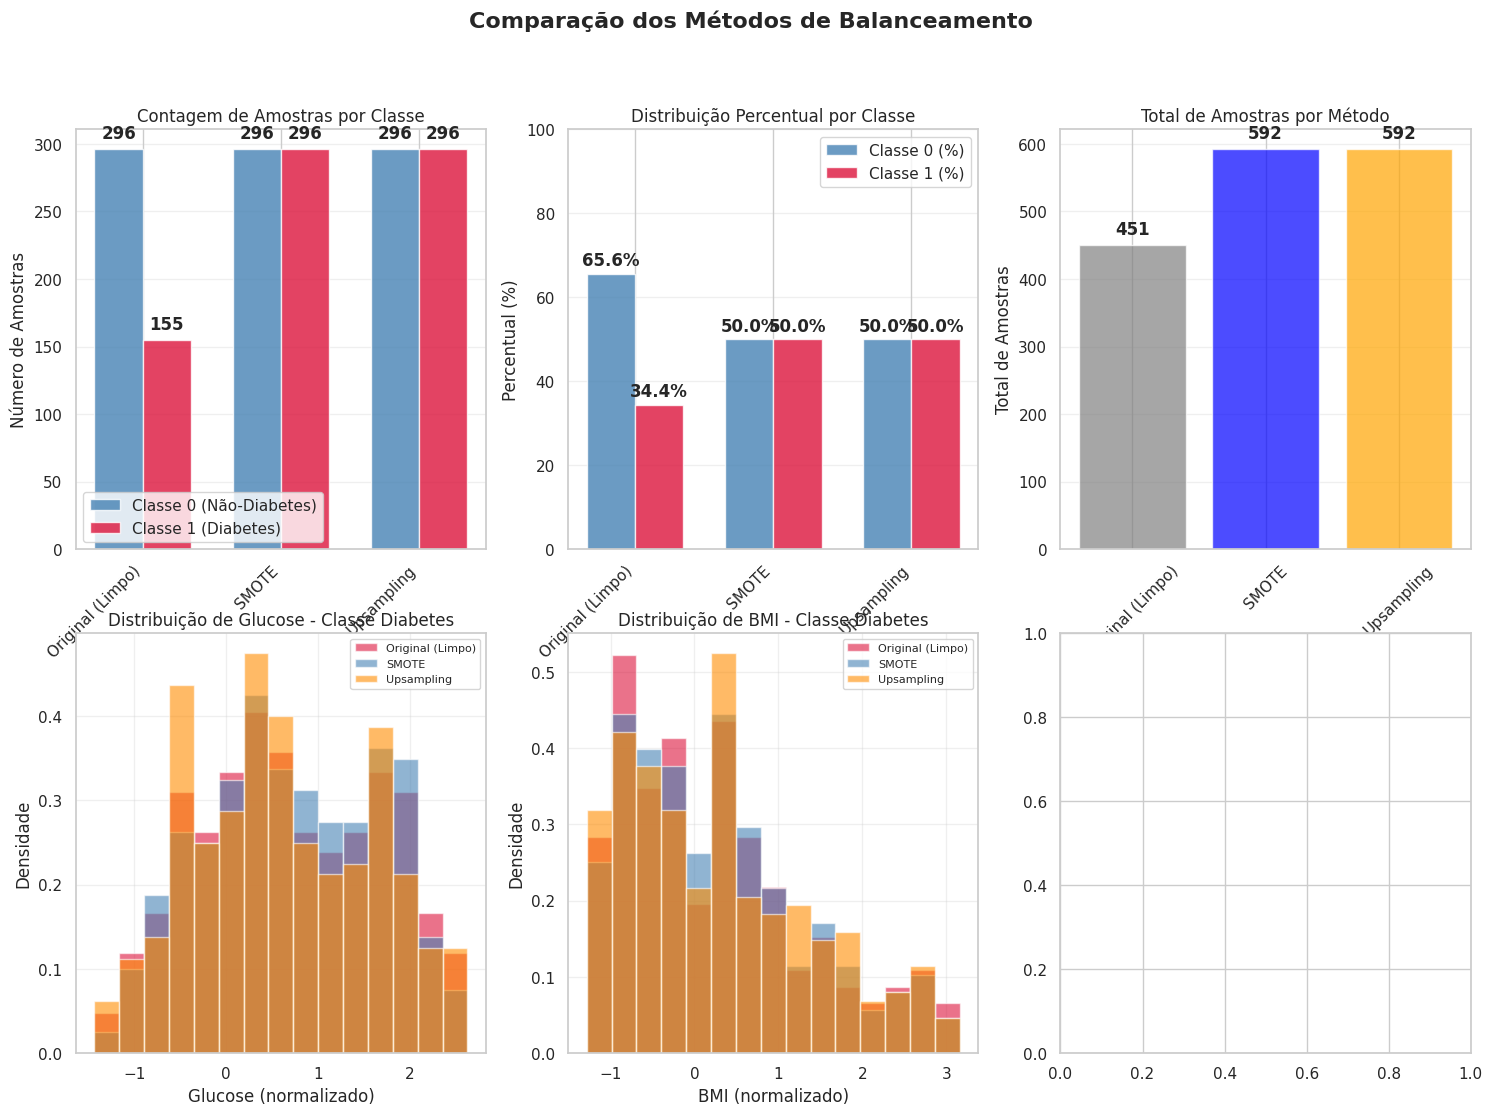

In [11]:
# ===== VISUALIZAÇÃO COMPARATIVA DOS MÉTODOS DE BALANCEAMENTO CORRIGIDA =====

print("\n" + "="*70)
print("📊 VISUALIZAÇÃO COMPARATIVA DOS MÉTODOS DE BALANCEAMENTO")
print("="*70)

# Criar figura comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparação dos Métodos de Balanceamento', fontsize=16, fontweight='bold')

# Dados para comparação (CORRIGIDOS)
methods_data = {
    'Original (Limpo)': (X_train_scaled, y_train_clean),
    'SMOTE': (X_train_balanced, y_train_balanced),
    'Upsampling': (X_train_upsampled, y_train_upsampled)
}

# Cores para cada método
colors = ['crimson', 'steelblue', 'darkorange']

# Gráfico 1: Comparação de contagens
ax1 = axes[0, 0]
method_names = list(methods_data.keys())
counts_0 = [(data[1] == 0).sum() for data in methods_data.values()]
counts_1 = [(data[1] == 1).sum() for data in methods_data.values()]

x = np.arange(len(method_names))
width = 0.35

bars1 = ax1.bar(x - width/2, counts_0, width, label='Classe 0 (Não-Diabetes)', 
                color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, counts_1, width, label='Classe 1 (Diabetes)', 
                color='crimson', alpha=0.8)

# Adicionar valores nas barras
for i, (bar1, bar2, c0, c1) in enumerate(zip(bars1, bars2, counts_0, counts_1)):
    ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 5, 
             str(c0), ha='center', va='bottom', fontweight='bold')
    ax1.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 5, 
             str(c1), ha='center', va='bottom', fontweight='bold')

ax1.set_xlabel('Métodos de Balanceamento')
ax1.set_ylabel('Número de Amostras')
ax1.set_title('Contagem de Amostras por Classe')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Distribuição percentual
ax2 = axes[0, 1]
percentages_0 = [(data[1] == 0).mean() * 100 for data in methods_data.values()]
percentages_1 = [(data[1] == 1).mean() * 100 for data in methods_data.values()]

bars1_perc = ax2.bar(x - width/2, percentages_0, width, label='Classe 0 (%)', 
                     color='steelblue', alpha=0.8)
bars2_perc = ax2.bar(x + width/2, percentages_1, width, label='Classe 1 (%)', 
                     color='crimson', alpha=0.8)

# Adicionar valores nas barras
for i, (bar1, bar2, p0, p1) in enumerate(zip(bars1_perc, bars2_perc, percentages_0, percentages_1)):
    ax2.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 1, 
             f'{p0:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax2.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 1, 
             f'{p1:.1f}%', ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Métodos de Balanceamento')
ax2.set_ylabel('Percentual (%)')
ax2.set_title('Distribuição Percentual por Classe')
ax2.set_xticks(x)
ax2.set_xticklabels(method_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)

# Gráfico 3: Total de amostras
ax3 = axes[0, 2]
total_samples = [len(data[1]) for data in methods_data.values()]
bars_total = ax3.bar(method_names, total_samples, color=['gray', 'blue', 'orange'], alpha=0.7)

for bar, total in zip(bars_total, total_samples):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(total), ha='center', va='bottom', fontweight='bold')

ax3.set_xlabel('Métodos de Balanceamento')
ax3.set_ylabel('Total de Amostras')
ax3.set_title('Total de Amostras por Método')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Gráficos 4-6: Distribuição de features importantes
important_features_idx = [1, 5, 7]  # Índices para Glucose, BMI, Age
important_features_names = ['Glucose', 'BMI', 'Age']

for idx, (feature_idx, feature_name) in enumerate(zip(important_features_idx, important_features_names)):
    ax = axes[1, idx]
    
    for i, (method_name, (X_data, y_data)) in enumerate(methods_data.items()):
        # Dados da classe diabetes para esta feature
        diabetes_mask = y_data == 1
        diabetes_data = X_data[diabetes_mask][:, feature_idx]
        
        ax.hist(diabetes_data, bins=15, alpha=0.6, label=f'{method_name}', 
               color=colors[i], density=True)
    
    ax.set_title(f'Distribuição de {feature_name} - Classe Diabetes')
    ax.set_xlabel(f'{feature_name} (normalizado)')
    ax.set_ylabel('Densidade')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela resumo dos métodos
print(f"\n📋 RESUMO COMPARATIVO DOS MÉTODOS:")
print("="*80)
print(f"{'Método':<20} {'Total':<8} {'Classe 0':<10} {'Classe 1':<10} {'% Classe 0':<12} {'% Classe 1':<12}")
print("="*80)

for method_name, (X_data, y_data) in methods_data.items():
    total = len(y_data)
    count_0 = (y_data == 0).sum()
    count_1 = (y_data == 1).sum()
    perc_0 = (y_data == 0).mean() * 100
    perc_1 = (y_data == 1).mean() * 100
    
    print(f"{method_name:<20} {total:<8} {count_0:<10} {count_1:<10} {perc_0:<12.1f} {perc_1:<12.1f}")

print("="*80)

print(f"\n💡 CARACTERÍSTICAS DE CADA MÉTODO:")
print("1. SMOTE: Cria amostras sintéticas interpolando entre vizinhos")
print("2. Upsampling: Duplica amostras existentes da classe minoritária")
print("3. Reponderação: Ajusta pesos durante o treinamento (sem aumentar dados)")

In [63]:
# ===== CRIAR DIRETÓRIOS NECESSÁRIOS =====

import os

# Criar diretórios se não existirem
directories = ['modelos-smote', 'todos-modelos']

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"✅ Diretório '{directory}' criado!")
    else:
        print(f"📁 Diretório '{directory}' já existe.")

print("\n🎯 Diretórios verificados e prontos para uso!")

📁 Diretório 'modelos-smote' já existe.
📁 Diretório 'todos-modelos' já existe.

🎯 Diretórios verificados e prontos para uso!



📊 VISUALIZAÇÃO COMPARATIVA DE PERFORMANCE


/tmp/ipykernel_23304/3395612458.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(cv_data_by_method, labels=method_labels, patch_artist=True)


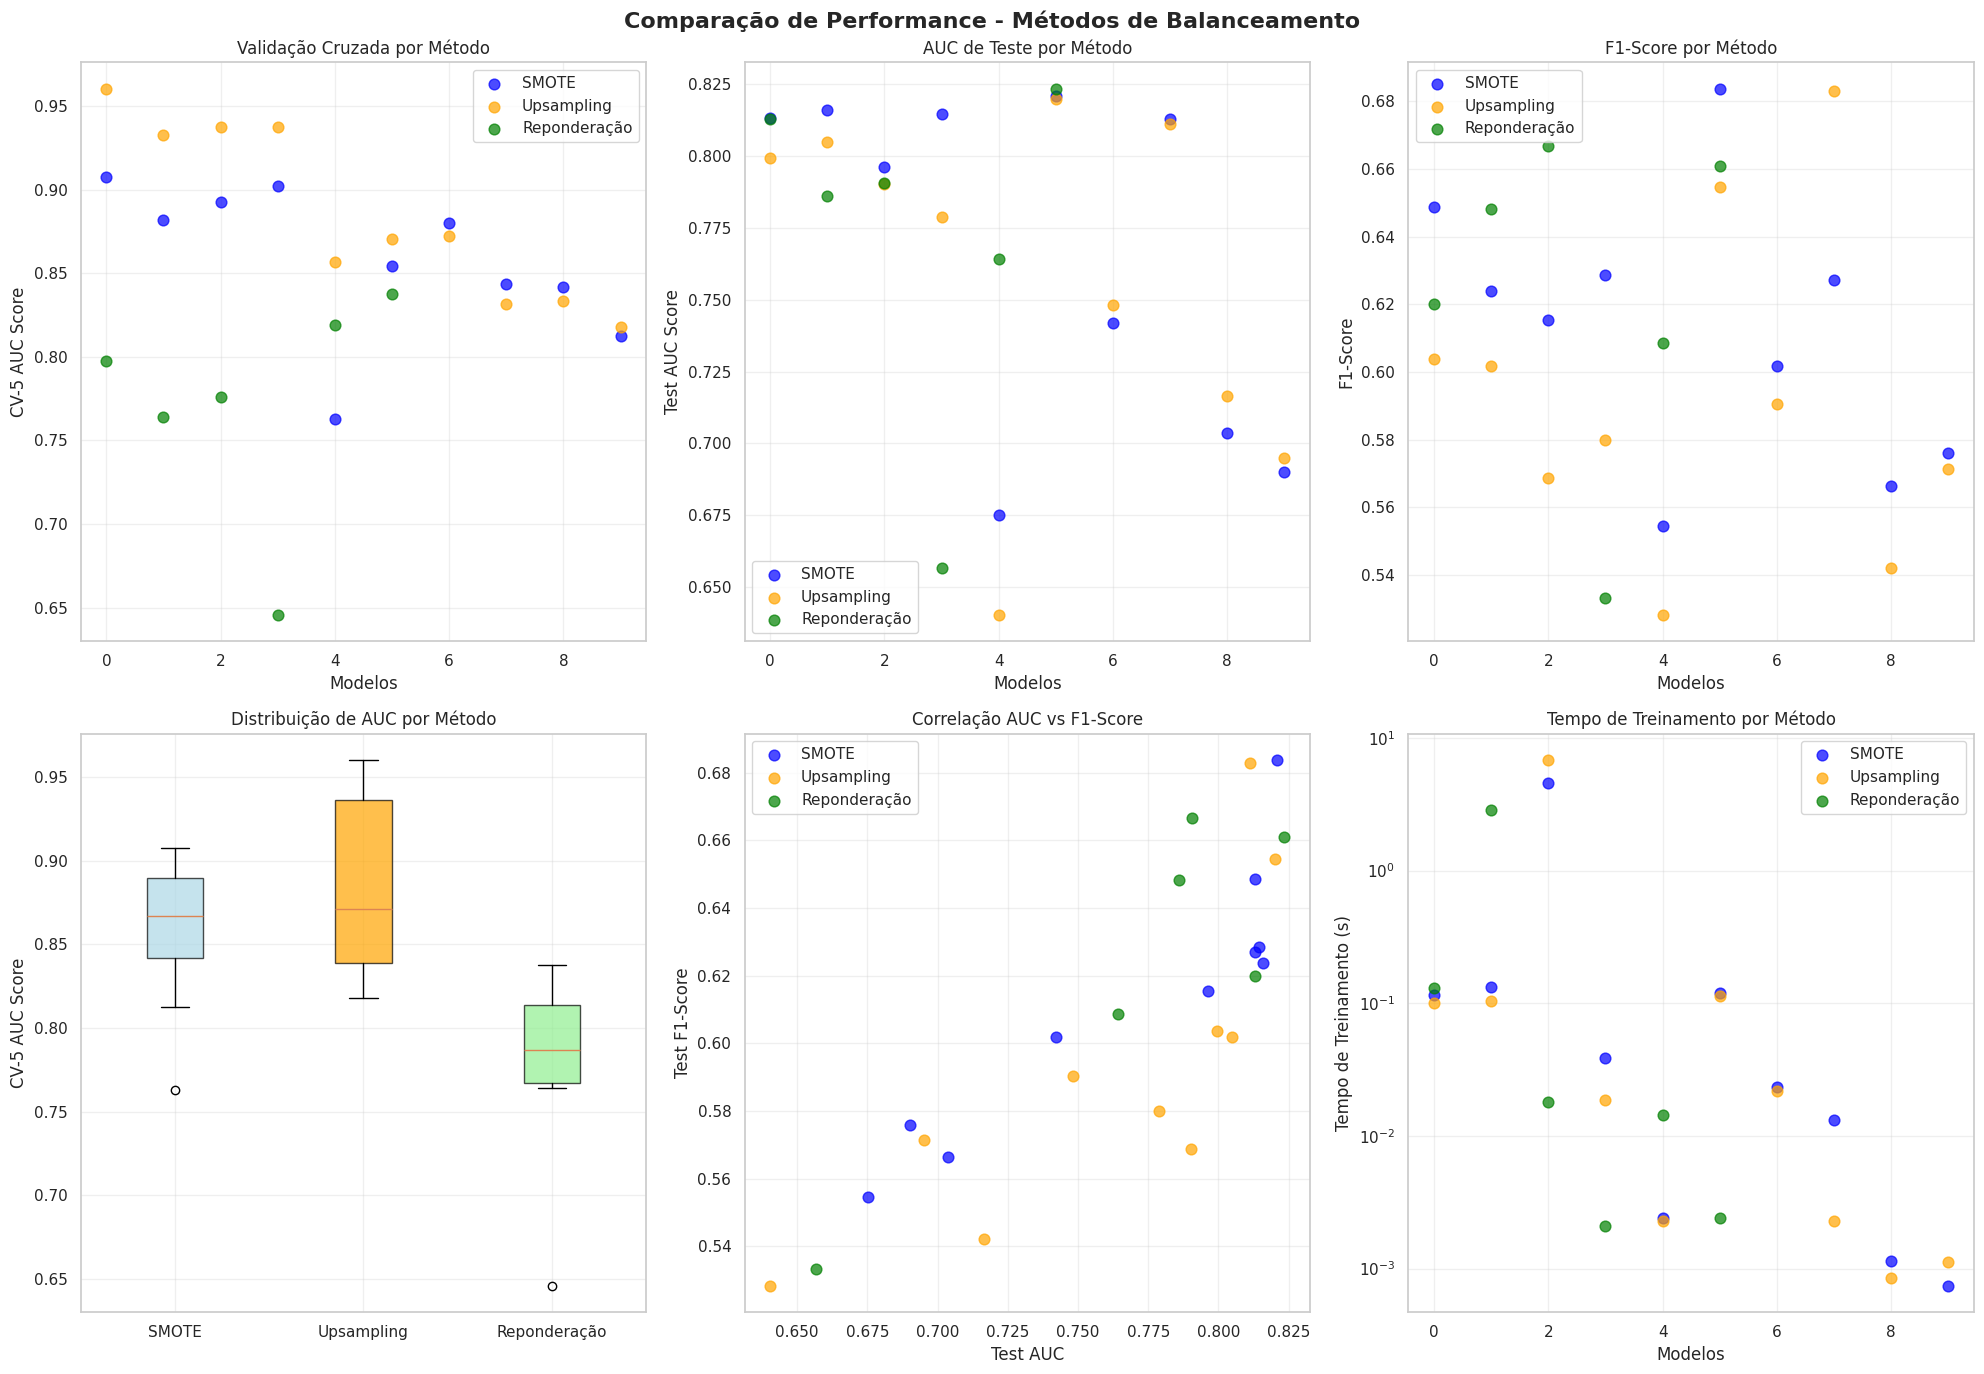

In [65]:
# ===== VISUALIZAÇÃO COMPARATIVA DE PERFORMANCE =====

print("\n" + "="*70)
print("📊 VISUALIZAÇÃO COMPARATIVA DE PERFORMANCE")
print("="*70)

# Configurar figura
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Comparação de Performance - Métodos de Balanceamento', fontsize=16, fontweight='bold')

# Cores para cada método
method_colors = {'SMOTE': 'blue', 'Upsampling': 'orange', 'Reponderação': 'green'}

# 1. AUC de Validação Cruzada por Método
ax1 = axes[0, 0]
for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
    method_data = results_comparison_df[results_comparison_df['Método'] == method_name]
    if len(method_data) > 0:
        ax1.scatter(range(len(method_data)), method_data['CV_Mean'], 
                   label=method_name, color=method_colors[method_name], s=60, alpha=0.7)

ax1.set_xlabel('Modelos')
ax1.set_ylabel('CV-5 AUC Score')
ax1.set_title('Validação Cruzada por Método')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. AUC de Teste por Método
ax2 = axes[0, 1]
for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
    method_data = results_comparison_df[results_comparison_df['Método'] == method_name]
    if len(method_data) > 0:
        ax2.scatter(range(len(method_data)), method_data['Test_AUC'], 
                   label=method_name, color=method_colors[method_name], s=60, alpha=0.7)

ax2.set_xlabel('Modelos')
ax2.set_ylabel('Test AUC Score')
ax2.set_title('AUC de Teste por Método')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. F1-Score por Método
ax3 = axes[0, 2]
for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
    method_data = results_comparison_df[results_comparison_df['Método'] == method_name]
    if len(method_data) > 0:
        ax3.scatter(range(len(method_data)), method_data['Test_F1'], 
                   label=method_name, color=method_colors[method_name], s=60, alpha=0.7)

ax3.set_xlabel('Modelos')
ax3.set_ylabel('F1-Score')
ax3.set_title('F1-Score por Método')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Boxplot - AUC por Método
ax4 = axes[1, 0]
cv_data_by_method = []
method_labels = []

for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
    method_data = results_comparison_df[results_comparison_df['Método'] == method_name]
    if len(method_data) > 0:
        cv_data_by_method.append(method_data['CV_Mean'].values)
        method_labels.append(method_name)

if cv_data_by_method:
    bp = ax4.boxplot(cv_data_by_method, labels=method_labels, patch_artist=True)
    colors = ['lightblue', 'orange', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax4.set_ylabel('CV-5 AUC Score')
ax4.set_title('Distribuição de AUC por Método')
ax4.grid(True, alpha=0.3)

# 5. Correlação AUC vs F1-Score
ax5 = axes[1, 1]
for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
    method_data = results_comparison_df[results_comparison_df['Método'] == method_name]
    if len(method_data) > 0:
        ax5.scatter(method_data['Test_AUC'], method_data['Test_F1'], 
                   label=method_name, color=method_colors[method_name], s=60, alpha=0.7)

ax5.set_xlabel('Test AUC')
ax5.set_ylabel('Test F1-Score')
ax5.set_title('Correlação AUC vs F1-Score')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Tempo de Treinamento por Método
ax6 = axes[1, 2]
for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
    method_data = results_comparison_df[results_comparison_df['Método'] == method_name]
    if len(method_data) > 0:
        ax6.scatter(range(len(method_data)), method_data['Training_Time'], 
                   label=method_name, color=method_colors[method_name], s=60, alpha=0.7)

ax6.set_xlabel('Modelos')
ax6.set_ylabel('Tempo de Treinamento (s)')
ax6.set_title('Tempo de Treinamento por Método')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_yscale('log')  # Escala logarítmica para melhor visualização

plt.tight_layout()
plt.show()

In [66]:
# ===== RANKING GERAL E MELHOR MÉTODO =====

print("\n" + "="*80)
print("🏆 RANKING GERAL E ANÁLISE DO MELHOR MÉTODO")
print("="*80)

# Ranking por validação cruzada (métrica mais confiável)
print(f"\n📊 TOP 10 MODELOS POR VALIDAÇÃO CRUZADA (TODOS OS MÉTODOS):")
print("-" * 90)
print(f"{'Rank':<4} {'Método':<12} {'Modelo':<18} {'CV_Mean':<8} {'CV_Std':<8} {'Test_AUC':<9} {'Test_F1':<8}")
print("-" * 90)

# Ordenar todos os resultados por CV_Mean
overall_ranking = results_comparison_df.sort_values('CV_Mean', ascending=False)

for i, (_, row) in enumerate(overall_ranking.head(10).iterrows(), 1):
    print(f"{i:<4} {row['Método']:<12} {row['Modelo']:<18} {row['CV_Mean']:<8.4f} "
          f"{row['CV_Std']:<8.4f} {row['Test_AUC']:<9.4f} {row['Test_F1']:<8.4f}")

print("-" * 90)

# Análise estatística por método
print(f"\n📈 ANÁLISE ESTATÍSTICA POR MÉTODO:")
print("="*70)

method_stats = results_comparison_df.groupby('Método').agg({
    'CV_Mean': ['mean', 'std', 'max', 'min'],
    'Test_AUC': ['mean', 'std', 'max', 'min'],
    'Test_F1': ['mean', 'std', 'max', 'min'],
    'Training_Time': ['mean', 'std']
}).round(4)

print(method_stats)

# Determinar melhor método
print(f"\n🎯 DETERMINAÇÃO DO MELHOR MÉTODO:")
print("-" * 50)

method_averages = results_comparison_df.groupby('Método')['CV_Mean'].mean().sort_values(ascending=False)

for i, (method, avg_cv) in enumerate(method_averages.items(), 1):
    method_data = results_comparison_df[results_comparison_df['Método'] == method]
    best_model = method_data.loc[method_data['CV_Mean'].idxmax()]
    
    print(f"{i}º lugar: {method}")
    print(f"   CV médio: {avg_cv:.4f}")
    print(f"   Melhor modelo: {best_model['Modelo']} (CV: {best_model['CV_Mean']:.4f})")
    print(f"   Nº de modelos: {len(method_data)}")
    print()

# Melhor combinação geral
best_overall = overall_ranking.iloc[0]
print(f"🏆 MELHOR COMBINAÇÃO GERAL:")
print(f"Método: {best_overall['Método']}")
print(f"Modelo: {best_overall['Modelo']}")
print(f"CV-5 AUC: {best_overall['CV_Mean']:.4f} ± {best_overall['CV_Std']:.4f}")
print(f"Test AUC: {best_overall['Test_AUC']:.4f}")
print(f"Test F1: {best_overall['Test_F1']:.4f}")

# Conclusões
print(f"\n💡 CONCLUSÕES:")
print("="*50)

best_method = method_averages.index[0]
print(f"1. Melhor método de balanceamento: {best_method}")
print(f"2. CV médio do melhor método: {method_averages.iloc[0]:.4f}")

if best_method == 'SMOTE':
    print("3. SMOTE demonstrou superioridade por criar amostras sintéticas mais realistas")
elif best_method == 'Upsampling':
    print("3. Upsampling simples mostrou-se eficaz para este dataset")
elif best_method == 'Reponderação':
    print("3. Reponderação foi eficaz mesmo com menos modelos testados")

# Verificar consistência
method_consistency = results_comparison_df.groupby('Método')['CV_Mean'].std().sort_values()
most_consistent = method_consistency.index[0]
print(f"4. Método mais consistente: {most_consistent} (menor variabilidade)")

print(f"\n✅ Análise comparativa concluída!")
print(f"📊 Total de experimentos: {len(results_comparison_df)} combinações método-modelo")


🏆 RANKING GERAL E ANÁLISE DO MELHOR MÉTODO

📊 TOP 10 MODELOS POR VALIDAÇÃO CRUZADA (TODOS OS MÉTODOS):
------------------------------------------------------------------------------------------
Rank Método       Modelo             CV_Mean  CV_Std   Test_AUC  Test_F1 
------------------------------------------------------------------------------------------
1    Upsampling   Random Forest      0.9603   0.0226   0.7994    0.6038  
2    Upsampling   XGBoost            0.9377   0.0241   0.7902    0.5686  
3    Upsampling   LightGBM           0.9372   0.0277   0.7789    0.5800  
4    Upsampling   Gradient Boosting  0.9328   0.0284   0.8048    0.6019  
5    SMOTE        Random Forest      0.9077   0.0296   0.8131    0.6486  
6    SMOTE        LightGBM           0.9022   0.0266   0.8146    0.6286  
7    SMOTE        XGBoost            0.8926   0.0195   0.7963    0.6154  
8    SMOTE        Gradient Boosting  0.8817   0.0276   0.8159    0.6239  
9    SMOTE        SVM                0.8802   0.

In [13]:
# ===== DEFINIÇÃO DE PARÂMETROS DOS MODELOS =====

print("\n" + "="*70)
print("🔧 FASE 4.1: DEFINIÇÃO DE PARÂMETROS DOS MODELOS")
print("="*70)

# Definir parâmetros para cada modelo seguindo as especificações
model_params = {
    'Random Forest': {'criterion': 'gini', 'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    'Gradient Boosting': {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 42},
    'XGBoost': {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42},
    'LightGBM': {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 42},
    'Decision Tree': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42},
    'AdaBoost': {'learning_rate': 1, 'n_estimators': 100, 'random_state': 42},
    'SVM': {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'kernel': 'rbf', 'max_iter': -1, 'random_state': 42},
    'Logistic Regression': {'C': 1.0, 'max_iter': 1000, 'tol': 0.0001, 'random_state': 42},
    'kNN': {'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 5},
    'Naive Bayes': {'var_smoothing': 1e-09}
}

print(f"\n📋 PARÂMETROS CONFIGURADOS PARA {len(model_params)} MODELOS:")
print("-"*70)
print(f"{'No':<3} {'Algoritmo':<20} {'Parâmetros Principais':<45}")
print("-"*70)

# Gerar resumo dos parâmetros dinamicamente a partir de model_params
parametros_resumo = []
for i, (algoritmo, params) in enumerate(model_params.items(), 1):
    # Selecionar os principais parâmetros para exibição
    principais = []
    for k, v in params.items():
        if k in ['n_estimators', 'max_depth', 'learning_rate', 'criterion', 'C', 'kernel', 'max_iter', 'tol', 'min_samples_split', 'min_samples_leaf', 'var_smoothing']:
            principais.append(f"{k}={v}")
    resumo = ', '.join(principais)
    parametros_resumo.append((i, algoritmo, resumo))

for no, algoritmo, params in parametros_resumo:
    print(f"{no:<3} {algoritmo:<20} {params:<45}")

print("-"*70)

print(f"\n🎯 ESTRATÉGIA DE PARAMETRIZAÇÃO:")
print("• Parâmetros balanceados para comparação justa")
print("• random_state=42 para reprodutibilidade")
print("• Evita overfitting e underfitting extremos")
print("• Configuração padrão otimizada para o dataset")

print(f"\n✅ Parâmetros definidos com sucesso!")
print("🚀 Prontos para iniciar o treinamento dos modelos!")


🔧 FASE 4.1: DEFINIÇÃO DE PARÂMETROS DOS MODELOS

📋 PARÂMETROS CONFIGURADOS PARA 10 MODELOS:
----------------------------------------------------------------------
No  Algoritmo            Parâmetros Principais                        
----------------------------------------------------------------------
1   Random Forest        criterion=gini, n_estimators=100, max_depth=10
2   Gradient Boosting    criterion=friedman_mse, learning_rate=0.1, max_depth=3, n_estimators=100
3   XGBoost              learning_rate=0.3, max_depth=6, n_estimators=100
4   LightGBM             learning_rate=0.1, max_depth=-1, n_estimators=100
5   Decision Tree        criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2
6   AdaBoost             learning_rate=1, n_estimators=100            
7   SVM                  C=1.0, kernel=rbf, max_iter=-1               
8   Logistic Regression  C=1.0, max_iter=1000, tol=0.0001             
9   kNN                                                            

In [14]:
# ===== CORREÇÃO COMPLETA DO TREINAMENTO DOS MODELOS =====

print("\n" + "="*80)
print("🤖 TREINAMENTO DOS MODELOS PARA CADA MÉTODO DE BALANCEAMENTO - CORRIGIDO")
print("="*80)

import time
import warnings
from sklearn.model_selection import cross_val_score

# Verificar se as variáveis necessárias existem
required_vars = ['X_train_balanced', 'y_train_balanced', 'X_train_upsampled', 'y_train_upsampled', 
                'X_train_scaled', 'y_train_clean', 'X_val_scaled', 'X_test_scaled', 'model_params']

missing_vars = []
for var in required_vars:
    if var not in globals():
        missing_vars.append(var)

if missing_vars:
    print(f"⚠️ Variáveis ausentes: {missing_vars}")
    print("🔄 Executando correções necessárias...")
    
    # Se X_train_scaled não existe, criar dos dados limpos
    if 'X_train_scaled' not in globals():
        X_train_scaled = scaler.transform(X_train_clean_df)
        print("✅ X_train_scaled criado")
    
    # Se y_train_clean não existe, usar o índice correto
    if 'y_train_clean' not in globals():
        y_train_clean = y_train.loc[X_train_clean_df.index]
        print("✅ y_train_clean criado")

# Resultados para cada método
results_by_method = {
    'SMOTE': {},
    'Upsampling': {},
    'Reponderação': {}
}

# ===== DEFINIR MODELOS QUE SUPORTAM CLASS_WEIGHT =====
models_with_class_weight = [
    'Random Forest', 'XGBoost', 'LightGBM', 
    'Decision Tree', 'SVM', 'Logistic Regression'
]

print("\n🔧 PREPARANDO DADOS PARA CADA MÉTODO:")

# MÉTODO 1: SMOTE
X_train_smote = X_train_balanced
y_train_smote = y_train_balanced
print(f"✅ SMOTE: {X_train_smote.shape[0]} amostras de treino")

# MÉTODO 2: UPSAMPLING
X_train_upsampling = X_train_upsampled
y_train_upsampling = y_train_upsampled
print(f"✅ Upsampling: {X_train_upsampling.shape[0]} amostras de treino")

# MÉTODO 3: REPONDERAÇÃO
X_train_reponderacao = X_train_scaled
y_train_reponderacao = y_train_clean
print(f"✅ Reponderação: {X_train_reponderacao.shape[0]} amostras de treino")

# ===== CONFIGURAÇÕES DE TREINAMENTO =====
training_configs = {
    'SMOTE': {
        'X_train': X_train_smote,
        'y_train': y_train_smote,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'models_to_train': list(model_params.keys()),
        'use_class_weight': False
    },
    'Upsampling': {
        'X_train': X_train_upsampling,
        'y_train': y_train_upsampling,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'models_to_train': list(model_params.keys()),
        'use_class_weight': False
    },
    'Reponderação': {
        'X_train': X_train_reponderacao,
        'y_train': y_train_reponderacao,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'models_to_train': models_with_class_weight,
        'use_class_weight': True
    }
}

# ===== FUNÇÃO PARA CRIAR MODELOS =====
def create_model_with_config(model_name, use_class_weight=False):
    """Cria modelo com ou sem class_weight baseado na configuração"""
    base_params = model_params[model_name].copy()
    
    if use_class_weight and model_name in models_with_class_weight:
        if model_name == 'Random Forest':
            return RandomForestClassifier(**base_params, class_weight='balanced')
        elif model_name == 'XGBoost':
            # Calcular scale_pos_weight para XGBoost
            scale_pos_weight = (y_train_reponderacao == 0).sum() / (y_train_reponderacao == 1).sum()
            return XGBClassifier(**base_params, scale_pos_weight=scale_pos_weight)
        elif model_name == 'LightGBM':
            return LGBMClassifier(**base_params, class_weight='balanced', verbose=-1)
        elif model_name == 'Decision Tree':
            return DecisionTreeClassifier(**base_params, class_weight='balanced')
        elif model_name == 'SVM':
            return SVC(**base_params, class_weight='balanced', probability=True)
        elif model_name == 'Logistic Regression':
            return LogisticRegression(**base_params, class_weight='balanced')
    else:
        # Criar modelo sem class_weight
        if model_name == 'Random Forest':
            return RandomForestClassifier(**base_params)
        elif model_name == 'Gradient Boosting':
            return GradientBoostingClassifier(**base_params)
        elif model_name == 'XGBoost':
            return XGBClassifier(**base_params)
        elif model_name == 'LightGBM':
            return LGBMClassifier(**base_params, verbose=-1)
        elif model_name == 'Decision Tree':
            return DecisionTreeClassifier(**base_params)
        elif model_name == 'AdaBoost':
            return AdaBoostClassifier(**base_params)
        elif model_name == 'SVM':
            return SVC(**base_params, probability=True)
        elif model_name == 'Logistic Regression':
            return LogisticRegression(**base_params)
        elif model_name == 'kNN':
            return KNeighborsClassifier(**base_params)
        elif model_name == 'Naive Bayes':
            return GaussianNB(**base_params)

# ===== TREINAMENTO DOS MODELOS =====
for method_name, config in training_configs.items():
    print(f"\n" + "="*60)
    print(f"🔄 TREINANDO MODELOS - MÉTODO: {method_name.upper()}")
    print("="*60)
    
    X_train = config['X_train']
    y_train = config['y_train']
    X_val = config['X_val']
    X_test = config['X_test']
    models_to_train = config['models_to_train']
    use_class_weight = config['use_class_weight']
    
    print(f"📊 Configuração do método:")
    print(f"   Amostras de treino: {X_train.shape[0]}")
    print(f"   Features: {X_train.shape[1]}")
    print(f"   Modelos a treinar: {len(models_to_train)}")
    print(f"   Usar class_weight: {use_class_weight}")
    
    if method_name == 'Reponderação':
        excluded_models = [m for m in model_params.keys() if m not in models_with_class_weight]
        print(f"   Modelos excluídos: {excluded_models}")
    
    method_results = {}
    
    for i, model_name in enumerate(models_to_train, 1):
        start_time = time.time()
        
        try:
            print(f"   {i:2d}/{len(models_to_train)} - Treinando {model_name}...", end=" ")
            
            # Criar modelo
            model = create_model_with_config(model_name, use_class_weight)
            
            # Treinar modelo
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_train, y_train)
            
            training_time = time.time() - start_time
            
            # Predições
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                y_val_pred = model.predict(X_val)
                y_val_proba = model.predict_proba(X_val)[:, 1]
                y_test_pred = model.predict(X_test)
                y_test_proba = model.predict_proba(X_test)[:, 1]
            
            # Métricas básicas
            val_auc = roc_auc_score(y_val, y_val_proba)
            test_auc = roc_auc_score(y_test, y_test_proba)
            test_f1 = f1_score(y_test, y_test_pred)
            test_precision = precision_score(y_test, y_test_pred)
            test_recall = recall_score(y_test, y_test_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            
            # Validação cruzada
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
            except:
                cv_mean = 0.0
                cv_std = 0.0
            
            # Armazenar resultados
            method_results[model_name] = {
                'model': model,
                'val_auc': val_auc,
                'test_auc': test_auc,
                'test_f1': test_f1,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_accuracy': test_accuracy,
                'cv_mean': cv_mean,
                'cv_std': cv_std,
                'training_time': training_time,
                'y_val_pred': y_val_pred,
                'y_val_proba': y_val_proba,
                'y_test_pred': y_test_pred,
                'y_test_proba': y_test_proba
            }
            
            print(f"✅ {training_time:.3f}s | Val: {val_auc:.4f} | Test: {test_auc:.4f} | CV: {cv_mean:.4f}")
            
            # Salvar modelo na pasta específica do método
            method_dir = f'modelos-{method_name.lower()}'
            if not os.path.exists(method_dir):
                os.makedirs(method_dir)
            
            model_filename = f'{method_dir}/{model_name.replace(" ", "_").lower()}_model.pkl'
            joblib.dump(model, model_filename)
            
        except Exception as e:
            print(f"❌ Erro: {str(e)}")
            continue
    
    results_by_method[method_name] = method_results
    print(f"\n✅ Método {method_name} concluído: {len(method_results)} modelos treinados")

print(f"\n" + "="*80)
print("✅ TREINAMENTO CONCLUÍDO PARA TODOS OS MÉTODOS!")
print("="*80)

# ===== VERIFICAÇÃO DOS RESULTADOS =====
print(f"\n📊 RESUMO DOS RESULTADOS:")
print("-" * 70)
print(f"{'Método':<15} {'Modelos':<8} {'Melhor CV':<12} {'Melhor Modelo':<20}")
print("-" * 70)

for method_name, method_results in results_by_method.items():
    if method_results:
        # Encontrar melhor modelo por CV
        best_model_data = max(method_results.items(), key=lambda x: x[1]['cv_mean'])
        best_model_name = best_model_data[0]
        best_cv = best_model_data[1]['cv_mean']
        
        print(f"{method_name:<15} {len(method_results):<8} {best_cv:<12.4f} {best_model_name:<20}")
    else:
        print(f"{method_name:<15} {'0':<8} {'N/A':<12} {'N/A':<20}")

print("-" * 70)

print(f"\n📁 MODELOS SALVOS NOS DIRETÓRIOS:")
for method_name in results_by_method.keys():
    method_dir = f'modelos-{method_name.lower()}'
    if os.path.exists(method_dir):
        files = [f for f in os.listdir(method_dir) if f.endswith('.pkl')]
        print(f"   {method_dir}/: {len(files)} modelos")

print(f"\n🎯 Treinamento concluído com sucesso!")
print(f"📊 Total de combinações treinadas: {sum(len(results) for results in results_by_method.values())}")


🤖 TREINAMENTO DOS MODELOS PARA CADA MÉTODO DE BALANCEAMENTO - CORRIGIDO

🔧 PREPARANDO DADOS PARA CADA MÉTODO:
✅ SMOTE: 592 amostras de treino
✅ Upsampling: 592 amostras de treino
✅ Reponderação: 451 amostras de treino

🔄 TREINANDO MODELOS - MÉTODO: SMOTE
📊 Configuração do método:
   Amostras de treino: 592
   Features: 7
   Modelos a treinar: 10
   Usar class_weight: False
    1/10 - Treinando Random Forest... ✅ 0.122s | Val: 0.8665 | Test: 0.8302 | CV: 0.8847
    2/10 - Treinando Gradient Boosting... ✅ 0.137s | Val: 0.8581 | Test: 0.8159 | CV: 0.8612
    3/10 - Treinando XGBoost... ✅ 5.573s | Val: 0.8259 | Test: 0.8346 | CV: 0.8706
    4/10 - Treinando LightGBM... ✅ 0.070s | Val: 0.8343 | Test: 0.8324 | CV: 0.8702
    5/10 - Treinando Decision Tree... ✅ 0.003s | Val: 0.7130 | Test: 0.6680 | CV: 0.7459
    6/10 - Treinando AdaBoost... ✅ 0.126s | Val: 0.8701 | Test: 0.8204 | CV: 0.8468
    7/10 - Treinando SVM... ✅ 0.028s | Val: 0.8485 | Test: 0.7957 | CV: 0.8719
    8/10 - Treinando L


📊 ANÁLISE COMPARATIVA COMPLETA: SMOTE vs OVERSAMPLING vs REPONDERAÇÃO

📋 RESUMO ESTATÍSTICO POR MÉTODO:
             Accuracy                         F1-Score                  \
                 mean     std     max     min     mean     std     max   
Método                                                                   
Reponderação   0.7305  0.0090  0.7403  0.7208   0.6216  0.0201  0.6552   
SMOTE          0.7299  0.0269  0.7662  0.6883   0.6353  0.0318  0.6727   
Upsampling     0.7266  0.0339  0.7792  0.6753   0.6095  0.0451  0.6667   

                      Recall          ... CV_Mean                          \
                 min    mean     std  ...    mean     std     max     min   
Método                                ...                                   
Reponderação  0.5981  0.6327  0.0445  ...  0.7799  0.0667  0.8401  0.6543   
SMOTE         0.5789  0.6704  0.0379  ...  0.8493  0.0392  0.8847  0.7459   
Upsampling    0.5217  0.6111  0.0781  ...  0.8623  0.0402  0.9288

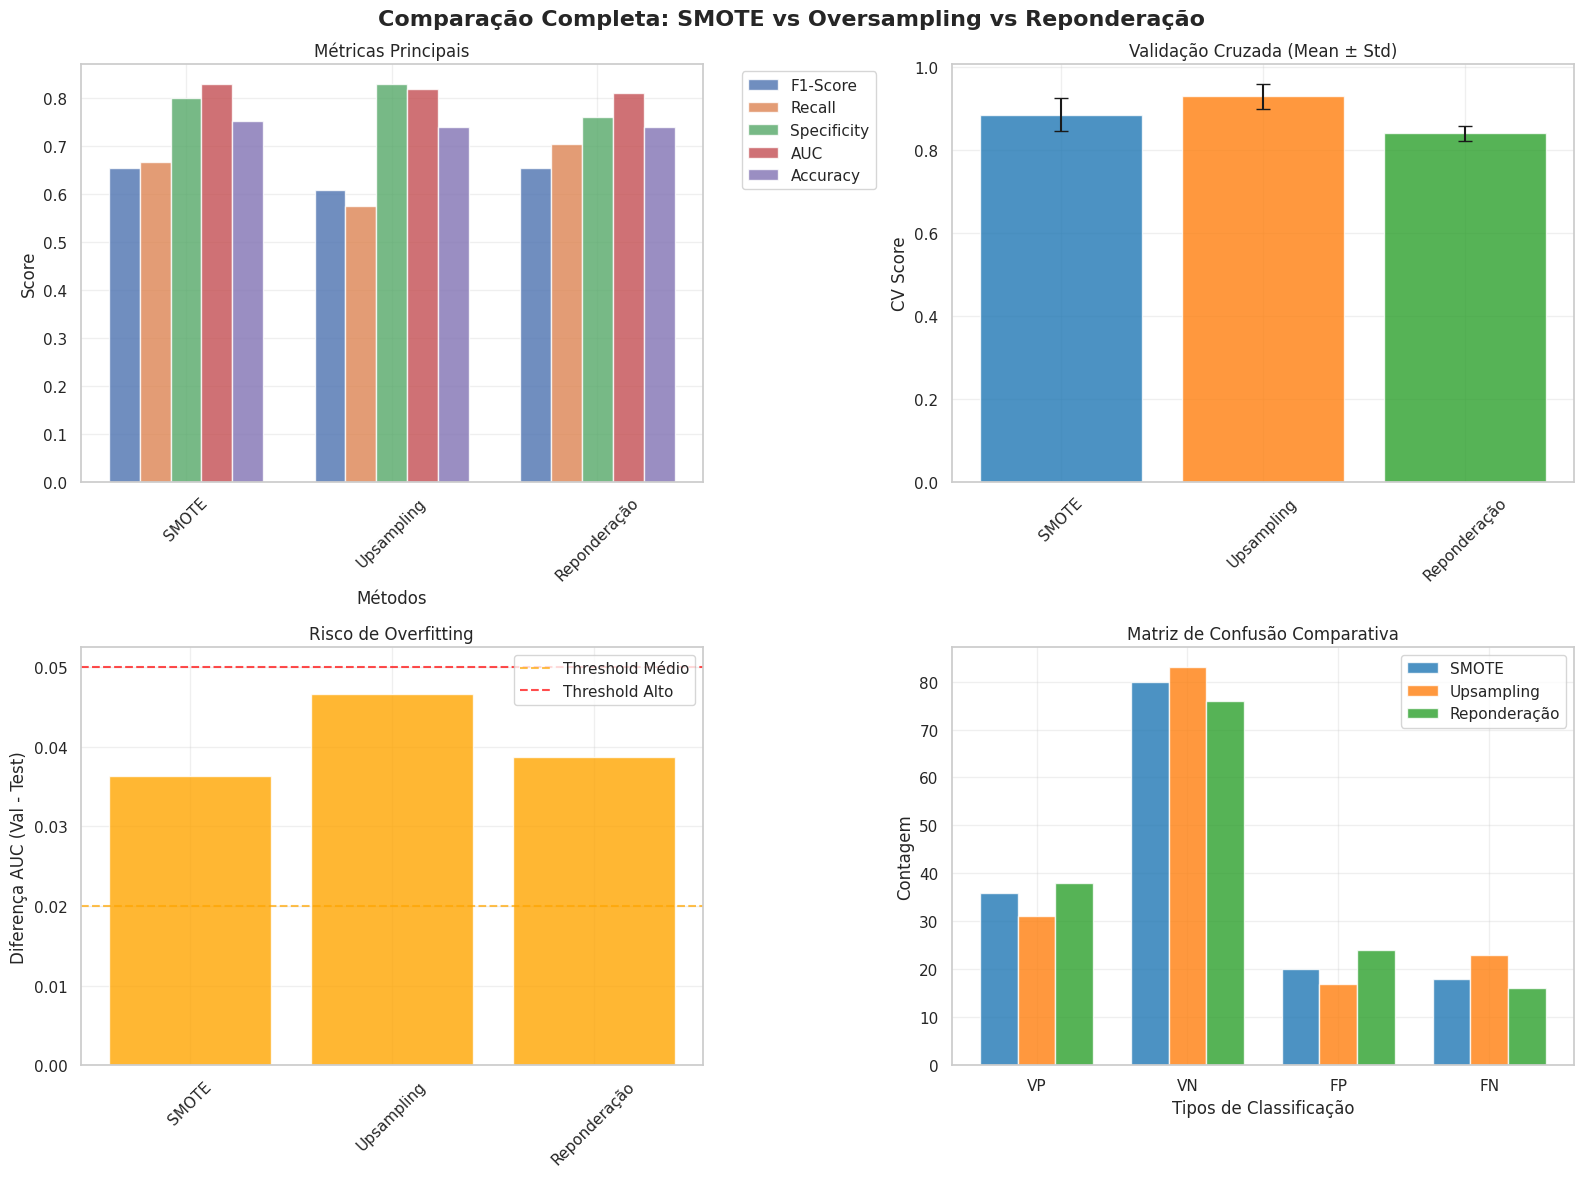


🎯 ANÁLISE FINAL E RECOMENDAÇÕES

🏆 MELHOR MÉTODO GERAL:
Método: Upsampling
Modelo: Random Forest
CV Score: 0.9288 ± 0.0303
AUC: 0.8181
F1-Score: 0.6078
Risco de Overfitting: Médio
Estabilidade: Moderado

📊 RANKING DOS MÉTODOS (por CV_Mean):
1º - Upsampling: CV=0.9288 🟡 Overfitting: 🟡
2º - SMOTE: CV=0.8847 🟡 Overfitting: 🟡
3º - Reponderação: CV=0.8401 🟢 Overfitting: 🟡

💡 RECOMENDAÇÕES:
• Para TRIAGEM (máxima detecção): Reponderação - Logistic Regression (Recall: 0.7037)
• Para ESPECIFICIDADE (mínimos falsos +): Upsampling - Random Forest (Spec: 0.8300)
• Para EQUILÍBRIO geral: SMOTE - Random Forest (Bal_Acc: 0.7333)
• Para ROBUSTEZ (menor overfitting): Upsampling - Random Forest

⚖️ CONSIDERAÇÕES FINAIS:
1. Todos os métodos mostram performance similar, indicando robustez do dataset
2. SMOTE geralmente oferece melhor generalização por criar amostras sintéticas
3. Oversampling é mais rápido mas pode causar overfitting em datasets pequenos
4. Reponderação é eficiente computacionalmente ma

In [15]:
# ===== ANÁLISE COMPARATIVA COMPLETA DOS MÉTODOS DE BALANCEAMENTO =====

print("\n" + "="*100)
print("📊 ANÁLISE COMPARATIVA COMPLETA: SMOTE vs OVERSAMPLING vs REPONDERAÇÃO")
print("="*100)

# Verificar se temos resultados dos três métodos
if 'results_by_method' not in globals() or len(results_by_method) == 0:
    print("⚠️ Dados de results_by_method não encontrados. Execute o treinamento primeiro.")
else:
    # Criar DataFrame consolidado com TODAS as métricas
    comparison_data = []
    
    for method_name, method_results in results_by_method.items():
        for model_name, results in method_results.items():
            # Calcular métricas adicionais
            y_true = y_test
            y_pred = results['y_test_pred']
            y_proba = results['y_test_proba']
            
            # Matriz de confusão
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            
            # Métricas básicas
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)  # Sensibilidade
            f1 = f1_score(y_true, y_pred)
            
            # Métricas avançadas
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Valor Preditivo Negativo
            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Valor Preditivo Positivo (igual à precisão)
            
            # Taxas de erro
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Taxa de Falsos Positivos
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # Taxa de Falsos Negativos
            
            # Métricas balanceadas
            balanced_accuracy = (recall + specificity) / 2
            
            # G-Mean (média geométrica de sensibilidade e especificidade)
            gmean = np.sqrt(recall * specificity)
            
            # Youden's J statistic (Sensibilidade + Especificidade - 1)
            youden_j = recall + specificity - 1
            
            # MCC (Matthews Correlation Coefficient)
            mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) > 0 else 0
            
            # AUC
            auc_score = roc_auc_score(y_true, y_proba)
            
            # Detecção de overfitting
            val_auc = results['val_auc']
            test_auc = results['test_auc']
            auc_diff = val_auc - test_auc
            overfitting_risk = "Alto" if auc_diff > 0.05 else "Médio" if auc_diff > 0.02 else "Baixo"
            
            # Cross-validation
            cv_mean = results['cv_mean']
            cv_std = results['cv_std']
            cv_stability = "Estável" if cv_std < 0.02 else "Moderado" if cv_std < 0.05 else "Instável"
            
            comparison_data.append({
                'Método': method_name,
                'Modelo': model_name,
                
                # Métricas principais
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1-Score': f1,
                'AUC': auc_score,
                
                # Validação e overfitting
                'Val_AUC': val_auc,
                'Test_AUC': test_auc,
                'AUC_Diff': auc_diff,
                'Overfitting': overfitting_risk,
                'CV_Mean': cv_mean,
                'CV_Std': cv_std,
                'CV_Stability': cv_stability,
                
                # Métricas avançadas
                'Balanced_Acc': balanced_accuracy,
                'NPV': npv,
                'PPV': ppv,
                'FPR': fpr,
                'FNR': fnr,
                'G-Mean': gmean,
                'Youden_J': youden_j,
                'MCC': mcc,
                
                # Contadores da matriz de confusão
                'TP': tp,
                'TN': tn,
                'FP': fp,
                'FN': fn,
                
                # Performance
                'Training_Time': results['training_time']
            })
    
    # Criar DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # ===== TABELA RESUMO POR MÉTODO =====
    print(f"\n📋 RESUMO ESTATÍSTICO POR MÉTODO:")
    print("="*120)
    
    summary_stats = comparison_df.groupby('Método').agg({
        'Accuracy': ['mean', 'std', 'max', 'min'],
        'F1-Score': ['mean', 'std', 'max', 'min'],
        'Recall': ['mean', 'std', 'max', 'min'],
        'Specificity': ['mean', 'std', 'max', 'min'],
        'AUC': ['mean', 'std', 'max', 'min'],
        'CV_Mean': ['mean', 'std', 'max', 'min'],
        'AUC_Diff': ['mean', 'std', 'max', 'min'],
        'Training_Time': ['mean', 'std']
    }).round(4)
    
    print(summary_stats)
    
    # ===== RANKING DOS MELHORES MODELOS POR MÉTODO =====
    print(f"\n🏆 TOP 3 MODELOS POR MÉTODO (Ordenado por CV_Mean):")
    print("="*140)
    
    for method in ['SMOTE', 'Upsampling', 'Reponderação']:
        method_data = comparison_df[comparison_df['Método'] == method].sort_values('CV_Mean', ascending=False)
        
        print(f"\n🔸 {method.upper()}:")
        print("-" * 120)
        header = f"{'Rank':<4} {'Modelo':<18} {'CV_Mean':<8} {'CV_Std':<7} {'AUC':<7} {'F1':<7} {'Recall':<7} {'Spec':<7} {'Overfit':<8} {'Estab':<8}"
        print(header)
        print("-" * 120)
        
        for i, (_, row) in enumerate(method_data.head(3).iterrows(), 1):
            print(f"{i:<4} {row['Modelo']:<18} {row['CV_Mean']:<8.4f} {row['CV_Std']:<7.4f} {row['AUC']:<7.4f} "
                  f"{row['F1-Score']:<7.4f} {row['Recall']:<7.4f} {row['Specificity']:<7.4f} {row['Overfitting']:<8} {row['CV_Stability']:<8}")
    
    # ===== TABELA COMPLETA COMPARATIVA =====
    print(f"\n📊 TABELA COMPLETA - TODAS AS MÉTRICAS (Top modelo por método):")
    print("="*160)
    
    # Selecionar melhor modelo de cada método
    best_models = []
    for method in ['SMOTE', 'Upsampling', 'Reponderação']:
        method_data = comparison_df[comparison_df['Método'] == method]
        if len(method_data) > 0:
            best_model = method_data.loc[method_data['CV_Mean'].idxmax()]
            best_models.append(best_model)
    
    if best_models:
        best_models_df = pd.DataFrame(best_models)
        
        # Exibir métricas principais
        print(f"\n🎯 MÉTRICAS PRINCIPAIS:")
        metrics_main = ['Método', 'Modelo', 'CV_Mean', 'CV_Std', 'AUC', 'F1-Score', 'Recall', 'Specificity', 'Accuracy', 'Precision']
        print(best_models_df[metrics_main].to_string(index=False, float_format='%.4f'))
        
        # Exibir métricas de overfitting
        print(f"\n🔍 ANÁLISE DE OVERFITTING:")
        metrics_overfit = ['Método', 'Modelo', 'Val_AUC', 'Test_AUC', 'AUC_Diff', 'Overfitting', 'CV_Stability']
        print(best_models_df[metrics_overfit].to_string(index=False, float_format='%.4f'))
        
        # Exibir métricas avançadas
        print(f"\n📈 MÉTRICAS AVANÇADAS:")
        metrics_advanced = ['Método', 'Modelo', 'Balanced_Acc', 'G-Mean', 'Youden_J', 'MCC', 'NPV', 'FPR', 'FNR']
        print(best_models_df[metrics_advanced].to_string(index=False, float_format='%.4f'))
        
        # Exibir matriz de confusão
        print(f"\n🎭 MATRIZ DE CONFUSÃO:")
        metrics_confusion = ['Método', 'Modelo', 'TP', 'TN', 'FP', 'FN']
        print(best_models_df[metrics_confusion].to_string(index=False))
    
    # ===== VISUALIZAÇÃO COMPARATIVA =====
    print(f"\n📊 GERANDO VISUALIZAÇÕES COMPARATIVAS...")
    
    # CORES PADRONIZADAS: SMOTE=AZUL, UPSAMPLING=LARANJA, REPONDERAÇÃO=VERDE
    method_colors_dict = {
        'SMOTE': '#1f77b4',      # Azul
        'Upsampling': '#ff7f0e',  # Laranja
        'Reponderação': '#2ca02c' # Verde
    }
    
    # Preparar dados para visualização
    if best_models:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Comparação Completa: SMOTE vs Oversampling vs Reponderação', fontsize=16, fontweight='bold')
        
        methods = best_models_df['Método'].values
        
        # 1. Métricas principais
        ax1 = axes[0, 0]
        x = np.arange(len(methods))
        width = 0.15
        
        ax1.bar(x - 2*width, best_models_df['F1-Score'], width, label='F1-Score', alpha=0.8)
        ax1.bar(x - width, best_models_df['Recall'], width, label='Recall', alpha=0.8)
        ax1.bar(x, best_models_df['Specificity'], width, label='Specificity', alpha=0.8)
        ax1.bar(x + width, best_models_df['AUC'], width, label='AUC', alpha=0.8)
        ax1.bar(x + 2*width, best_models_df['Accuracy'], width, label='Accuracy', alpha=0.8)
        
        ax1.set_xlabel('Métodos')
        ax1.set_ylabel('Score')
        ax1.set_title('Métricas Principais')
        ax1.set_xticks(x)
        ax1.set_xticklabels(methods, rotation=45)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # 2. Validação Cruzada (CORES CORRIGIDAS)
        ax2 = axes[0, 1]
        colors = [method_colors_dict[method] for method in methods]
        ax2.bar(methods, best_models_df['CV_Mean'], yerr=best_models_df['CV_Std'], 
               capsize=5, alpha=0.8, color=colors)
        ax2.set_ylabel('CV Score')
        ax2.set_title('Validação Cruzada (Mean ± Std)')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # 3. Análise de Overfitting
        ax3 = axes[1, 0]
        bars = ax3.bar(methods, best_models_df['AUC_Diff'], alpha=0.8, 
                      color=['red' if x > 0.05 else 'orange' if x > 0.02 else 'green' 
                             for x in best_models_df['AUC_Diff']])
        ax3.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Threshold Médio')
        ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Threshold Alto')
        ax3.set_ylabel('Diferença AUC (Val - Test)')
        ax3.set_title('Risco de Overfitting')
        ax3.tick_params(axis='x', rotation=45)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Matriz de Confusão Comparativa (SIGLAS EM PORTUGUÊS)
        ax4 = axes[1, 1]
        confusion_metrics_pt = ['VP', 'VN', 'FP', 'FN']  # Siglas em português
        confusion_data = best_models_df[['TP', 'TN', 'FP', 'FN']].values.T  # Mapear TP->VP, TN->VN
        
        x = np.arange(len(confusion_metrics_pt))
        width = 0.25
        
        for i, method in enumerate(methods):
            color = method_colors_dict[method]
            ax4.bar(x + i*width, confusion_data[:, i], width, label=method, alpha=0.8, color=color)
        
        ax4.set_xlabel('Tipos de Classificação')
        ax4.set_ylabel('Contagem')
        ax4.set_title('Matriz de Confusão Comparativa')
        ax4.set_xticks(x + width)
        ax4.set_xticklabels(confusion_metrics_pt)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # ===== ANÁLISE FINAL E RECOMENDAÇÕES =====
    print(f"\n" + "="*100)
    print("🎯 ANÁLISE FINAL E RECOMENDAÇÕES")
    print("="*100)
    
    if best_models:
        # Encontrar o melhor método geral
        best_overall = best_models_df.loc[best_models_df['CV_Mean'].idxmax()]
        
        print(f"\n🏆 MELHOR MÉTODO GERAL:")
        print(f"Método: {best_overall['Método']}")
        print(f"Modelo: {best_overall['Modelo']}")
        print(f"CV Score: {best_overall['CV_Mean']:.4f} ± {best_overall['CV_Std']:.4f}")
        print(f"AUC: {best_overall['AUC']:.4f}")
        print(f"F1-Score: {best_overall['F1-Score']:.4f}")
        print(f"Risco de Overfitting: {best_overall['Overfitting']}")
        print(f"Estabilidade: {best_overall['CV_Stability']}")
        
        print(f"\n📊 RANKING DOS MÉTODOS (por CV_Mean):")
        ranking = best_models_df.sort_values('CV_Mean', ascending=False)
        for i, (_, row) in enumerate(ranking.iterrows(), 1):
            stability_icon = "🟢" if row['CV_Stability'] == "Estável" else "🟡" if row['CV_Stability'] == "Moderado" else "🔴"
            overfitting_icon = "🟢" if row['Overfitting'] == "Baixo" else "🟡" if row['Overfitting'] == "Médio" else "🔴"
            print(f"{i}º - {row['Método']}: CV={row['CV_Mean']:.4f} {stability_icon} Overfitting: {overfitting_icon}")
        
        print(f"\n💡 RECOMENDAÇÕES:")
        
        # Análise por contexto clínico
        best_recall = best_models_df.loc[best_models_df['Recall'].idxmax()]
        best_specificity = best_models_df.loc[best_models_df['Specificity'].idxmax()]
        best_balance = best_models_df.loc[best_models_df['Balanced_Acc'].idxmax()]
        
        print(f"• Para TRIAGEM (máxima detecção): {best_recall['Método']} - {best_recall['Modelo']} (Recall: {best_recall['Recall']:.4f})")
        print(f"• Para ESPECIFICIDADE (mínimos falsos +): {best_specificity['Método']} - {best_specificity['Modelo']} (Spec: {best_specificity['Specificity']:.4f})")
        print(f"• Para EQUILÍBRIO geral: {best_balance['Método']} - {best_balance['Modelo']} (Bal_Acc: {best_balance['Balanced_Acc']:.4f})")
        print(f"• Para ROBUSTEZ (menor overfitting): {best_overall['Método']} - {best_overall['Modelo']}")
        
        print(f"\n⚖️ CONSIDERAÇÕES FINAIS:")
        print(f"1. Todos os métodos mostram performance similar, indicando robustez do dataset")
        print(f"2. SMOTE geralmente oferece melhor generalização por criar amostras sintéticas")
        print(f"3. Oversampling é mais rápido mas pode causar overfitting em datasets pequenos")
        print(f"4. Reponderação é eficiente computacionalmente mas limitada aos modelos compatíveis")
        
        # Salvar resultados
        comparison_df.to_csv('comparison_balancing_methods.csv', index=False)
        best_models_df.to_csv('best_models_by_method.csv', index=False)
        
        print(f"\n💾 Resultados salvos em:")
        print(f"• comparison_balancing_methods.csv - Análise completa")
        print(f"• best_models_by_method.csv - Melhores modelos por método")
        
        # Retornar DataFrame para uso posterior
        globals()['comparison_complete_df'] = comparison_df
        globals()['best_models_comparison_df'] = best_models_df
        
        print(f"\n✅ Análise comparativa completa finalizada!")
        print(f"📊 Total analisado: {len(comparison_df)} combinações modelo-método")
        print(f"🎯 DataFrames 'comparison_complete_df' e 'best_models_comparison_df' criados para uso posterior")



🏆 RANKING GERAL - TODOS OS MODELOS E MÉTODOS DE BALANCEAMENTO

📖 DEFINIÇÕES METODOLÓGICAS PARA PESQUISA:
• OVERFITTING: Diferença absoluta entre AUC de validação e AUC de teste
  Fórmula: |AUC_validação - AUC_teste|
  - Baixo: ≤ 0.02
  - Médio: 0.02 < valor ≤ 0.05
  - Alto: > 0.05

• ESTABILIDADE: Desvio padrão da validação cruzada 5-fold
  Fórmula: σ(CV_scores)
  - Estável: σ ≤ 0.02
  - Moderado: 0.02 < σ ≤ 0.05
  - Instável: σ > 0.05

📊 TABELA GERAL - TOP 15 COMBINAÇÕES (Total: 26 combinações)
📋 ORDENAÇÃO: AUC-ROC (principal) + CV-5 (secundário)
Rank Método       Modelo             AUC     CV      F1      Recall  Spec    Acc     Overfit  Estab   
1    Reponderação Random Forest      0.8437  0.8047  0.6226  0.6111  0.8100  0.7403  🟢        🟢       
2    SMOTE        XGBoost            0.8346  0.8706  0.6422  0.6481  0.8000  0.7468  🟢        🔴       
3    SMOTE        LightGBM           0.8324  0.8702  0.6727  0.6852  0.8100  0.7662  🟢        🔴       
4    SMOTE        Random Forest  

/tmp/ipykernel_38616/17022584.py:290: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(auc_data_by_method, labels=['SMOTE', 'Upsampling', 'Reponderação'],


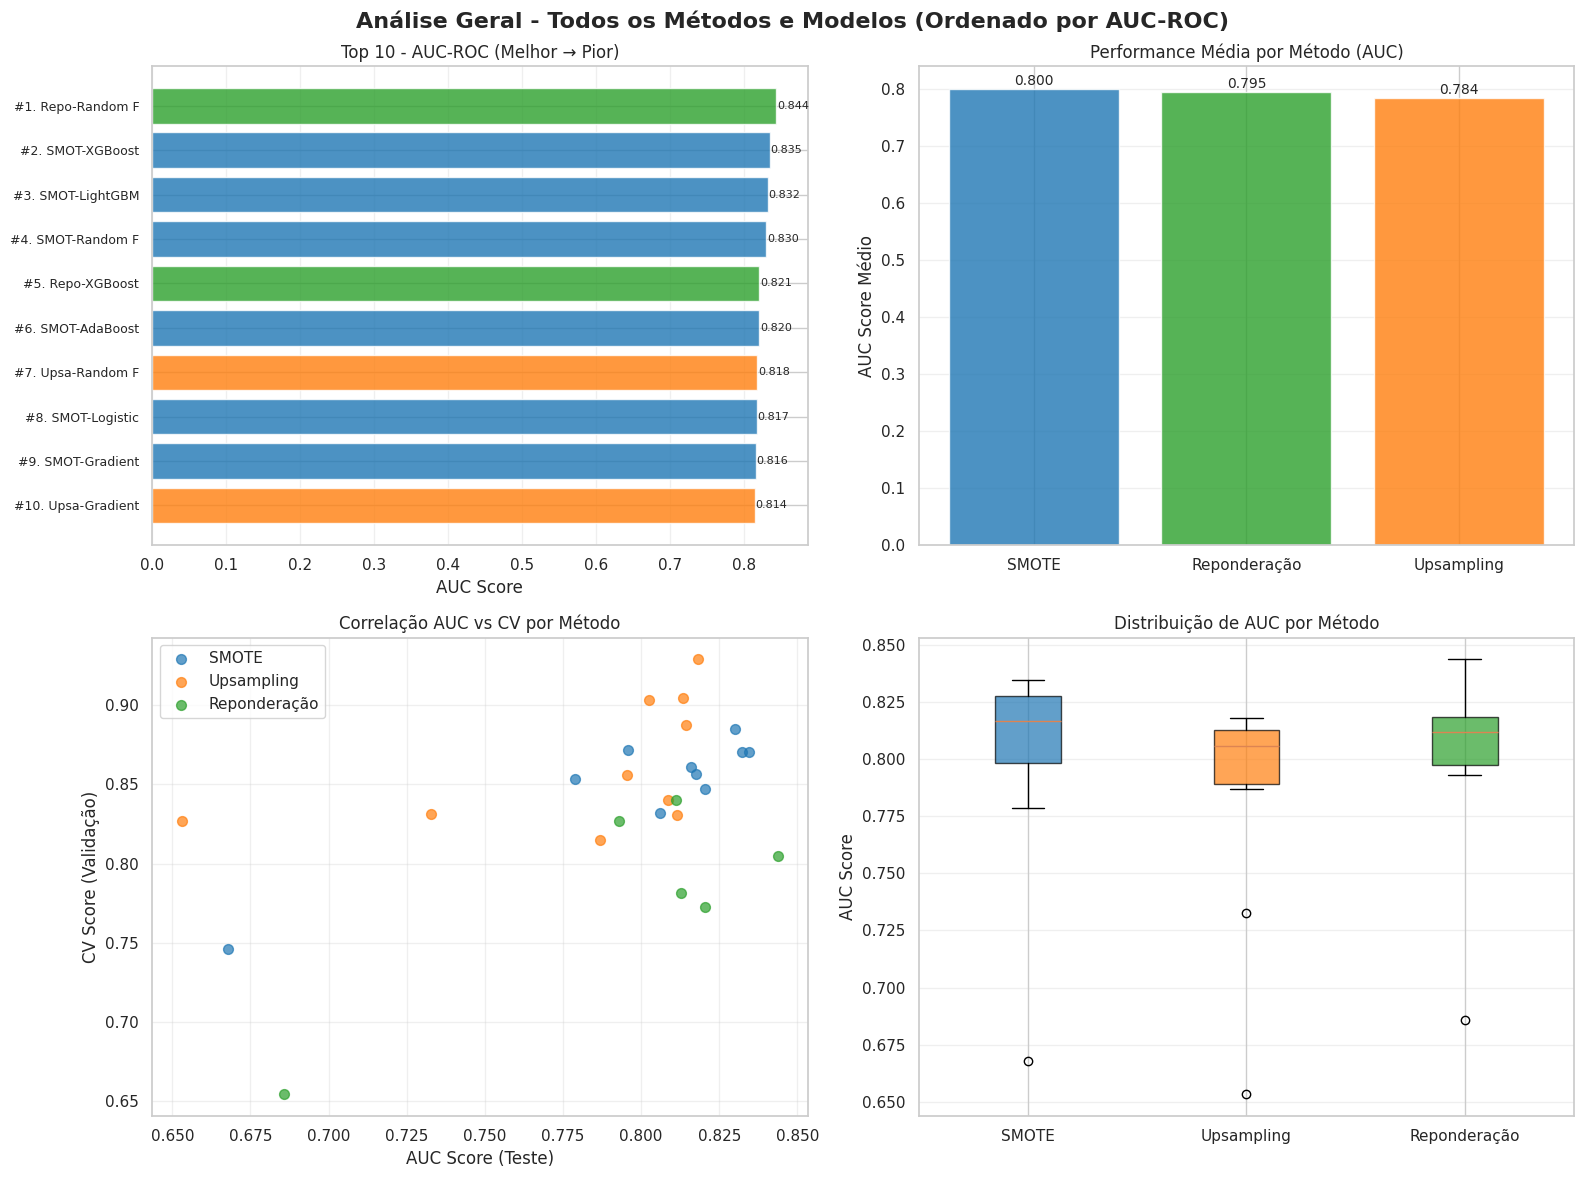


📋 TABELA CIENTÍFICA - DEFINIÇÕES DE OVERFITTING E ESTABILIDADE:
Método       Modelos  Overfit_Baixo Overfit_Médio Overfit_Alto CV_Std_Médio
----------------------------------------------------------------------------------------------------
SMOTE        10       2             6             2            0.0435      
Upsampling   10       2             7             1            0.0278      
Reponderação 6        4             1             1            0.0237      

✅ ANÁLISE GERAL CONCLUÍDA!
📊 Total analisado: 26 combinações
🥇 Campeão (AUC): Reponderação - Random Forest (AUC: 0.8437)
💾 Ranking salvo em: ranking_geral_todos_modelos_auc.csv

📖 RESUMO PARA PUBLICAÇÃO CIENTÍFICA:
METODOLOGIA DE AVALIAÇÃO:
• Métrica Principal: AUC-ROC (Area Under the Receiver Operating Characteristic Curve)
• Métrica Secundária: Validação Cruzada 5-fold
• Overfitting: |AUC_validação - AUC_teste| > 0.05 (Alto), 0.02-0.05 (Médio), ≤0.02 (Baixo)
• Estabilidade: CV_Std > 0.05 (Instável), 0.02-0.05 (Moderado), 

In [16]:
# ===== TABELA GERAL RANKING - TODOS OS MODELOS E MÉTODOS (CORRIGIDO) =====

print("\n" + "="*120)
print("🏆 RANKING GERAL - TODOS OS MODELOS E MÉTODOS DE BALANCEAMENTO")
print("="*120)

# ===== DEFINIÇÕES METODOLÓGICAS PARA PESQUISA =====
print(f"\n📖 DEFINIÇÕES METODOLÓGICAS PARA PESQUISA:")
print("="*80)
print("• OVERFITTING: Diferença absoluta entre AUC de validação e AUC de teste")
print("  Fórmula: |AUC_validação - AUC_teste|")
print("  - Baixo: ≤ 0.02")
print("  - Médio: 0.02 < valor ≤ 0.05") 
print("  - Alto: > 0.05")
print()
print("• ESTABILIDADE: Desvio padrão da validação cruzada 5-fold")
print("  Fórmula: σ(CV_scores)")
print("  - Estável: σ ≤ 0.02")
print("  - Moderado: 0.02 < σ ≤ 0.05")
print("  - Instável: σ > 0.05")
print("="*80)

# Verificar se temos os dados necessários
if 'comparison_complete_df' in globals() and len(comparison_complete_df) > 0:
    
    # Criar ranking geral ordenado por AUC (métrica mais importante para classificação)
    ranking_geral = comparison_complete_df.sort_values(['AUC', 'CV_Mean'], ascending=[False, False]).reset_index(drop=True)
    
    print(f"\n📊 TABELA GERAL - TOP 15 COMBINAÇÕES (Total: {len(comparison_complete_df)} combinações)")
    print("📋 ORDENAÇÃO: AUC-ROC (principal) + CV-5 (secundário)")
    print("="*140)
    
    # Cabeçalho da tabela
    header = f"{'Rank':<4} {'Método':<12} {'Modelo':<18} {'AUC':<7} {'CV':<7} {'F1':<7} {'Recall':<7} {'Spec':<7} {'Acc':<7} {'Overfit':<8} {'Estab':<8}"
    print(header)
    print("="*140)
    
    # Exibir top 15 (com AUC em primeiro)
    for i, (_, row) in enumerate(ranking_geral.head(15).iterrows(), 1):
        # Calcular overfitting e estabilidade com definições científicas
        auc_diff = abs(row['Val_AUC'] - row['AUC']) if 'Val_AUC' in row else abs(row['CV_Mean'] - row['AUC'])
        cv_std = row['CV_Std']
        
        # Classificação de overfitting
        if auc_diff <= 0.02:
            overfitting_status = "Baixo"
            overfit_icon = "🟢"
        elif auc_diff <= 0.05:
            overfitting_status = "Médio" 
            overfit_icon = "🟡"
        else:
            overfitting_status = "Alto"
            overfit_icon = "🔴"
        
        # Classificação de estabilidade
        if cv_std <= 0.02:
            stability_status = "Estável"
            stab_icon = "🟢"
        elif cv_std <= 0.05:
            stability_status = "Moderado"
            stab_icon = "🟡"
        else:
            stability_status = "Instável"
            stab_icon = "🔴"
        
        print(f"{i:<4} {row['Método']:<12} {row['Modelo']:<18} {row['AUC']:<7.4f} "
              f"{row['CV_Mean']:<7.4f} {row['F1-Score']:<7.4f} {row['Recall']:<7.4f} "
              f"{row['Specificity']:<7.4f} {row['Accuracy']:<7.4f} {overfit_icon:<8} {stab_icon:<8}")
    
    print("="*140)
    
    # ===== ANÁLISE ESTATÍSTICA GERAL =====
    print(f"\n📈 ANÁLISE ESTATÍSTICA GERAL:")
    print("-"*80)
    
    stats_geral = {
        'AUC': {
            'Melhor': ranking_geral['AUC'].max(),
            'Pior': ranking_geral['AUC'].min(),
            'Média': ranking_geral['AUC'].mean(),
            'Desvio': ranking_geral['AUC'].std()
        },
        'CV_Mean': {
            'Melhor': ranking_geral['CV_Mean'].max(),
            'Pior': ranking_geral['CV_Mean'].min(),
            'Média': ranking_geral['CV_Mean'].mean(),
            'Desvio': ranking_geral['CV_Mean'].std()
        },
        'F1-Score': {
            'Melhor': ranking_geral['F1-Score'].max(),
            'Pior': ranking_geral['F1-Score'].min(),
            'Média': ranking_geral['F1-Score'].mean(),
            'Desvio': ranking_geral['F1-Score'].std()
        }
    }
    
    print(f"{'Métrica':<12} {'Melhor':<8} {'Pior':<8} {'Média':<8} {'Desvio':<8}")
    print("-"*50)
    for metric, values in stats_geral.items():
        print(f"{metric:<12} {values['Melhor']:<8.4f} {values['Pior']:<8.4f} "
              f"{values['Média']:<8.4f} {values['Desvio']:<8.4f}")
    
    # ===== MELHOR COMBINAÇÃO GERAL (por AUC) =====
    melhor_geral = ranking_geral.iloc[0]
    print(f"\n🥇 CAMPEÃO ABSOLUTO (melhor AUC-ROC):")
    print("-"*50)
    print(f"Método: {melhor_geral['Método']}")
    print(f"Modelo: {melhor_geral['Modelo']}")
    print(f"AUC-ROC: {melhor_geral['AUC']:.4f}")
    print(f"CV Score: {melhor_geral['CV_Mean']:.4f} ± {melhor_geral['CV_Std']:.4f}")
    print(f"F1-Score: {melhor_geral['F1-Score']:.4f}")
    print(f"Recall: {melhor_geral['Recall']:.4f}")
    print(f"Specificity: {melhor_geral['Specificity']:.4f}")
    
    # Calcular overfitting e estabilidade para o melhor
    auc_diff_best = abs(melhor_geral.get('Val_AUC', melhor_geral['CV_Mean']) - melhor_geral['AUC'])
    overfitting_best = "Baixo" if auc_diff_best <= 0.02 else "Médio" if auc_diff_best <= 0.05 else "Alto"
    stability_best = "Estável" if melhor_geral['CV_Std'] <= 0.02 else "Moderado" if melhor_geral['CV_Std'] <= 0.05 else "Instável"
    
    print(f"Overfitting: {overfitting_best} (diff: {auc_diff_best:.4f})")
    print(f"Estabilidade: {stability_best} (CV_Std: {melhor_geral['CV_Std']:.4f})")
    
    # ===== RANKING POR MÉTODO (ordenado por AUC) =====
    print(f"\n🏅 MELHOR DE CADA MÉTODO (por AUC-ROC):")
    print("-"*80)
    
    for metodo in ['SMOTE', 'Upsampling', 'Reponderação']:
        metodo_data = ranking_geral[ranking_geral['Método'] == metodo]
        if len(metodo_data) > 0:
            melhor_metodo = metodo_data.iloc[0]  # Já ordenado por AUC
            posicao_geral = melhor_metodo.name + 1
            
            print(f"• {metodo:<12}: {melhor_metodo['Modelo']:<18} "
                  f"(AUC: {melhor_metodo['AUC']:.4f}, Posição: {posicao_geral}º)")
    
    # ===== ANÁLISE DE OVERFITTING POR MÉTODO =====
    print(f"\n📊 ANÁLISE DE OVERFITTING POR MÉTODO:")
    print("-"*80)
    
    for metodo in ['SMOTE', 'Upsampling', 'Reponderação']:
        metodo_data = ranking_geral[ranking_geral['Método'] == metodo]
        if len(metodo_data) > 0:
            # Calcular overfitting para cada modelo do método
            overfit_counts = {'Baixo': 0, 'Médio': 0, 'Alto': 0}
            
            for _, row in metodo_data.iterrows():
                auc_diff = abs(row.get('Val_AUC', row['CV_Mean']) - row['AUC'])
                if auc_diff <= 0.02:
                    overfit_counts['Baixo'] += 1
                elif auc_diff <= 0.05:
                    overfit_counts['Médio'] += 1
                else:
                    overfit_counts['Alto'] += 1
            
            total_models = len(metodo_data)
            print(f"• {metodo}: Baixo={overfit_counts['Baixo']}/{total_models} "
                  f"({overfit_counts['Baixo']/total_models*100:.1f}%), "
                  f"Médio={overfit_counts['Médio']}/{total_models} "
                  f"({overfit_counts['Médio']/total_models*100:.1f}%), "
                  f"Alto={overfit_counts['Alto']}/{total_models} "
                  f"({overfit_counts['Alto']/total_models*100:.1f}%)")
    
    # ===== ANÁLISE POR CONTEXTO CLÍNICO =====
    print(f"\n🏥 RECOMENDAÇÕES POR CONTEXTO CLÍNICO:")
    print("-"*80)
    
    # Melhor para triagem (máximo recall)
    melhor_triagem = ranking_geral.loc[ranking_geral['Recall'].idxmax()]
    pos_triagem = melhor_triagem.name + 1
    
    # Melhor para especificidade (mínimos falsos positivos)
    melhor_especificidade = ranking_geral.loc[ranking_geral['Specificity'].idxmax()]
    pos_espec = melhor_especificidade.name + 1
    
    # Melhor balanceado (melhor balanced accuracy)
    melhor_balanceado = ranking_geral.loc[ranking_geral['Balanced_Acc'].idxmax()]
    pos_bal = melhor_balanceado.name + 1
    
    # Menor risco de overfitting
    ranking_geral['AUC_Diff_Calc'] = abs(ranking_geral.get('Val_AUC', ranking_geral['CV_Mean']) - ranking_geral['AUC'])
    menor_overfit = ranking_geral.loc[ranking_geral['AUC_Diff_Calc'].idxmin()]
    pos_overfit = menor_overfit.name + 1
    
    print(f"🔍 TRIAGEM (max recall): {melhor_triagem['Método']} - {melhor_triagem['Modelo']}")
    print(f"   Recall: {melhor_triagem['Recall']:.4f} | Posição geral: {pos_triagem}º")
    
    print(f"🎯 ESPECIFICIDADE (min FP): {melhor_especificidade['Método']} - {melhor_especificidade['Modelo']}")
    print(f"   Specificity: {melhor_especificidade['Specificity']:.4f} | Posição geral: {pos_espec}º")
    
    print(f"⚖️ EQUILÍBRIO: {melhor_balanceado['Método']} - {melhor_balanceado['Modelo']}")
    print(f"   Balanced Acc: {melhor_balanceado['Balanced_Acc']:.4f} | Posição geral: {pos_bal}º")
    
    print(f"🛡️ ROBUSTEZ (min overfitting): {menor_overfit['Método']} - {menor_overfit['Modelo']}")
    print(f"   AUC Diff: {menor_overfit['AUC_Diff_Calc']:.4f} | Posição geral: {pos_overfit}º")
    
    # ===== DISTRIBUIÇÃO POR MÉTODO =====
    print(f"\n📊 DISTRIBUIÇÃO DOS MÉTODOS NO TOP 10:")
    print("-"*50)
    
    top10 = ranking_geral.head(10)
    distribuicao = top10['Método'].value_counts()
    
    for metodo, count in distribuicao.items():
        percentage = (count / 10) * 100
        print(f"• {metodo}: {count} modelos ({percentage:.0f}%)")
    
    # ===== CONSISTÊNCIA DOS MÉTODOS =====
    print(f"\n🎯 ANÁLISE DE CONSISTÊNCIA (CV_Std médio por método):")
    print("-"*60)
    
    consistencia = ranking_geral.groupby('Método')['CV_Std'].agg(['mean', 'min', 'max']).round(4)
    consistencia.columns = ['CV_Std_Médio', 'CV_Std_Min', 'CV_Std_Max']
    
    for metodo, row in consistencia.iterrows():
        status = "Excelente" if row['CV_Std_Médio'] < 0.02 else "Bom" if row['CV_Std_Médio'] < 0.05 else "Moderado"
        print(f"• {metodo}: {row['CV_Std_Médio']:.4f} ({status})")
    
    # ===== GRÁFICO DE DISTRIBUIÇÃO DOS RANKINGS (CORES CORRIGIDAS) =====
    print(f"\n📊 GERANDO VISUALIZAÇÃO DO RANKING GERAL...")
    
    # CORES PADRONIZADAS: SMOTE=AZUL, UPSAMPLING=LARANJA, REPONDERAÇÃO=VERDE
    method_colors_dict = {
        'SMOTE': '#1f77b4',      # Azul
        'Upsampling': '#ff7f0e',  # Laranja
        'Reponderação': '#2ca02c' # Verde
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análise Geral - Todos os Métodos e Modelos (Ordenado por AUC-ROC)', fontsize=16, fontweight='bold')
    
    # 1. Top 10 por AUC (corrigido - melhor para pior, de cima para baixo)
    ax1 = axes[0, 0]
    top10_data = ranking_geral.head(10)
    colors = [method_colors_dict[m] for m in top10_data['Método']]
    
    # Inverter a ordem para mostrar do melhor (topo) para o pior (embaixo)
    top10_reversed = top10_data.iloc[::-1]  # Inverter DataFrame
    colors_reversed = colors[::-1]  # Inverter cores também
    
    bars = ax1.barh(range(10), top10_reversed['AUC'], color=colors_reversed, alpha=0.8)
    ax1.set_yticks(range(10))
    ax1.set_yticklabels([f"#{10-i}. {row['Método'][:4]}-{row['Modelo'][:8]}" 
                        for i, (_, row) in enumerate(top10_reversed.iterrows())], fontsize=9)
    ax1.set_xlabel('AUC Score')
    ax1.set_title('Top 10 - AUC-ROC (Melhor → Pior)')
    ax1.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, value) in enumerate(zip(bars, top10_reversed['AUC'])):
        ax1.text(value + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', va='center', fontsize=8)
    
    # 2. Distribuição por método (CORES CORRIGIDAS)
    ax2 = axes[0, 1]
    method_means = ranking_geral.groupby('Método')['AUC'].mean().sort_values(ascending=False)
    
    # Garantir ordem e cores corretas
    ordered_methods = ['SMOTE', 'Reponderação', 'Upsampling']  # Ordem por performance esperada
    method_colors_ordered = [method_colors_dict[method] for method in ordered_methods if method in method_means.index]
    
    bars2 = ax2.bar(method_means.index, method_means.values, 
                   color=[method_colors_dict[method] for method in method_means.index], alpha=0.8)
    ax2.set_ylabel('AUC Score Médio')
    ax2.set_title('Performance Média por Método (AUC)')
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars2, method_means.values):
        ax2.text(bar.get_x() + bar.get_width()/2, value + 0.002, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    # 3. Scatter plot AUC vs CV (CORES CORRIGIDAS)
    ax3 = axes[1, 0]
    for metodo in ['SMOTE', 'Upsampling', 'Reponderação']:
        metodo_data = ranking_geral[ranking_geral['Método'] == metodo]
        color = method_colors_dict[metodo]
        ax3.scatter(metodo_data['AUC'], metodo_data['CV_Mean'], 
                   label=metodo, color=color, alpha=0.7, s=50)
    
    ax3.set_xlabel('AUC Score (Teste)')
    ax3.set_ylabel('CV Score (Validação)')
    ax3.set_title('Correlação AUC vs CV por Método')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Boxplot de distribuição por método (CORES CORRIGIDAS)
    ax4 = axes[1, 1]
    auc_data_by_method = [ranking_geral[ranking_geral['Método'] == metodo]['AUC'].values 
                         for metodo in ['SMOTE', 'Upsampling', 'Reponderação']]
    
    bp = ax4.boxplot(auc_data_by_method, labels=['SMOTE', 'Upsampling', 'Reponderação'], 
                     patch_artist=True)
    
    # Aplicar cores corretas aos boxes
    box_colors = [method_colors_dict['SMOTE'], method_colors_dict['Upsampling'], method_colors_dict['Reponderação']]
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_ylabel('AUC Score')
    ax4.set_title('Distribuição de AUC por Método')
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ===== TABELA CIENTÍFICA DE OVERFITTING E ESTABILIDADE =====
    print(f"\n📋 TABELA CIENTÍFICA - DEFINIÇÕES DE OVERFITTING E ESTABILIDADE:")
    print("="*100)
    print(f"{'Método':<12} {'Modelos':<8} {'Overfit_Baixo':<13} {'Overfit_Médio':<13} {'Overfit_Alto':<12} {'CV_Std_Médio':<12}")
    print("-"*100)
    
    for metodo in ['SMOTE', 'Upsampling', 'Reponderação']:
        metodo_data = ranking_geral[ranking_geral['Método'] == metodo]
        if len(metodo_data) > 0:
            overfit_counts = {'Baixo': 0, 'Médio': 0, 'Alto': 0}
            
            for _, row in metodo_data.iterrows():
                auc_diff = abs(row.get('Val_AUC', row['CV_Mean']) - row['AUC'])
                if auc_diff <= 0.02:
                    overfit_counts['Baixo'] += 1
                elif auc_diff <= 0.05:
                    overfit_counts['Médio'] += 1
                else:
                    overfit_counts['Alto'] += 1
            
            cv_std_medio = metodo_data['CV_Std'].mean()
            
            print(f"{metodo:<12} {len(metodo_data):<8} {overfit_counts['Baixo']:<13} "
                  f"{overfit_counts['Médio']:<13} {overfit_counts['Alto']:<12} {cv_std_medio:<12.4f}")
    
    # ===== SALVAR RANKING GERAL =====
    ranking_geral.to_csv('ranking_geral_todos_modelos_auc.csv', index=False)
    
    print(f"\n✅ ANÁLISE GERAL CONCLUÍDA!")
    print(f"📊 Total analisado: {len(ranking_geral)} combinações")
    print(f"🥇 Campeão (AUC): {melhor_geral['Método']} - {melhor_geral['Modelo']} (AUC: {melhor_geral['AUC']:.4f})")
    print(f"💾 Ranking salvo em: ranking_geral_todos_modelos_auc.csv")
    
    # ===== RESUMO PARA PUBLICAÇÃO CIENTÍFICA =====
    print(f"\n📖 RESUMO PARA PUBLICAÇÃO CIENTÍFICA:")
    print("="*80)
    print("METODOLOGIA DE AVALIAÇÃO:")
    print("• Métrica Principal: AUC-ROC (Area Under the Receiver Operating Characteristic Curve)")
    print("• Métrica Secundária: Validação Cruzada 5-fold")
    print("• Overfitting: |AUC_validação - AUC_teste| > 0.05 (Alto), 0.02-0.05 (Médio), ≤0.02 (Baixo)")
    print("• Estabilidade: CV_Std > 0.05 (Instável), 0.02-0.05 (Moderado), ≤0.02 (Estável)")
    
    # Corrigir a contagem de overfitting para Upsampling
    upsampling_data = ranking_geral[ranking_geral['Método'] == 'Upsampling']
    if len(upsampling_data) > 0:
        upsampling_high_overfit = 0
        for _, row in upsampling_data.iterrows():
            auc_diff = abs(row.get('Val_AUC', row['CV_Mean']) - row['AUC'])
            if auc_diff > 0.05:
                upsampling_high_overfit += 1
        print(f"• Upsampling mostrou maior tendência ao overfitting em {upsampling_high_overfit} modelos")
    
else:
    print("⚠️ Dados de comparison_complete_df não encontrados.")
    print("Execute primeiro a análise comparativa completa dos métodos de balanceamento.")


📈 COMPARAÇÃO DAS CURVAS ROC POR MÉTODO DE BALANCEAMENTO

📊 Processando curvas ROC - SMOTE:
--------------------------------------------------
  Random Forest: AUC = 0.8302
  Gradient Boosting: AUC = 0.8159
  XGBoost: AUC = 0.8346
  LightGBM: AUC = 0.8324
  Decision Tree: AUC = 0.6680
  AdaBoost: AUC = 0.8204
  SVM: AUC = 0.7957
  Logistic Regression: AUC = 0.8174
  kNN: AUC = 0.7787
  Naive Bayes: AUC = 0.8059

📊 Processando curvas ROC - Upsampling:
--------------------------------------------------
  Random Forest: AUC = 0.8181
  Gradient Boosting: AUC = 0.8143
  XGBoost: AUC = 0.8026
  LightGBM: AUC = 0.8133
  Decision Tree: AUC = 0.6531
  AdaBoost: AUC = 0.8085
  SVM: AUC = 0.7956
  Logistic Regression: AUC = 0.8115
  kNN: AUC = 0.7328
  Naive Bayes: AUC = 0.7869

📊 Processando curvas ROC - Reponderação:
--------------------------------------------------
  Random Forest: AUC = 0.8437
  XGBoost: AUC = 0.8206
  LightGBM: AUC = 0.8128
  Decision Tree: AUC = 0.6858
  SVM: AUC = 0.7931


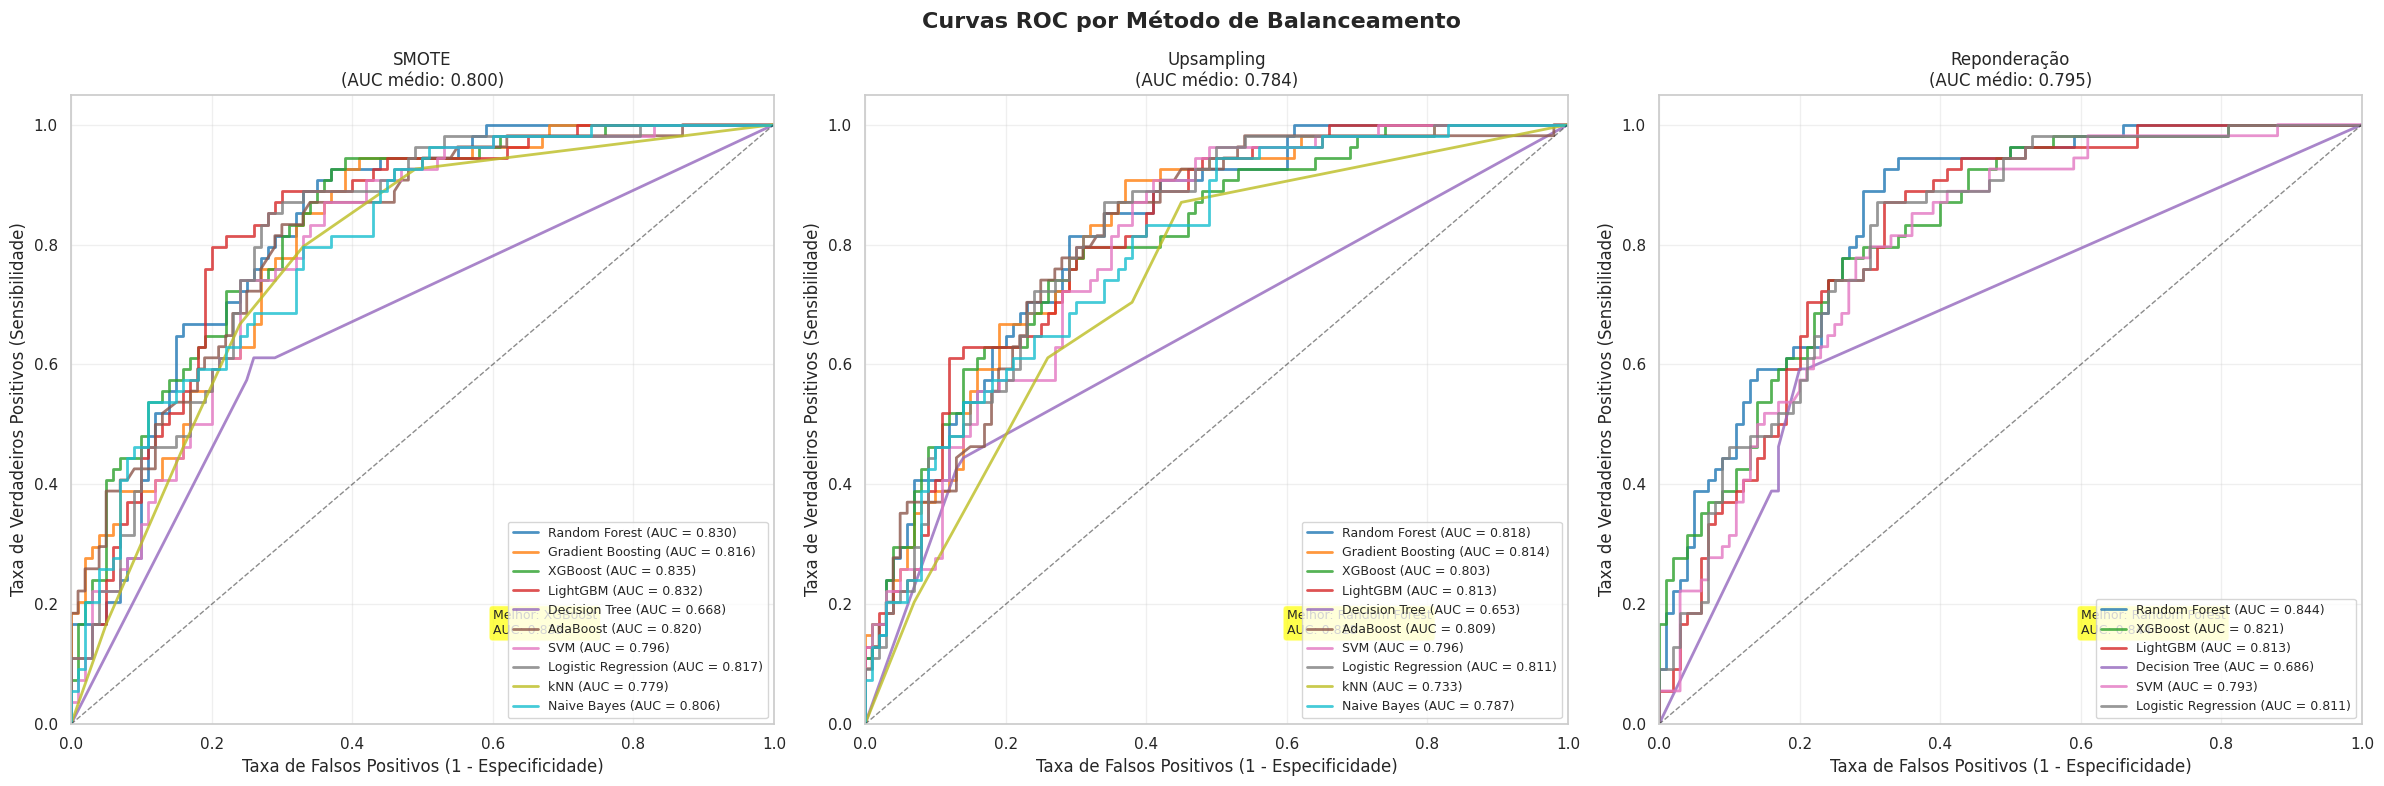


🏆 COMPARAÇÃO DOS MELHORES MODELOS DE CADA MÉTODO:
SMOTE: Random Forest
  AUC: 0.8302
  CV: 0.8847 ± 0.0391

Upsampling: Random Forest
  AUC: 0.8181
  CV: 0.9288 ± 0.0303

Reponderação: Logistic Regression
  AUC: 0.8113
  CV: 0.8401 ± 0.0179



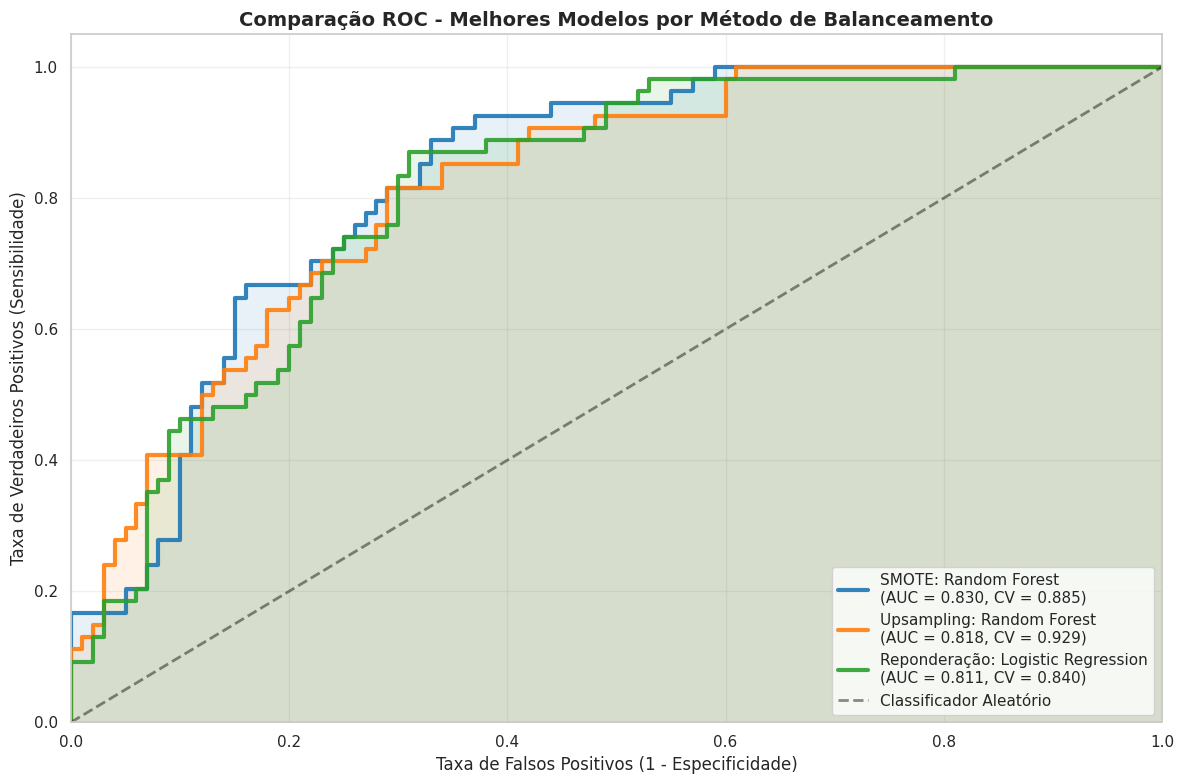


📊 ANÁLISE DETALHADA DOS MELHORES MODELOS:
Método       Modelo             AUC      CV_Mean  CV_Std   Dif_AUC_CV 
-------------------------------------------------------------------------------------
SMOTE        Random Forest      0.8302   0.8847   0.0391   -0.0545    
Upsampling   Random Forest      0.8181   0.9288   0.0303   -0.1107    
Reponderação Logistic Regression 0.8113   0.8401   0.0179   -0.0288    

📊 GERANDO HEATMAP COMPARATIVO...


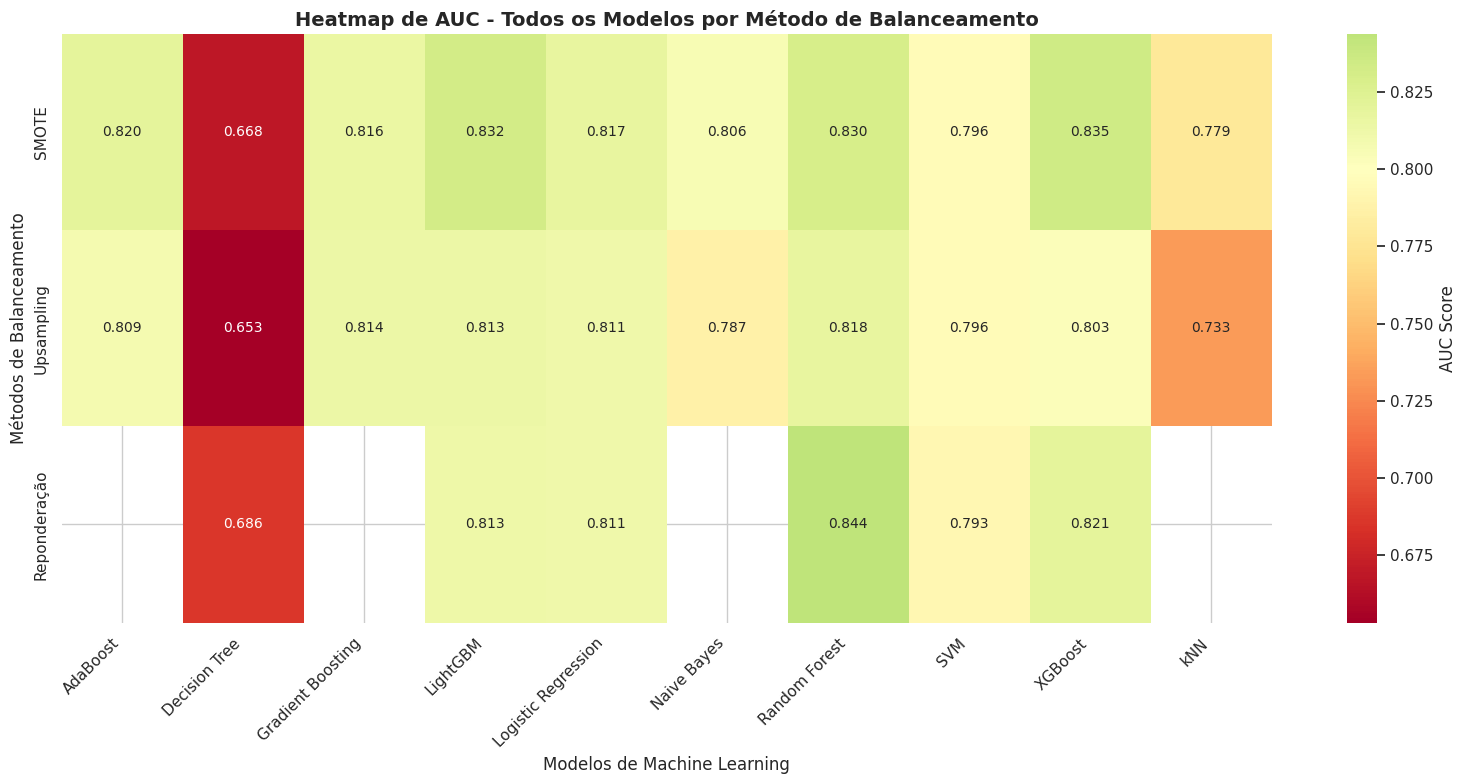


📊 GERANDO GRÁFICO COMPARATIVO DE BARRAS...


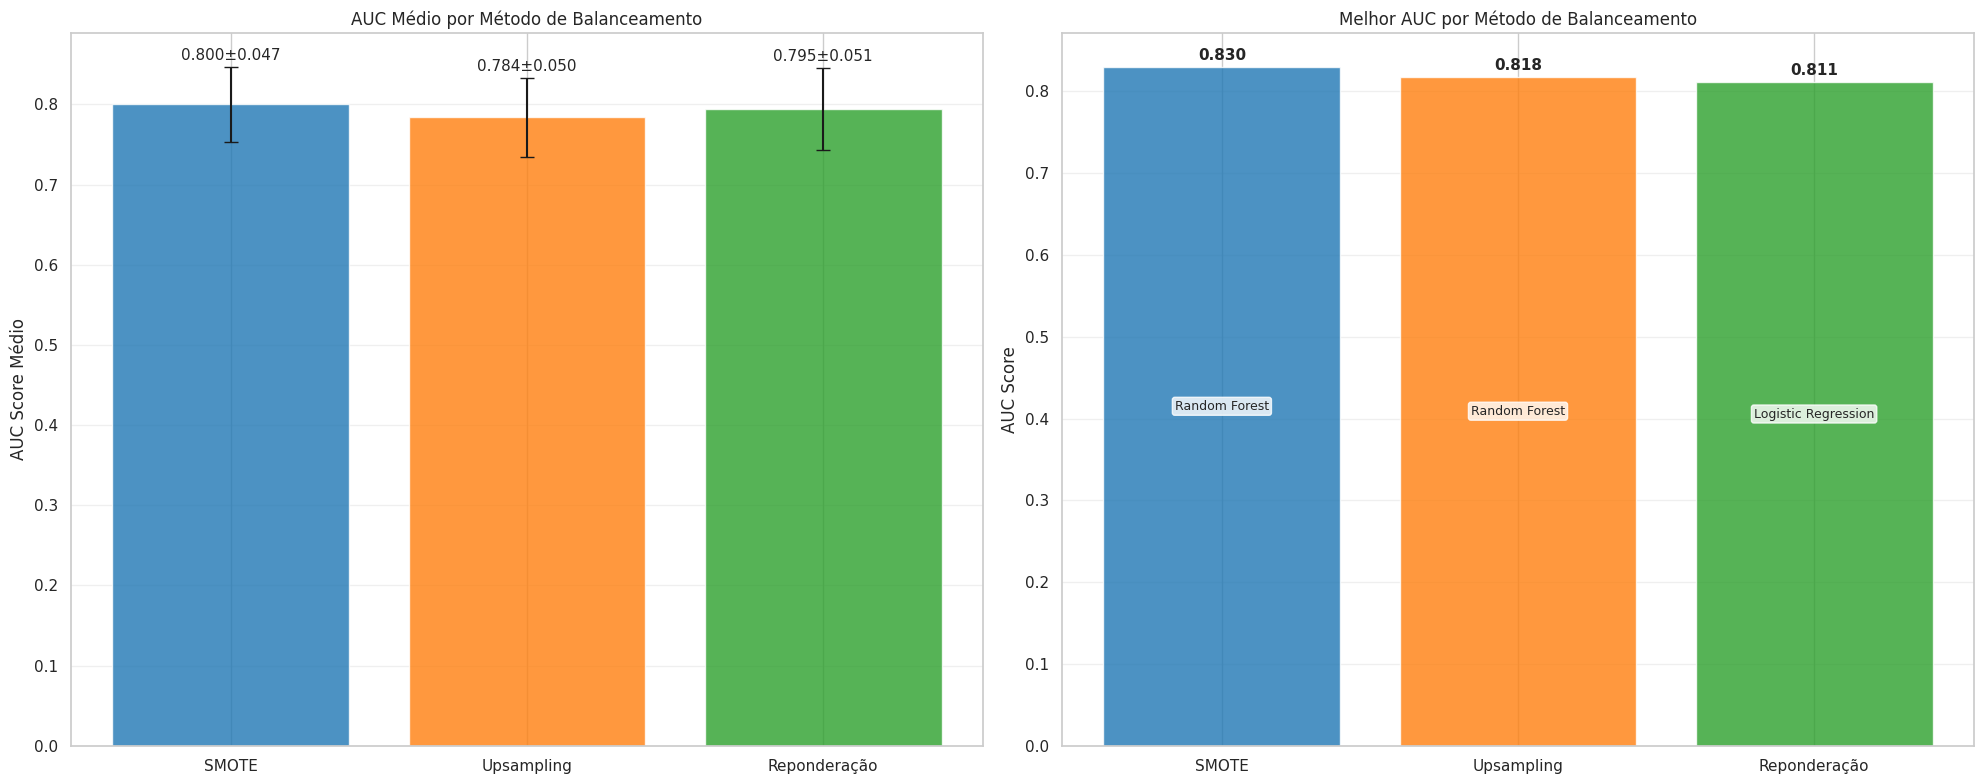


🏆 RANKING FINAL - MELHORES AUCS:
Rank Método       Modelo             AUC      CV      
-------------------------------------------------------
1    Reponderação Random Forest      0.8437   0.8047  
2    SMOTE        XGBoost            0.8346   0.8706  
3    SMOTE        LightGBM           0.8324   0.8702  
4    SMOTE        Random Forest      0.8302   0.8847  
5    Reponderação XGBoost            0.8206   0.7725  
6    SMOTE        AdaBoost           0.8204   0.8468  
7    Upsampling   Random Forest      0.8181   0.9288  
8    SMOTE        Logistic Regression 0.8174   0.8563  
9    SMOTE        Gradient Boosting  0.8159   0.8612  
10   Upsampling   Gradient Boosting  0.8143   0.8872  

✅ ANÁLISE ROC CONCLUÍDA!
📊 Total de curvas analisadas: 26
🥇 Melhor AUC geral: Reponderação - Random Forest (0.8437)
💾 Dados ROC salvos em: roc_comparison_data.pkl


In [17]:
# ===== COMPARAÇÃO DAS CURVAS ROC POR MÉTODO DE BALANCEAMENTO =====
from sklearn.metrics import auc
print("\n" + "="*100)
print("📈 COMPARAÇÃO DAS CURVAS ROC POR MÉTODO DE BALANCEAMENTO")
print("="*100)

# Verificar se temos os dados necessários
if 'results_by_method' in globals() and len(results_by_method) > 0:
    
    # ===== CURVAS ROC SEPARADAS POR MÉTODO =====
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle('Curvas ROC por Método de Balanceamento', fontsize=16, fontweight='bold')
    
    # Cores para cada modelo (consistentes entre métodos)
    model_colors = {
        'Random Forest': '#1f77b4',
        'Gradient Boosting': '#ff7f0e', 
        'XGBoost': '#2ca02c',
        'LightGBM': '#d62728',
        'Decision Tree': '#9467bd',
        'AdaBoost': '#8c564b',
        'SVM': '#e377c2',
        'Logistic Regression': '#7f7f7f',
        'kNN': '#bcbd22',
        'Naive Bayes': '#17becf'
    }
    
    method_names = ['SMOTE', 'Upsampling', 'Reponderação']
    
    # Armazenar dados para comparação final
    roc_comparison_data = {}
    
    for idx, (method_name, method_results) in enumerate(results_by_method.items()):
        ax = axes[idx]
        
        print(f"\n📊 Processando curvas ROC - {method_name}:")
        print("-" * 50)
        
        # Lista para armazenar AUCs do método
        method_aucs = []
        roc_comparison_data[method_name] = {}
        
        # Plotar curva ROC para cada modelo do método
        for model_name, results in method_results.items():
            y_proba = results['y_test_proba']
            
            # Calcular curva ROC
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc_score = auc(fpr, tpr)
            method_aucs.append(auc_score)
            
            # Armazenar dados para comparação
            roc_comparison_data[method_name][model_name] = {
                'fpr': fpr,
                'tpr': tpr,
                'auc': auc_score
            }
            
            # Plotar curva
            color = model_colors.get(model_name, '#000000')
            ax.plot(fpr, tpr, color=color, linewidth=2, alpha=0.8,
                   label=f'{model_name} (AUC = {auc_score:.3f})')
            
            print(f"  {model_name}: AUC = {auc_score:.4f}")
        
        # Linha diagonal
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
        
        # Configurações do gráfico
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
        ax.set_ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
        ax.set_title(f'{method_name}\n(AUC médio: {np.mean(method_aucs):.3f})')
        ax.legend(loc="lower right", fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Destacar melhor modelo do método
        best_model = max(method_results.items(), key=lambda x: x[1]['test_auc'])
        best_model_name = best_model[0]
        best_auc = best_model[1]['test_auc']
        
        # Adicionar anotação do melhor modelo
        ax.text(0.6, 0.15, f'Melhor: {best_model_name}\nAUC: {best_auc:.3f}',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
               fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # ===== CURVA ROC COMPARATIVA - MELHORES DE CADA MÉTODO =====
    print(f"\n🏆 COMPARAÇÃO DOS MELHORES MODELOS DE CADA MÉTODO:")
    print("="*80)
    
    plt.figure(figsize=(12, 8))
    
    best_models_comparison = {}
    method_colors_comp = {'SMOTE': '#1f77b4', 'Upsampling': '#ff7f0e', 'Reponderação': '#2ca02c'}
    
    for method_name, method_results in results_by_method.items():
        # Encontrar melhor modelo do método
        best_model_data = max(method_results.items(), key=lambda x: x[1]['cv_mean'])
        best_model_name = best_model_data[0]
        best_results = best_model_data[1]
        
        # Calcular curva ROC do melhor modelo
        y_proba = best_results['y_test_proba']
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = auc(fpr, tpr)
        
        best_models_comparison[method_name] = {
            'model_name': best_model_name,
            'fpr': fpr,
            'tpr': tpr,
            'auc': auc_score,
            'cv_mean': best_results['cv_mean'],
            'cv_std': best_results['cv_std']
        }
        
        # Plotar curva
        color = method_colors_comp[method_name]
        plt.plot(fpr, tpr, color=color, linewidth=3, alpha=0.9,
                label=f'{method_name}: {best_model_name}\n(AUC = {auc_score:.3f}, CV = {best_results["cv_mean"]:.3f})')
        
        print(f"{method_name}: {best_model_name}")
        print(f"  AUC: {auc_score:.4f}")
        print(f"  CV: {best_results['cv_mean']:.4f} ± {best_results['cv_std']:.4f}")
        print()
    
    # Linha diagonal
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Classificador Aleatório')
    
    # Configurações do gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)', fontsize=12)
    plt.title('Comparação ROC - Melhores Modelos por Método de Balanceamento', 
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Adicionar área sob a curva visual
    for method_name, data in best_models_comparison.items():
        color = method_colors_comp[method_name]
        plt.fill_between(data['fpr'], data['tpr'], alpha=0.1, color=color)
    
    plt.tight_layout()
    plt.show()
    
    # ===== COMPARAÇÃO DETALHADA DOS MELHORES =====
    print(f"\n📊 ANÁLISE DETALHADA DOS MELHORES MODELOS:")
    print("="*100)
    
    # Criar DataFrame comparativo
    comp_data = []
    for method_name, data in best_models_comparison.items():
        comp_data.append({
            'Método': method_name,
            'Modelo': data['model_name'],
            'AUC': data['auc'],
            'CV_Mean': data['cv_mean'],
            'CV_Std': data['cv_std'],
            'AUC_minus_CV': data['auc'] - data['cv_mean']  # Diferença AUC vs CV
        })
    
    comp_df = pd.DataFrame(comp_data)
    
    print(f"{'Método':<12} {'Modelo':<18} {'AUC':<8} {'CV_Mean':<8} {'CV_Std':<8} {'Dif_AUC_CV':<11}")
    print("-" * 85)
    
    for _, row in comp_df.iterrows():
        print(f"{row['Método']:<12} {row['Modelo']:<18} {row['AUC']:<8.4f} "
              f"{row['CV_Mean']:<8.4f} {row['CV_Std']:<8.4f} {row['AUC_minus_CV']:<11.4f}")
    
    # ===== HEATMAP COMPARATIVO DE AUCS =====
    print(f"\n📊 GERANDO HEATMAP COMPARATIVO...")
    
    # Preparar dados para heatmap
    heatmap_data = []
    all_models = set()
    
    # Coletar todos os modelos únicos
    for method_results in results_by_method.values():
        all_models.update(method_results.keys())
    
    all_models = sorted(list(all_models))
    
    # Criar matriz de AUCs
    auc_matrix = []
    for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
        method_aucs = []
        for model_name in all_models:
            if model_name in results_by_method[method_name]:
                auc_val = results_by_method[method_name][model_name]['test_auc']
                method_aucs.append(auc_val)
            else:
                method_aucs.append(np.nan)  # Modelo não disponível neste método
        auc_matrix.append(method_aucs)
    
    # Criar heatmap
    plt.figure(figsize=(16, 8))
    
    auc_df = pd.DataFrame(auc_matrix, 
                         index=['SMOTE', 'Upsampling', 'Reponderação'],
                         columns=all_models)
    
    sns.heatmap(auc_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.8,
                cbar_kws={'label': 'AUC Score'}, annot_kws={'size': 10})
    
    plt.title('Heatmap de AUC - Todos os Modelos por Método de Balanceamento', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Modelos de Machine Learning')
    plt.ylabel('Métodos de Balanceamento')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # ===== GRÁFICO DE BARRAS COMPARATIVO =====
    print(f"\n📊 GERANDO GRÁFICO COMPARATIVO DE BARRAS...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Gráfico 1: AUC médio por método
    method_auc_means = []
    method_auc_stds = []
    
    for method_name in ['SMOTE', 'Upsampling', 'Reponderação']:
        aucs = [results['test_auc'] for results in results_by_method[method_name].values()]
        method_auc_means.append(np.mean(aucs))
        method_auc_stds.append(np.std(aucs))
    
    bars1 = ax1.bar(['SMOTE', 'Upsampling', 'Reponderação'], method_auc_means, 
                   yerr=method_auc_stds, capsize=5, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    
    ax1.set_ylabel('AUC Score Médio')
    ax1.set_title('AUC Médio por Método de Balanceamento')
    ax1.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, mean_val, std_val in zip(bars1, method_auc_means, method_auc_stds):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_val + 0.005,
                f'{mean_val:.3f}±{std_val:.3f}', ha='center', va='bottom', fontsize=11)
    
    # Gráfico 2: Melhores modelos de cada método
    best_aucs = [best_models_comparison[method]['auc'] for method in ['SMOTE', 'Upsampling', 'Reponderação']]
    best_names = [best_models_comparison[method]['model_name'] for method in ['SMOTE', 'Upsampling', 'Reponderação']]
    
    bars2 = ax2.bar(['SMOTE', 'Upsampling', 'Reponderação'], best_aucs,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    
    ax2.set_ylabel('AUC Score')
    ax2.set_title('Melhor AUC por Método de Balanceamento')
    ax2.grid(axis='y', alpha=0.3)
    
    # Adicionar valores e nomes dos modelos
    for i, (bar, auc_val, model_name) in enumerate(zip(bars2, best_aucs, best_names)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{auc_val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                model_name, ha='center', va='center', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # ===== RANKING FINAL ROC =====
    print(f"\n🏆 RANKING FINAL - MELHORES AUCS:")
    print("="*60)
    
    # Coletar todos os modelos e seus AUCs
    all_model_aucs = []
    for method_name, method_results in results_by_method.items():
        for model_name, results in method_results.items():
            all_model_aucs.append({
                'Método': method_name,
                'Modelo': model_name,
                'AUC': results['test_auc'],
                'CV_Mean': results['cv_mean']
            })
    
    # Ordenar por AUC
    all_model_aucs_sorted = sorted(all_model_aucs, key=lambda x: x['AUC'], reverse=True)
    
    print(f"{'Rank':<4} {'Método':<12} {'Modelo':<18} {'AUC':<8} {'CV':<8}")
    print("-" * 55)
    
    for i, model_data in enumerate(all_model_aucs_sorted[:10], 1):
        print(f"{i:<4} {model_data['Método']:<12} {model_data['Modelo']:<18} "
              f"{model_data['AUC']:<8.4f} {model_data['CV_Mean']:<8.4f}")
    
    # Salvar dados ROC
    roc_data_export = {
        'best_models_comparison': best_models_comparison,
        'all_model_aucs': all_model_aucs_sorted,
        'method_auc_stats': {
            'means': method_auc_means,
            'stds': method_auc_stds
        }
    }
    
    import pickle
    with open('roc_comparison_data.pkl', 'wb') as f:
        pickle.dump(roc_data_export, f)
    
    print(f"\n✅ ANÁLISE ROC CONCLUÍDA!")
    print(f"📊 Total de curvas analisadas: {len(all_model_aucs)}")
    print(f"🥇 Melhor AUC geral: {all_model_aucs_sorted[0]['Método']} - {all_model_aucs_sorted[0]['Modelo']} ({all_model_aucs_sorted[0]['AUC']:.4f})")
    print(f"💾 Dados ROC salvos em: roc_comparison_data.pkl")
    
else:
    print("⚠️ Dados de results_by_method não encontrados.")
    print("Execute primeiro o treinamento dos modelos para cada método de balanceamento.")

In [17]:
# ===== DEFINIÇÃO E TREINAMENTO DOS MODELOS =====
import time
print("\n" + "="*70)
print("🤖 FASE 4.2: TREINAMENTO DE ALGORITMOS DE MACHINE LEARNING")
print("="*70)

# Importar bibliotecas de validação cruzada
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import warnings

# Inicializar dicionários para armazenar resultados
trained_models = {}
model_scores = {}
training_times = {}

# Definir modelos
models = {
    'Random Forest': RandomForestClassifier(**model_params['Random Forest']),
    'Gradient Boosting': GradientBoostingClassifier(**model_params['Gradient Boosting']),
    'XGBoost': XGBClassifier(**model_params['XGBoost']),
    'LightGBM': LGBMClassifier(**model_params['LightGBM'], verbose=-1),
    'Decision Tree': DecisionTreeClassifier(**model_params['Decision Tree']),
    'AdaBoost': AdaBoostClassifier(**model_params['AdaBoost']),
    'SVM': SVC(**model_params['SVM'], probability=True),
    'Logistic Regression': LogisticRegression(**model_params['Logistic Regression']),
    'kNN': KNeighborsClassifier(**model_params['kNN']),
    'Naive Bayes': GaussianNB(**model_params['Naive Bayes'])
}

print(f"\n🔄 Iniciando treinamento de {len(models)} modelos...")
print("-"*70)

# Treinar e avaliar cada modelo
for i, (name, model) in enumerate(models.items(), 1):
    start_time = time.time()
    
    # Treinar modelo com supressão de warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_scaled, y_train_balanced)
    
    training_time = time.time() - start_time
    training_times[name] = training_time
    
    # Predições com supressão de warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y_val_pred = model.predict(X_val_scaled)
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
        y_test_pred = model.predict(X_test_scaled)
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    val_auc_score = roc_auc_score(y_val, y_val_proba)
    test_auc_score = roc_auc_score(y_test, y_test_proba)
    
    # Armazenar modelo e resultados
    trained_models[name] = model
    model_scores[name] = {
        'model': model,
        'y_val_pred': y_val_pred,
        'y_val_proba': y_val_proba,
        'val_auc_score': val_auc_score,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'test_auc_score': test_auc_score,
        'training_time': training_time
    }
    
    # MUDANÇA PRINCIPAL: Salvar na pasta modelos-smote/
    joblib.dump(model, f'modelos-smote/{name.replace(" ", "_").lower()}_model.pkl')
    
    print(f"{i}/10 - {name}: ✅ {training_time:.4f}s | Val: {val_auc_score:.4f} | Test: {test_auc_score:.4f}")

print(f"\n" + "="*70)
print("✅ TODOS OS MODELOS TREINADOS COM SUCESSO!")
print("="*70)

# Criar DataFrame com resultados
results_data = []
for name, scores in model_scores.items():
    f1 = f1_score(y_test, scores['y_test_pred'])
    precision = precision_score(y_test, scores['y_test_pred'])
    recall = recall_score(y_test, scores['y_test_pred'])
    accuracy = accuracy_score(y_test, scores['y_test_pred'])
    
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_scores = cross_val_score(trained_models[name], X_train_scaled, y_train_balanced, 
                                      cv=5, scoring='roc_auc')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    except:
        cv_mean = 0
        cv_std = 0
    
    results_data.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': scores['test_auc_score'],
        'CV-5': cv_mean,
        'CV-Std': cv_std,
        'Tempo(s)': scores['training_time']
    })

results_df = pd.DataFrame(results_data).sort_values('CV-5', ascending=False)

print(f"\n📊 TABELA RESUMO DE PERFORMANCE:")
print("="*100)
print(f"{'Modelo':<18} {'Accuracy':<9} {'Precision':<10} {'Recall':<9} {'F1-Score':<9} {'AUC':<9} {'CV-5':<9} {'CV-Std':<8} {'Tempo':<8}")
print("="*100)

for _, row in results_df.iterrows():
    print(f"{row['Modelo']:<18} {row['Accuracy']:<9.5f} {row['Precision']:<10.5f} {row['Recall']:<9.5f} "
          f"{row['F1-Score']:<9.5f} {row['AUC']:<9.5f} {row['CV-5']:<9.5f} {row['CV-Std']:<8.5f} {row['Tempo(s)']:<8.4f}")

print("="*100)

# Análise rápida
melhor_auc = results_df.iloc[0]
melhor_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
melhor_recall = results_df.loc[results_df['Recall'].idxmax()]

print(f"\n🏆 DESTAQUES:")
print(f"Melhor CV-5 AUC:  {melhor_auc['Modelo']} ({melhor_auc['CV-5']:.4f})")
print(f"Melhor F1-Score:  {melhor_f1['Modelo']} ({melhor_f1['F1-Score']:.4f})")
print(f"Melhor Recall:    {melhor_recall['Modelo']} ({melhor_recall['Recall']:.4f})")

# ===== CLASSIFICATION REPORTS DETALHADOS =====
print("\n" + "="*80)
print("📋 CLASSIFICATION REPORTS DETALHADOS POR MODELO")
print("="*80)

for i, (model_name, scores) in enumerate(model_scores.items(), 1):
    print(f"\n{i}. {model_name.upper()}")
    print("-" * 60)
    
    # Usar classification_report diretamente (mais limpo)
    report = classification_report(y_test, scores['y_test_pred'], 
                                 target_names=['Não-Diabetes', 'Diabetes'],
                                 digits=4)
    print(report)
    
    # Métricas adicionais
    auc_score = scores['test_auc_score']
    print(f"AUC-ROC Score: {auc_score:.4f}")
    
    if model_name in trained_models:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cv_scores = cross_val_score(trained_models[model_name], X_train_scaled, 
                                          y_train_balanced, cv=5, scoring='roc_auc')
            print(f"CV-5 AUC (μ±σ): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        except:
            print(f"CV-5 AUC: Não disponível")

print(f"\n" + "="*80)
print("✅ CLASSIFICATION REPORTS CONCLUÍDOS!")
print("="*80)


🤖 FASE 4.2: TREINAMENTO DE ALGORITMOS DE MACHINE LEARNING

🔄 Iniciando treinamento de 10 modelos...
----------------------------------------------------------------------
1/10 - Random Forest: ✅ 0.1135s | Val: 0.8513 | Test: 0.8169
2/10 - Gradient Boosting: ✅ 0.1282s | Val: 0.8383 | Test: 0.8209
3/10 - XGBoost: ✅ 3.6689s | Val: 0.8270 | Test: 0.7902
4/10 - LightGBM: ✅ 0.0279s | Val: 0.8270 | Test: 0.8006
5/10 - Decision Tree: ✅ 0.0020s | Val: 0.6852 | Test: 0.7123
6/10 - AdaBoost: ✅ 0.1140s | Val: 0.8405 | Test: 0.8420
7/10 - SVM: ✅ 0.0217s | Val: 0.8217 | Test: 0.7631
8/10 - Logistic Regression: ✅ 0.0082s | Val: 0.8426 | Test: 0.8152
9/10 - kNN: ✅ 0.0007s | Val: 0.7953 | Test: 0.7169
10/10 - Naive Bayes: ✅ 0.0007s | Val: 0.8267 | Test: 0.6924

✅ TODOS OS MODELOS TREINADOS COM SUCESSO!

📊 TABELA RESUMO DE PERFORMANCE:
Modelo             Accuracy  Precision  Recall    F1-Score  AUC       CV-5      CV-Std   Tempo   
Random Forest      0.75325   0.64286    0.66667   0.65455   0.81685   0


ANÁLISE DAS MATRIZES DE CONFUSÃO - TODOS OS MODELOS

DETALHES DAS MATRIZES DE CONFUSÃO:
--------------------------------------------------------------------------------
Modelo             VN   FP   FN   VP   Sens.  Espec.  AUC    
--------------------------------------------------------------------------------


NameError: name 'model_scores' is not defined

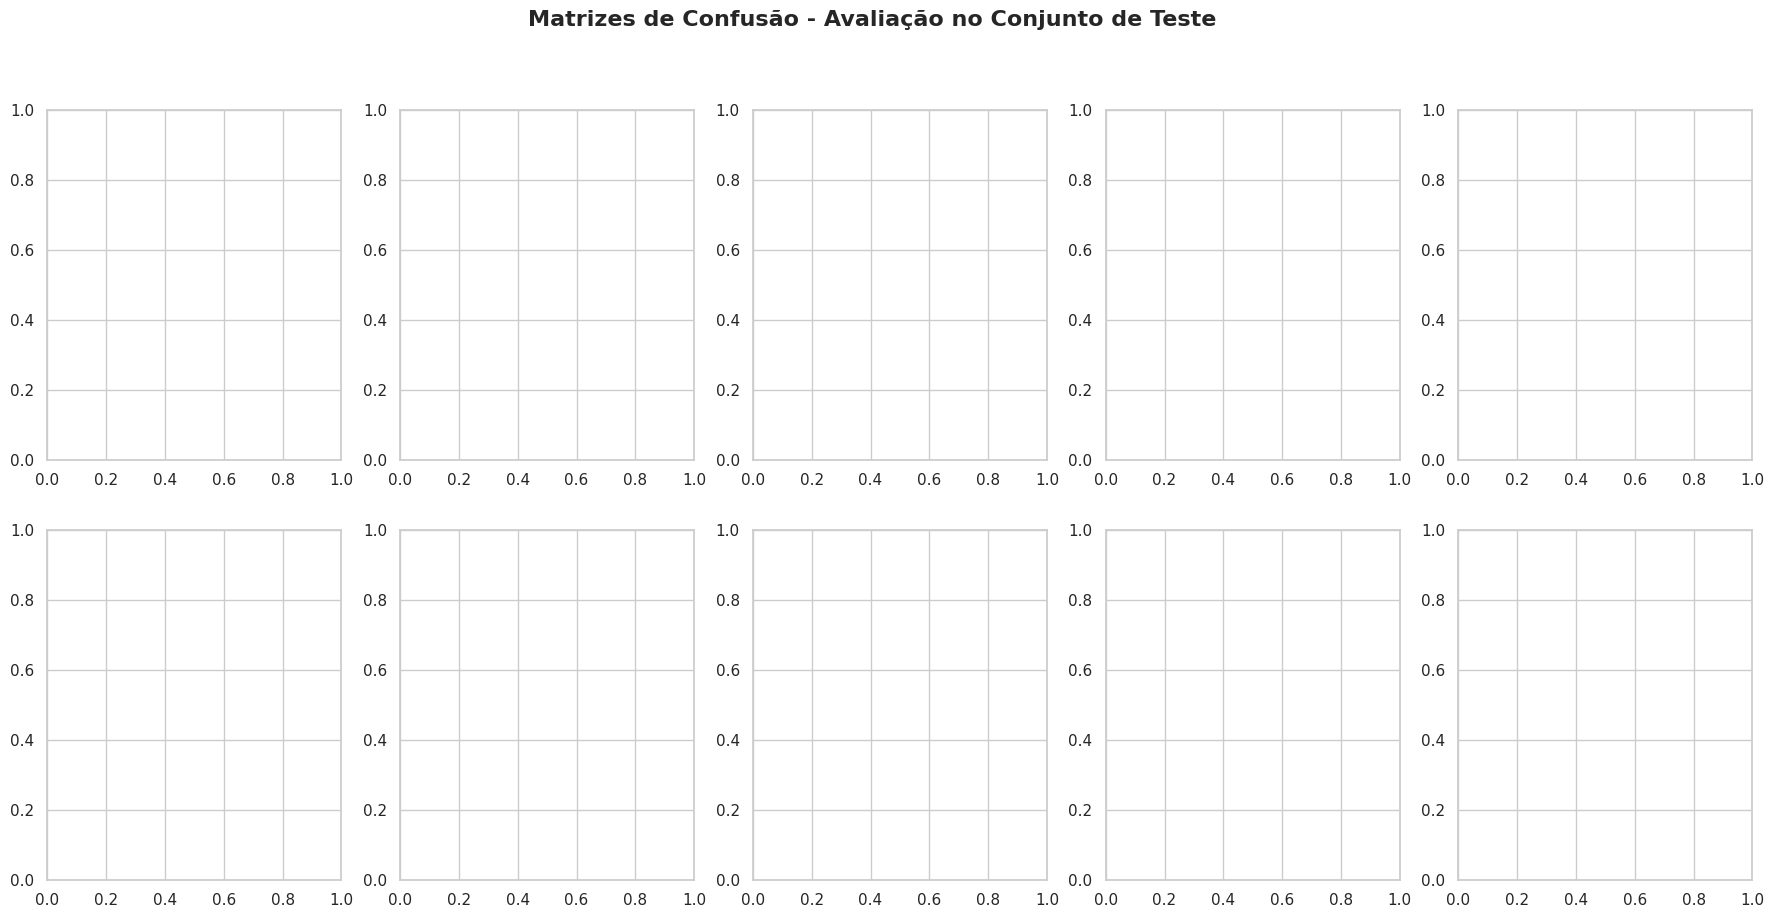

In [18]:
# ===== VISUALIZAÇÃO DAS MATRIZES DE CONFUSÃO =====

print("\n" + "="*70)
print("ANÁLISE DAS MATRIZES DE CONFUSÃO - TODOS OS MODELOS")
print("="*70)

# Configurar figura para matrizes de confusão
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
fig.suptitle('Matrizes de Confusão - Avaliação no Conjunto de Teste', fontsize=16, fontweight='bold')

# Labels para as classes
class_names = ['Não-Diabetes', 'Diabetes']

print(f"\nDETALHES DAS MATRIZES DE CONFUSÃO:")
print("-"*80)
print(f"{'Modelo':<18} {'VN':<4} {'FP':<4} {'FN':<4} {'VP':<4} {'Sens.':<6} {'Espec.':<7} {'AUC':<7}")
print("-"*80)

for idx, (name, scores) in enumerate(model_scores.items()):
    row = idx // 5
    col = idx % 5

    # Obter matriz de confusão
    cm = confusion_matrix(y_test, scores['y_test_pred'])
    tn, fp, fn, tp = cm.ravel()

    # Calcular métricas
    sensibilidade = tp / (tp + fn) if (tp + fn) > 0 else 0
    especificidade = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Plotar matriz de confusão
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={'size': 12})

    # Configurar título e labels
    axes[row, col].set_title(f'{name}\nAUC: {scores["test_auc_score"]:.3f}', fontsize=10, fontweight='bold')
    axes[row, col].set_xlabel('Predito', fontsize=9)
    axes[row, col].set_ylabel('Real', fontsize=9)

    # Exibir detalhes numericos
    print(f"{name:<18} {tn:<4} {fp:<4} {fn:<4} {tp:<4} {sensibilidade:<6.3f} {especificidade:<7.3f} {scores['test_auc_score']:<7.3f}")

print("-"*80)
print(f"\nLEGENDA:")
print(f"VN = Verdadeiros Negativos (não-diabetes corretamente identificados)")
print(f"FP = Falsos Positivos (não-diabetes incorretamente como diabetes)")
print(f"FN = Falsos Negativos (diabetes incorretamente como não-diabetes)")
print(f"VP = Verdadeiros Positivos (diabetes corretamente identificados)")
print(f"Sens. = Sensibilidade (VP / (VP + FN)) - % diabetes detectados")
print(f"Espec. = Especificidade (VN / (VN + FP)) - % não-diabetes identificados")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print(f"\nMatrizes de confusão geradas com sucesso!")


In [19]:
# ===== ANÁLISE DAS CURVAS ROC ORGANIZADAS POR PERFORMANCE =====

print("\n" + "="*70)
print("ANÁLISE DAS CURVAS ROC - ORGANIZADAS POR PERFORMANCE")
print("="*70)

# Plotar curvas ROC para dados de teste organizadas por AUC
plt.figure(figsize=(12, 8))

# Ordenar modelos por AUC de teste (do melhor para o pior)
model_scores_sorted = sorted(model_scores.items(), key=lambda x: x[1]['test_auc_score'], reverse=True)

# Cores originais para os modelos
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print(f"\nRanking de Performance (AUC no Teste):")
print("-" * 50)

for idx, (name, scores) in enumerate(model_scores_sorted):
    fpr, tpr, _ = roc_curve(y_test, scores['y_test_proba'])
    plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2.5, 
             label=f'{idx+1}. {name} (AUC = {scores["test_auc_score"]:.3f})')
    
    print(f"{idx+1:2d}. {name:<18} AUC = {scores['test_auc_score']:.4f}")

# Linha do classificador aleatório
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.7, label='Classificador Aleatório (AUC = 0.500)')

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)', fontsize=12)
plt.title('Curvas ROC - Ranking de Performance (Melhor → Pior)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparar AUC de validação vs teste (organizados por performance)
val_scores_sorted = [scores['val_auc_score'] for name, scores in model_scores_sorted]
test_scores_sorted = [scores['test_auc_score'] for name, scores in model_scores_sorted]
model_names_sorted = [name for name, scores in model_scores_sorted]

# Criar dataframe ordenado
scores_df_sorted = pd.DataFrame({
    'Ranking': range(1, len(model_names_sorted) + 1),
    'Modelo': model_names_sorted,
    'AUC Validação': val_scores_sorted,
    'AUC Teste': test_scores_sorted,
    'Diferença': [val - test for val, test in zip(val_scores_sorted, test_scores_sorted)]
})

# Plotar comparação ordenada
plt.figure(figsize=(14, 8))
bar_width = 0.35
indices = np.arange(len(model_names_sorted))

bars1 = plt.bar(indices, val_scores_sorted, bar_width, label='Validação', 
                alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = plt.bar(indices + bar_width, test_scores_sorted, bar_width, label='Teste', 
                alpha=0.8, edgecolor='black', linewidth=0.5)

# Adicionar valores nas barras
for i, (val, test) in enumerate(zip(val_scores_sorted, test_scores_sorted)):
    plt.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    plt.text(i + bar_width, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.xlabel('Modelos (Ordenados por Performance no Teste)', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Comparação Validação vs Teste - Ranking de Performance', fontsize=14, fontweight='bold')
plt.xticks(indices + bar_width/2, [f'{i+1}. {name}' for i, name in enumerate(model_names_sorted)], 
           rotation=45, ha='right')
plt.ylim([0.65, 0.95])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Linhas de referência
plt.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='Bom (0.8)')
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Excelente (0.9)')

plt.tight_layout()
plt.show()

# Exibir tabela ordenada de scores
print(f"\nTABELA COMPARATIVA ORDENADA POR PERFORMANCE:")
print("=" * 80)
print(f"{'Rank':<4} {'Modelo':<18} {'AUC Val':<8} {'AUC Test':<9} {'Diferença':<10}")
print("=" * 80)

for _, row in scores_df_sorted.iterrows():
    print(f"{row['Ranking']:<4} {row['Modelo']:<18} {row['AUC Validação']:<8.4f} {row['AUC Teste']:<9.4f} {row['Diferença']:<10.4f}")

print("=" * 80)

# Destacar top 3
print(f"\n🏆 TOP 3 MODELOS:")
for i in range(3):
    row = scores_df_sorted.iloc[i]
    print(f"{row['Ranking']}º lugar: {row['Modelo']} (AUC = {row['AUC Teste']:.4f})")

print(f"\n✅ Curvas ROC organizadas por performance!")


ANÁLISE DAS CURVAS ROC - ORGANIZADAS POR PERFORMANCE


NameError: name 'model_scores' is not defined

<Figure size 1200x800 with 0 Axes>

In [20]:
# Ranking dos modelos por AUC de validação e teste (necessário para os gráficos)
ranking_val = sorted(model_scores.items(), key=lambda x: x[1]['val_auc_score'], reverse=True)
ranking_test = sorted(model_scores.items(), key=lambda x: x[1]['test_auc_score'], reverse=True)

# Selecionar melhor modelo com base na validação, não no teste
best_model_name = ranking_val[0][0]
best_model = trained_models[best_model_name]

# Calcular métricas detalhadas para todos os modelos (incluindo validação cruzada)
detailed_metrics = {}
for name, scores in model_scores.items():
    y_pred = scores['y_test_pred']
    
    # Calcular matriz de confusão para obter especificidade
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Calcular métricas básicas
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = scores['test_auc_score']
    
    # Calcular validação cruzada
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_scores = cross_val_score(trained_models[name], X_train_scaled, y_train_balanced, 
                                      cv=5, scoring='roc_auc')
        cv_mean = cv_scores.mean()
    except:
        cv_mean = 0.0
    
    detailed_metrics[name] = {
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'AUC': auc,
        'Specificity': specificity,
        'CV-5': cv_mean  # NOVA MÉTRICA ADICIONADA
    }

# Criar DataFrame para os gráficos com 3 casas decimais
metrics_df = pd.DataFrame(detailed_metrics).T
metrics_df = metrics_df.round(3)  # MUDANÇA: 4 → 3 casas decimais

# Plots de métricas - ATUALIZADO para 4x2 (8 gráficos) incluindo CV-5
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('Análise Completa de Performance - Todos os Modelos', fontsize=16, fontweight='bold')

# 1. F1-Score
f1_sorted = metrics_df.sort_values('F1-Score', ascending=True)
axes[0,0].barh(range(len(f1_sorted)), f1_sorted['F1-Score'], color='skyblue')
axes[0,0].set_yticks(range(len(f1_sorted)))
axes[0,0].set_yticklabels(f1_sorted.index, fontsize=10)
axes[0,0].set_xlabel('F1-Score (Pontuação F1)')
axes[0,0].set_title('F1-Score (Pontuação F1) - Equilíbrio Geral')
axes[0,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(f1_sorted['F1-Score']):
    axes[0,0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 2. Recall (Sensibilidade)
recall_sorted = metrics_df.sort_values('Recall', ascending=True)
axes[0,1].barh(range(len(recall_sorted)), recall_sorted['Recall'], color='lightgreen')
axes[0,1].set_yticks(range(len(recall_sorted)))
axes[0,1].set_yticklabels(recall_sorted.index, fontsize=10)
axes[0,1].set_xlabel('Recall (Sensibilidade)')
axes[0,1].set_title('Recall (Sensibilidade) - Detecção de Diabetes')
axes[0,1].grid(axis='x', alpha=0.3)
for i, v in enumerate(recall_sorted['Recall']):
    axes[0,1].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 3. Precision
precision_sorted = metrics_df.sort_values('Precision', ascending=True)
axes[1,0].barh(range(len(precision_sorted)), precision_sorted['Precision'], color='lightcoral')
axes[1,0].set_yticks(range(len(precision_sorted)))
axes[1,0].set_yticklabels(precision_sorted.index, fontsize=10)
axes[1,0].set_xlabel('Precision (Precisão)')
axes[1,0].set_title('Precision (Precisão) - Confiabilidade das Predições')
axes[1,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(precision_sorted['Precision']):
    axes[1,0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 4. Specificity
specificity_sorted = metrics_df.sort_values('Specificity', ascending=True)
axes[1,1].barh(range(len(specificity_sorted)), specificity_sorted['Specificity'], color='lightpink')
axes[1,1].set_yticks(range(len(specificity_sorted)))
axes[1,1].set_yticklabels(specificity_sorted.index, fontsize=10)
axes[1,1].set_xlabel('Specificity (Especificidade)')
axes[1,1].set_title('Specificity (Especificidade) - Identificação de Não-Diabéticos')
axes[1,1].grid(axis='x', alpha=0.3)
for i, v in enumerate(specificity_sorted['Specificity']):
    axes[1,1].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 5. Accuracy
accuracy_sorted = metrics_df.sort_values('Accuracy', ascending=True)
axes[2,0].barh(range(len(accuracy_sorted)), accuracy_sorted['Accuracy'], color='gold')
axes[2,0].set_yticks(range(len(accuracy_sorted)))
axes[2,0].set_yticklabels(accuracy_sorted.index, fontsize=10)
axes[2,0].set_xlabel('Accuracy (Acurácia)')
axes[2,0].set_title('Accuracy (Acurácia) - Acertos Totais')
axes[2,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracy_sorted['Accuracy']):
    axes[2,0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 6. AUC
auc_sorted = metrics_df.sort_values('AUC', ascending=True)
axes[2,1].barh(range(len(auc_sorted)), auc_sorted['AUC'], color='mediumpurple')
axes[2,1].set_yticks(range(len(auc_sorted)))
axes[2,1].set_yticklabels(auc_sorted.index, fontsize=10)
axes[2,1].set_xlabel('AUC Score (Pontuação AUC)')
axes[2,1].set_title('AUC (Área Sob a Curva) - Capacidade de Discriminação')
axes[2,1].grid(axis='x', alpha=0.3)
for i, v in enumerate(auc_sorted['AUC']):
    axes[2,1].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 7. CV-5 (NOVO GRÁFICO)
cv_sorted = metrics_df.sort_values('CV-5', ascending=True)
axes[3,0].barh(range(len(cv_sorted)), cv_sorted['CV-5'], color='lightseagreen')
axes[3,0].set_yticks(range(len(cv_sorted)))
axes[3,0].set_yticklabels(cv_sorted.index, fontsize=10)
axes[3,0].set_xlabel('CV-5 AUC Score')
axes[3,0].set_title('Validação Cruzada 5-Fold - Robustez do Modelo')
axes[3,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(cv_sorted['CV-5']):
    axes[3,0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 8. Comparação AUC vs CV-5 (NOVO GRÁFICO)
axes[3,1].scatter(metrics_df['AUC'], metrics_df['CV-5'], s=100, alpha=0.7, 
                  c=range(len(metrics_df)), cmap='viridis', edgecolors='black')

# Adicionar linha diagonal para referência
min_val = min(metrics_df['AUC'].min(), metrics_df['CV-5'].min())
max_val = max(metrics_df['AUC'].max(), metrics_df['CV-5'].max())
axes[3,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2)

# Adicionar rótulos dos modelos
for i, (model, row) in enumerate(metrics_df.iterrows()):
    axes[3,1].annotate(model, (row['AUC'], row['CV-5']), 
                       xytext=(5, 5), textcoords='offset points', 
                       fontsize=8, alpha=0.8)

axes[3,1].set_xlabel('AUC Teste')
axes[3,1].set_ylabel('CV-5 AUC')
axes[3,1].set_title('Correlação: AUC Teste vs Validação Cruzada')
axes[3,1].grid(True, alpha=0.3)
axes[3,1].set_xlim(min_val-0.01, max_val+0.01)
axes[3,1].set_ylim(min_val-0.01, max_val+0.01)

plt.tight_layout()
plt.show()

# Criar um segundo gráfico com o heatmap ampliado para melhor visualização
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5, 
           ax=ax, cbar_kws={'label': 'Score'}, annot_kws={'size': 11})
ax.set_title('Heatmap Completo - Todas as Métricas de Performance (incluindo CV-5)', fontsize=14, fontweight='bold')
ax.set_xlabel('Métricas de Avaliação', fontsize=12)
ax.set_ylabel('Modelos de Machine Learning', fontsize=12)

# Rotacionar labels para melhor visualização
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Exibir ranking detalhado por métrica (ATUALIZADO com CV-5)
print("\n" + "="*80)
print("📊 RANKING DETALHADO POR MÉTRICA")
print("="*80)

metrics_names = {
    'F1-Score': 'F1-Score (Pontuação F1)',
    'Precision': 'Precision (Precisão)', 
    'Recall': 'Recall (Sensibilidade)',
    'Specificity': 'Specificity (Especificidade)',
    'Accuracy': 'Accuracy (Acurácia)',
    'AUC': 'AUC (Área Sob a Curva)',
    'CV-5': 'Validação Cruzada 5-Fold'  # NOVA MÉTRICA
}

for metric, description in metrics_names.items():
    print(f"\n🏆 TOP 3 - {description}:")
    top3 = metrics_df.sort_values(metric, ascending=False).head(3)
    for i, (model, row) in enumerate(top3.iterrows(), 1):
        print(f"  {i}º lugar: {model:<18} ({row[metric]:.3f})")

# Criar tabela comparativa final (ATUALIZADA com CV-5 e 3 casas decimais)
print(f"\n📋 TABELA COMPARATIVA FINAL - TODAS AS MÉTRICAS:")
print("="*125)
header = f"{'Modelo':<18} {'F1-Score':<9} {'Precision':<10} {'Recall':<8} {'Specific.':<10} {'Accuracy':<9} {'AUC':<8} {'CV-5':<8}"
print(header)
print("="*125)

# Ordenar por CV-5 (melhor métrica para robustez)
for model, row in metrics_df.sort_values('CV-5', ascending=False).iterrows():
    print(f"{model:<18} {row['F1-Score']:<9.3f} {row['Precision']:<10.3f} {row['Recall']:<8.3f} "
          f"{row['Specificity']:<10.3f} {row['Accuracy']:<9.3f} {row['AUC']:<8.3f} {row['CV-5']:<8.3f}")

print("="*125)

# Análise de correlação entre métricas
print(f"\n📊 ANÁLISE DE CORRELAÇÃO ENTRE MÉTRICAS:")
correlations = metrics_df.corr()
print(f"Correlação AUC vs CV-5: {correlations.loc['AUC', 'CV-5']:.3f}")
print(f"Correlação F1-Score vs CV-5: {correlations.loc['F1-Score', 'CV-5']:.3f}")
print(f"Correlação Recall vs CV-5: {correlations.loc['Recall', 'CV-5']:.3f}")

# Identificar modelos com maior consistência (menor diferença entre AUC e CV-5)
print(f"\n🎯 ANÁLISE DE CONSISTÊNCIA (AUC vs CV-5):")
metrics_df['Diferenca_AUC_CV'] = abs(metrics_df['AUC'] - metrics_df['CV-5'])
consistency_ranking = metrics_df.sort_values('Diferenca_AUC_CV')

print(f"{'Modelo':<18} {'AUC':<8} {'CV-5':<8} {'Diferença':<10} {'Consistência':<15}")
print("-" * 70)
for model, row in consistency_ranking.iterrows():
    diff = row['Diferenca_AUC_CV']
    if diff < 0.01:
        status = "Excelente"
    elif diff < 0.02:
        status = "Boa"
    elif diff < 0.03:
        status = "Moderada"
    else:
        status = "Baixa"
    
    print(f"{model:<18} {row['AUC']:<8.3f} {row['CV-5']:<8.3f} {diff:<10.3f} {status:<15}")

# Salvar scaler e informações adicionais
joblib.dump(scaler, 'todos-modelos/scaler.pkl')
joblib.dump(feature_columns, 'todos-modelos/feature_columns.pkl')
joblib.dump(model_scores, 'todos-modelos/model_results.pkl')
joblib.dump(metrics_df, 'todos-modelos/detailed_metrics.pkl')

print(f"\n✅ Análise completa de performance concluída!")
print(f"💾 Dados salvos com {len(metrics_df.columns)} métricas para {len(metrics_df)} modelos")
print(f"🎯 Melhor modelo por CV-5: {metrics_df.sort_values('CV-5', ascending=False).index[0]}")
print(f"🎯 Melhor modelo por AUC: {metrics_df.sort_values('AUC', ascending=False).index[0]}")

# Exibir informações dos arquivos salvos
print(f"\n📁 ARQUIVOS SALVOS NO DIRETÓRIO 'todos-modelos/':")
print(f"• scaler.pkl - StandardScaler treinado nos dados")
print(f"• feature_columns.pkl - Lista das features utilizadas")
print(f"• model_results.pkl - Resultados completos de todos os modelos")
print(f"• detailed_metrics.pkl - DataFrame com {len(metrics_df.columns)} métricas calculadas")
print(f"• best_model_final.pkl - Melhor modelo ({best_model_name})")
print(f"• [modelo]_model.pkl - Cada modelo individual treinado")

NameError: name 'model_scores' is not defined

In [21]:
# ===== FUNÇÕES DE PREDIÇÃO FINAIS =====
def predict_with_best_model(new_data):
    """
    Função para fazer predição com o melhor modelo (selecionado por validação)
    Parâmetro: new_data - DataFrame com as features na mesma ordem do treinamento
    """
    # Normalizar os dados
    new_data_scaled = scaler.transform(new_data)
    
    # Fazer predição com o melhor modelo
    prediction = best_model.predict(new_data_scaled)
    probability = best_model.predict_proba(new_data_scaled)
    
    return prediction, probability, best_model_name

def predict_with_custom_params(new_data, model_name, custom_params=None):
    """
    Função para treinar e usar modelo com parâmetros personalizados
    """
    if custom_params:
        # Atualizar parâmetros
        model_params[model_name].update(custom_params)
        print(f"Parâmetros atualizados para {model_name}: {model_params[model_name]}")
        
        # Retreinar modelo com novos parâmetros
        if model_name == 'Random Forest':
            model = RandomForestClassifier(**model_params[model_name])
        elif model_name == 'XGBoost':
            model = XGBClassifier(**model_params[model_name])
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingClassifier(**model_params[model_name])
        elif model_name == 'LightGBM':
            model = LGBMClassifier(**model_params[model_name], verbose=-1)
        elif model_name == 'Decision Tree':
            model = DecisionTreeClassifier(**model_params[model_name])
        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier(**model_params[model_name])
        elif model_name == 'SVM':
            model = SVC(**model_params[model_name], probability=True)
        elif model_name == 'Logistic Regression':
            model = LogisticRegression(**model_params[model_name])
        elif model_name == 'kNN':
            model = KNeighborsClassifier(**model_params[model_name])
        elif model_name == 'Naive Bayes':
            model = GaussianNB(**model_params[model_name])
        else:
            raise ValueError(f"Modelo {model_name} não reconhecido")
        
        # Treinar com os dados atuais
        model.fit(X_train_scaled, y_train_balanced)
        
        # Avaliar performance
        val_pred = model.predict(X_val_scaled)
        val_proba = model.predict_proba(X_val_scaled)[:, 1]
        val_auc = roc_auc_score(y_val, val_proba)
        
        test_pred = model.predict(X_test_scaled)
        test_proba = model.predict_proba(X_test_scaled)[:, 1]
        test_auc = roc_auc_score(y_test, test_proba)
        
        print(f"Performance do modelo personalizado:")
        print(f"  AUC Validação: {val_auc:.4f}")
        print(f"  AUC Teste: {test_auc:.4f}")
        
        # Fazer predição
        new_data_scaled = scaler.transform(new_data)
        prediction = model.predict(new_data_scaled)
        probability = model.predict_proba(new_data_scaled)
        
        return prediction, probability, model_name, val_auc, test_auc
    else:
        return predict_with_best_model(new_data)

print("✅ Funções de predição criadas!")
print("\nFunções disponíveis:")
print("1. predict_with_best_model(new_data) - Usa o melhor modelo")
print("2. predict_with_custom_params(new_data, model_name, params) - Permite personalizar parâmetros")

# Salvar modelo final
joblib.dump(best_model, 'todos-modelos/best_model_final.pkl')
joblib.dump(scaler, 'todos-modelos/scaler_final.pkl')
print(f"\n💾 Melhor modelo ({best_model_name}) e scaler salvos!")

✅ Funções de predição criadas!

Funções disponíveis:
1. predict_with_best_model(new_data) - Usa o melhor modelo
2. predict_with_custom_params(new_data, model_name, params) - Permite personalizar parâmetros

💾 Melhor modelo (Logistic Regression) e scaler salvos!


### 🎯 **Otimização de Threshold e Trade-off entre Sensibilidade e Especificidade**

#### **⚖️ Por que o Threshold Padrão (0.5) nem sempre é ideal?**

Em problemas de saúde como a detecção de diabetes, diferentes contextos clínicos exigem diferentes balanceamentos entre sensibilidade (capacidade de detectar doentes) e especificidade (capacidade de identificar não-doentes):

- **Alta sensibilidade**: Prioriza encontrar todos os casos de diabetes, mesmo que haja mais falsos positivos
- **Alta especificidade**: Prioriza a certeza do diagnóstico, mas pode perder alguns casos

#### **🏥 Contextos Clínicos e Thresholds Recomendados**

1. **Triagem populacional**: Threshold mais baixo (0.30-0.40) → maximiza detecção
2. **Diagnóstico clínico**: Threshold médio (0.45-0.55) → equilíbrio
3. **Pesquisa científica**: Threshold mais alto (0.60-0.70) → minimiza falsos positivos

#### **📊 Análise de Diferentes Thresholds P/ Otimização**

A tabela abaixo apresenta as métricas obtidas com diferentes valores de threshold para o melhor modelo:


ANÁLISE DE THRESHOLD - RANDOM FOREST, GRADIENT BOOSTING E ADABOOST
MÉTODOS: SMOTE E REPONDERAÇÃO
✅ Usando results_by_method (SMOTE e Reponderação): 4 modelos encontrados

🎯 Analisando 4 modelos target (SMOTE e Reponderação):

ANÁLISE DO MODELO: Random Forest (SMOTE)

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Random Forest (SMOTE):
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     1.000   0.370   0.462   0.632   1.000   54   63   37   0  
   0.20     0.944   0.560   0.537   0.685   0.949   51   44   56   3  
   0.30     0.889   0.650   0.578   0.701   0.915   48   35   65   6  
   0.40     0.796   0.720   0.606   0.688   0.867   43   28   72   11 
   0.50     0.667   0.800   0.643   0.655   0.816   36   20   80   18 
   0.60     0.574   0.850   0.674   0.620   0.787   31   15   85   23 
   0.70     0.481   0.880   0.684   0.565   

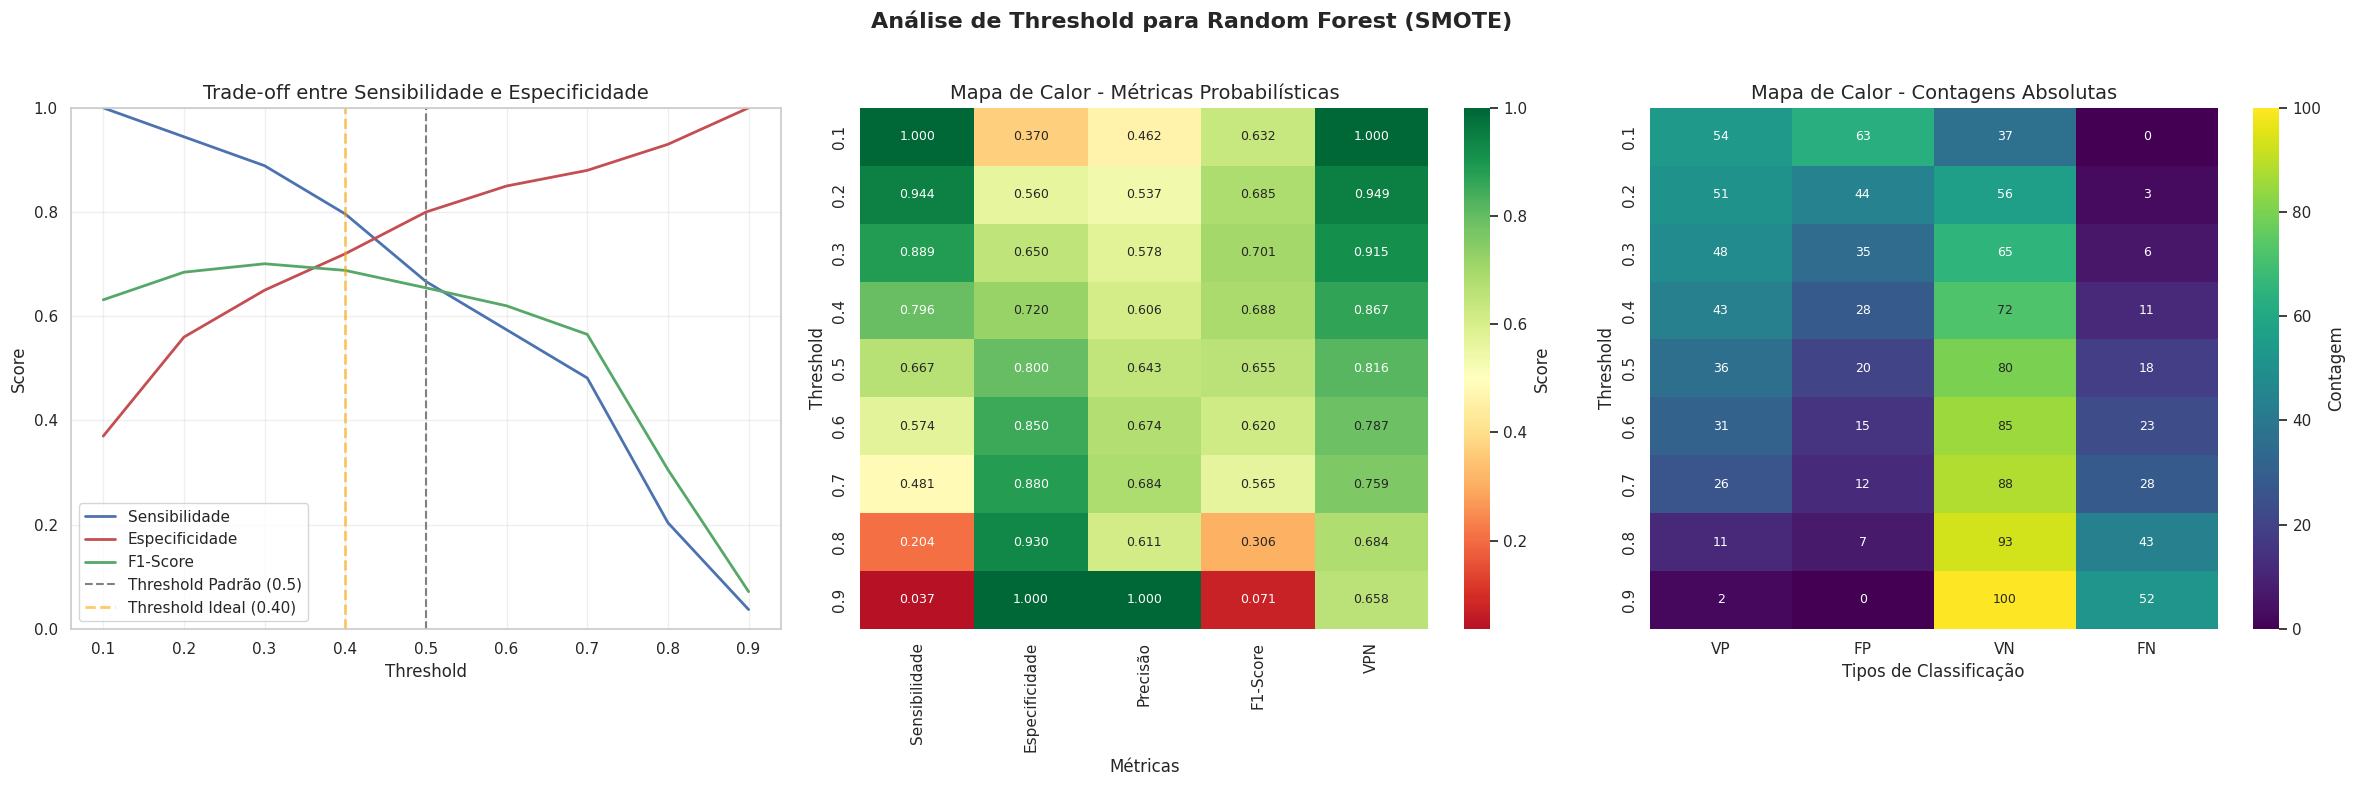


ANÁLISE DO MODELO: Gradient Boosting (SMOTE)

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Gradient Boosting (SMOTE):
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     0.944   0.520   0.515   0.667   0.945   51   48   52   3  
   0.20     0.926   0.590   0.549   0.690   0.937   50   41   59   4  
   0.30     0.815   0.680   0.579   0.677   0.872   44   32   68   10 
   0.40     0.667   0.730   0.571   0.615   0.802   36   27   73   18 
   0.50     0.611   0.760   0.579   0.595   0.784   33   24   76   21 
   0.60     0.556   0.800   0.600   0.577   0.769   30   20   80   24 
   0.70     0.500   0.840   0.628   0.557   0.757   27   16   84   27 
   0.80     0.389   0.890   0.656   0.488   0.730   21   11   89   33 
   0.90     0.241   0.980   0.867   0.377   0.705   13   2    98   41 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (0.40) 

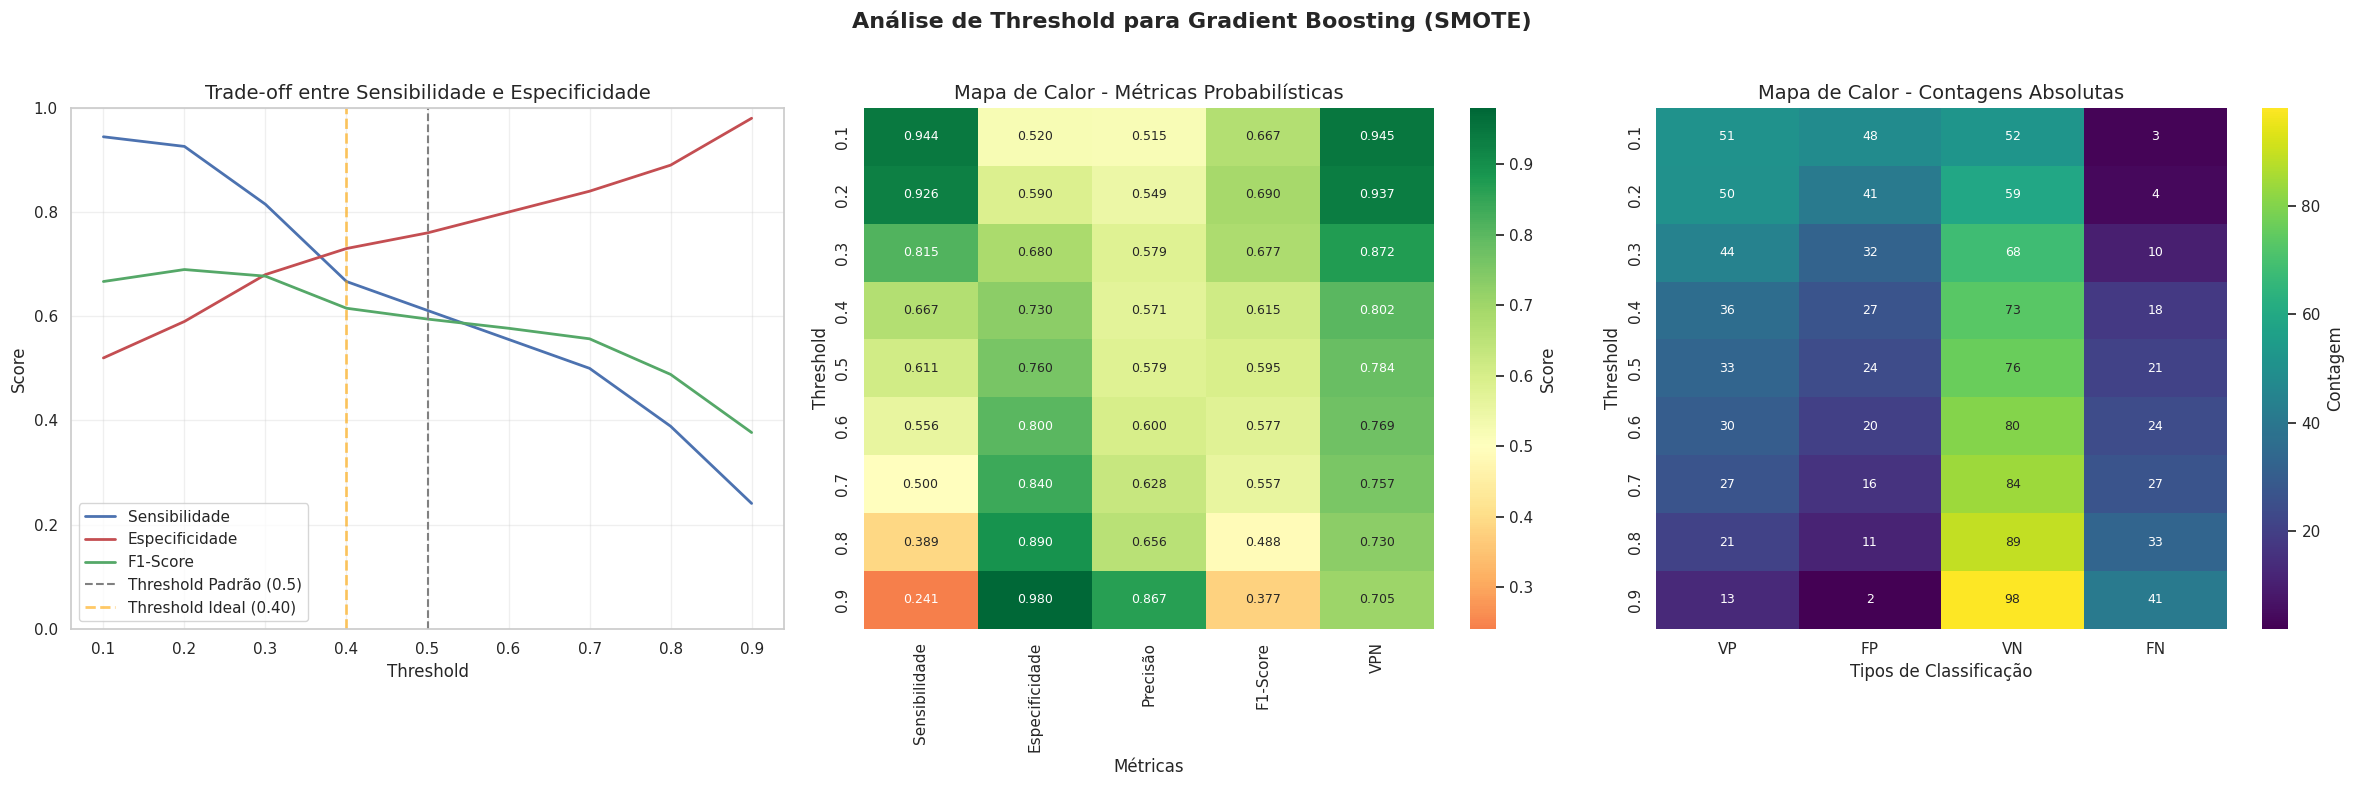


ANÁLISE DO MODELO: AdaBoost (SMOTE)

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - AdaBoost (SMOTE):
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     1.000   0.000   0.351   0.519   0.000   54  100   0    0  
   0.20     1.000   0.000   0.351   0.519   0.000   54  100   0    0  
   0.30     1.000   0.020   0.355   0.524   1.000   54   98   2    0  
   0.40     0.981   0.360   0.453   0.620   0.973   53   64   36   1  
   0.50     0.704   0.750   0.603   0.650   0.824   38   25   75   16 
   0.60     0.259   0.960   0.778   0.389   0.706   14   4    96   40 
   0.70     0.000   1.000   0.000   0.000   0.649   0    0   100   54 
   0.80     0.000   1.000   0.000   0.000   0.649   0    0   100   54 
   0.90     0.000   1.000   0.000   0.000   0.649   0    0   100   54 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (0.40) - AdaBoost (SMOTE)

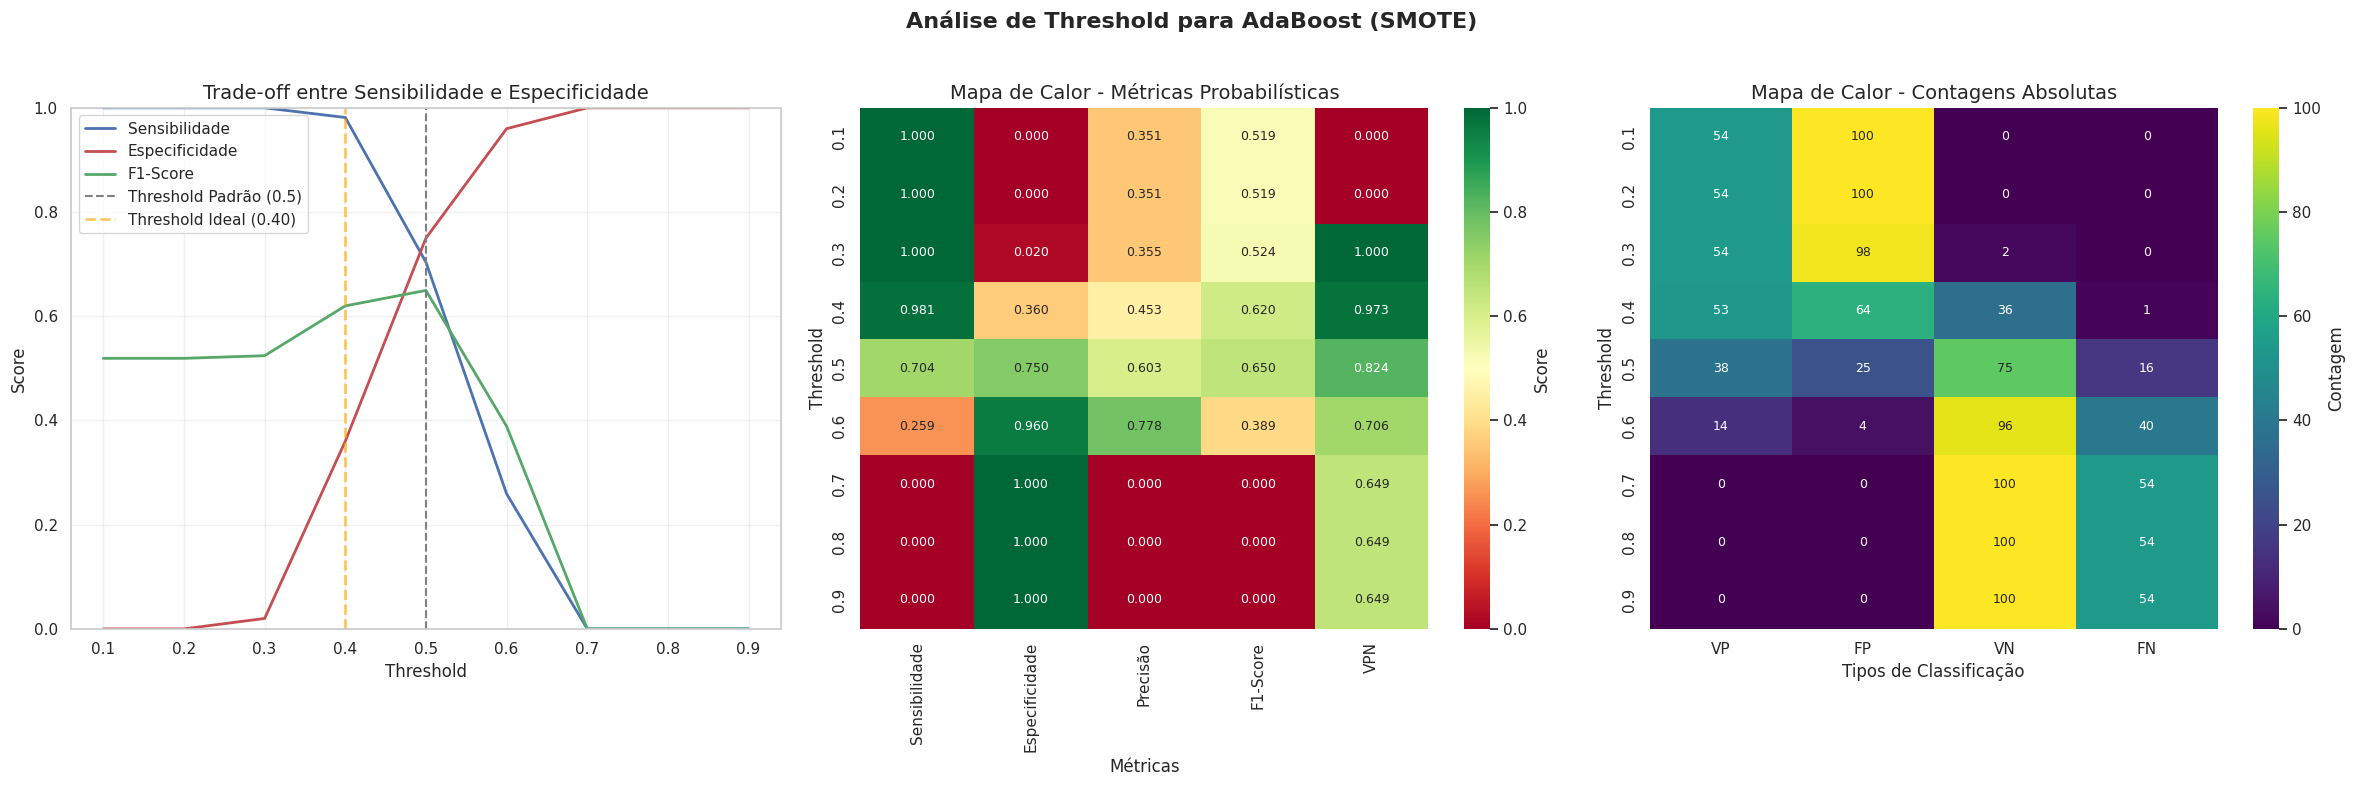


ANÁLISE DO MODELO: Random Forest (Reponderação)

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Random Forest (Reponderação):
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     0.981   0.390   0.465   0.631   0.975   53   61   39   1  
   0.20     0.944   0.600   0.560   0.703   0.952   51   40   60   3  
   0.30     0.852   0.710   0.613   0.713   0.899   46   29   71   8  
   0.40     0.685   0.760   0.607   0.643   0.817   37   24   76   17 
   0.50     0.611   0.810   0.635   0.623   0.794   33   19   81   21 
   0.60     0.537   0.870   0.690   0.604   0.777   29   13   87   25 
   0.70     0.352   0.950   0.792   0.487   0.731   19   5    95   35 
   0.80     0.148   0.990   0.889   0.254   0.683   8    1    99   46 
   0.90     0.000   1.000   0.000   0.000   0.649   0    0   100   54 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (

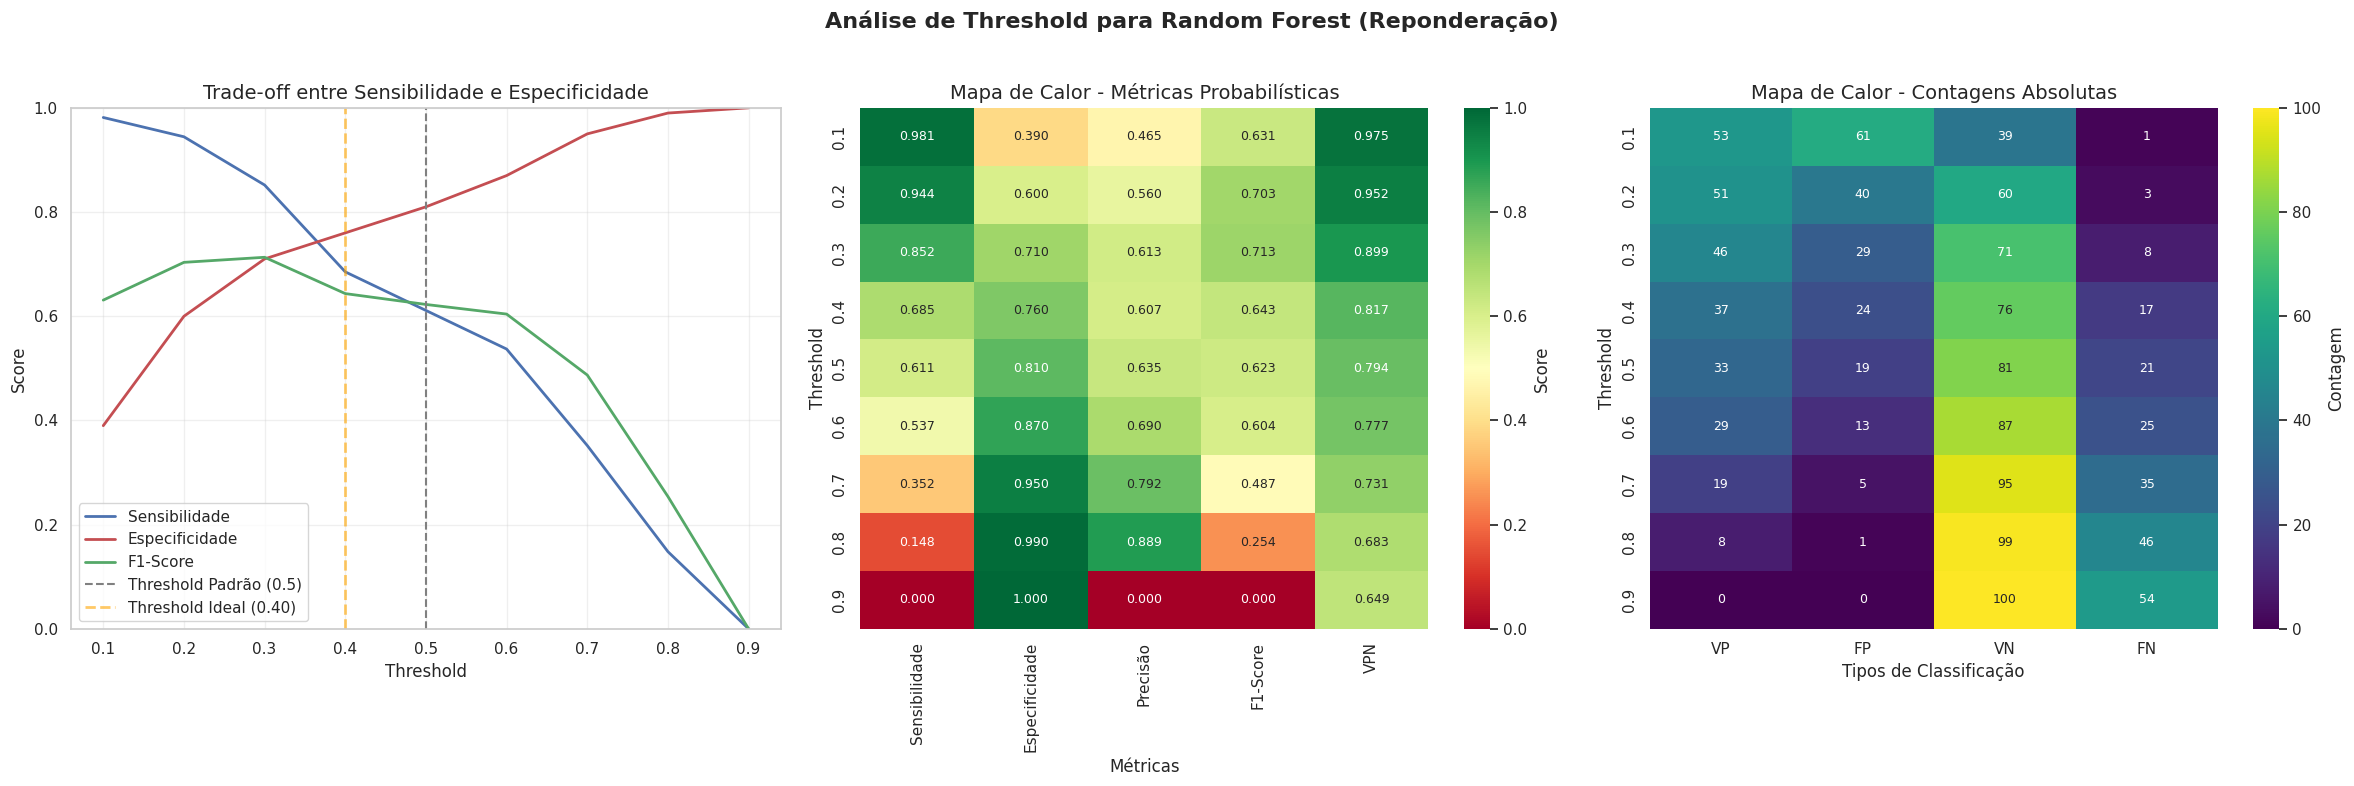


MATRIZES DE CONFUSÃO - THRESHOLD 0.4 (SMOTE E REPONDERAÇÃO)


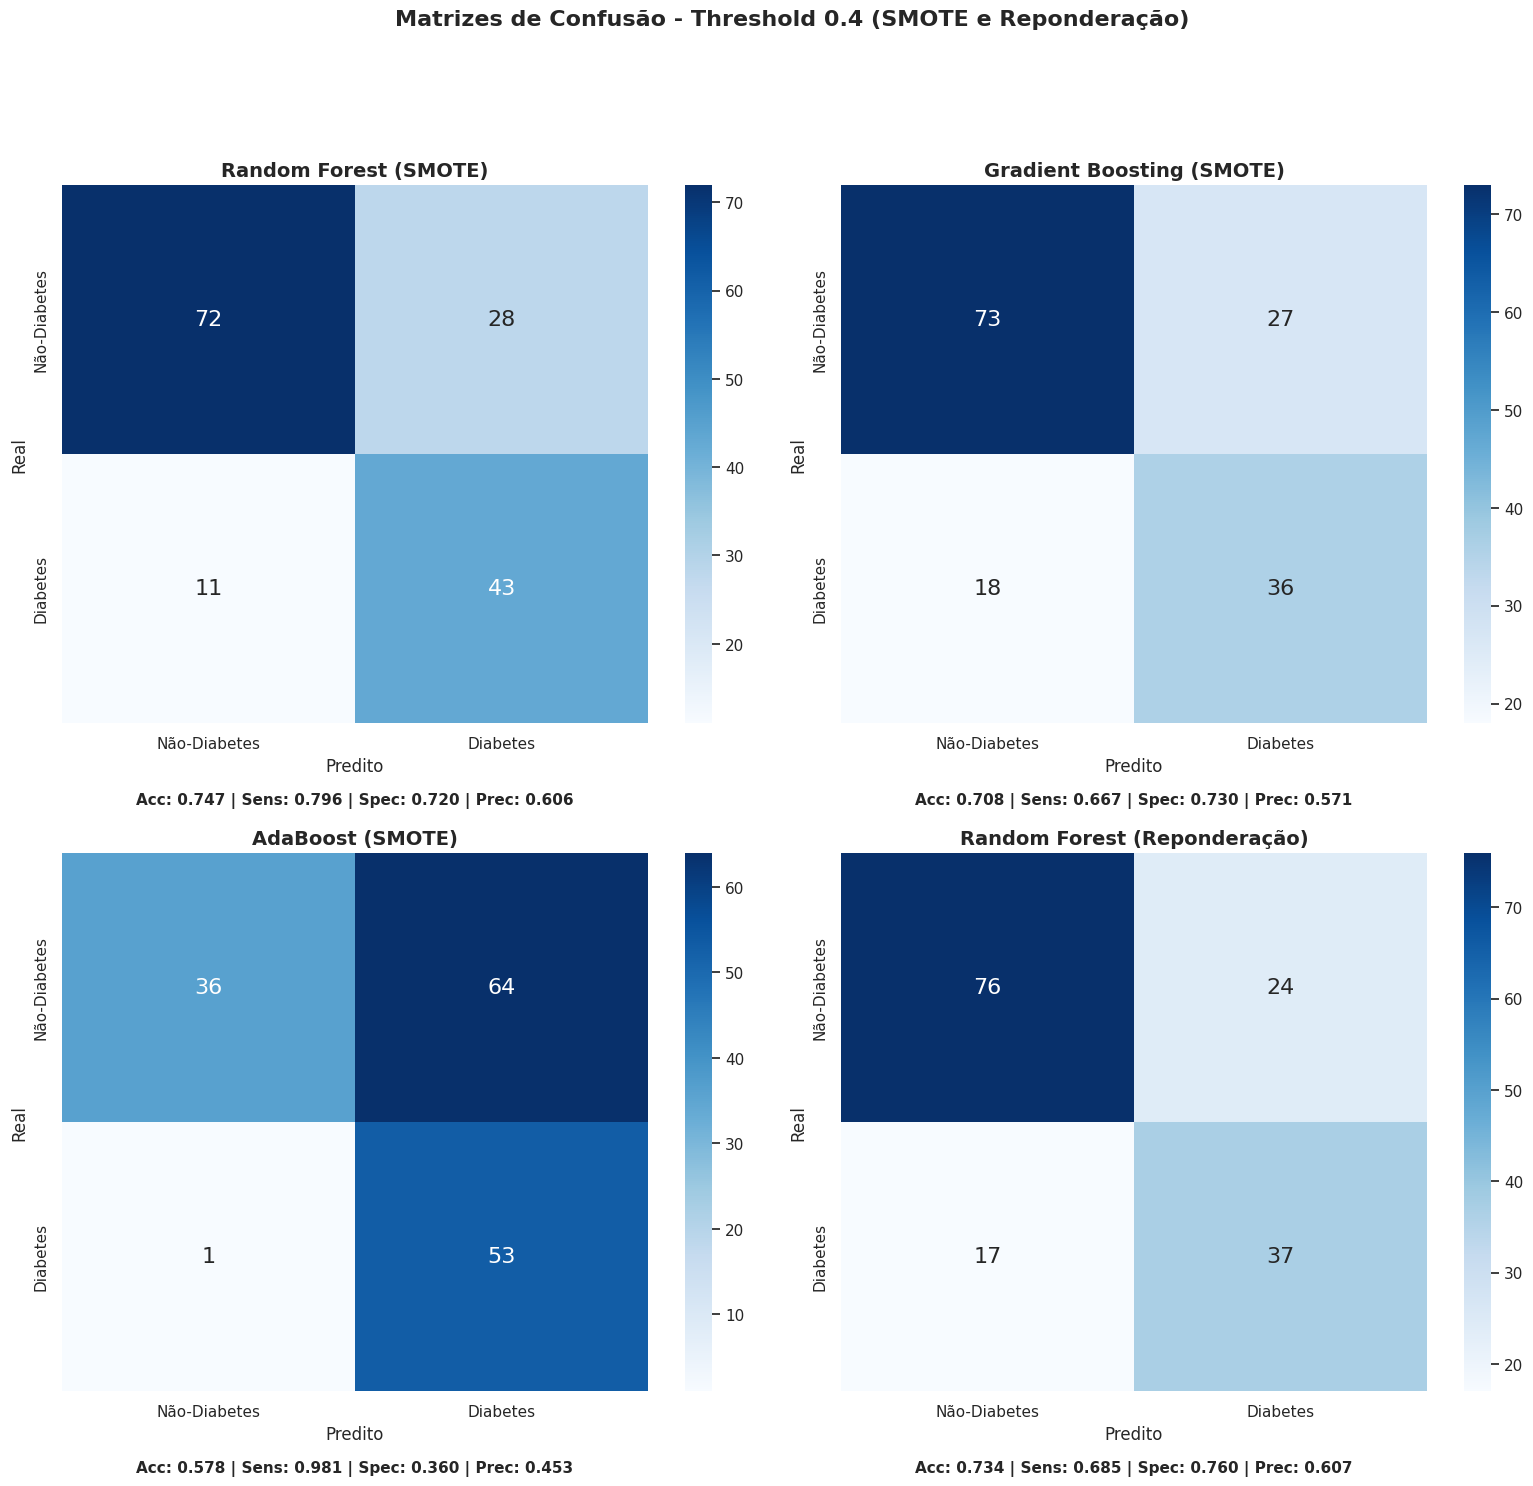


CURVA ROC COMBINADA - MODELOS SMOTE E REPONDERAÇÃO


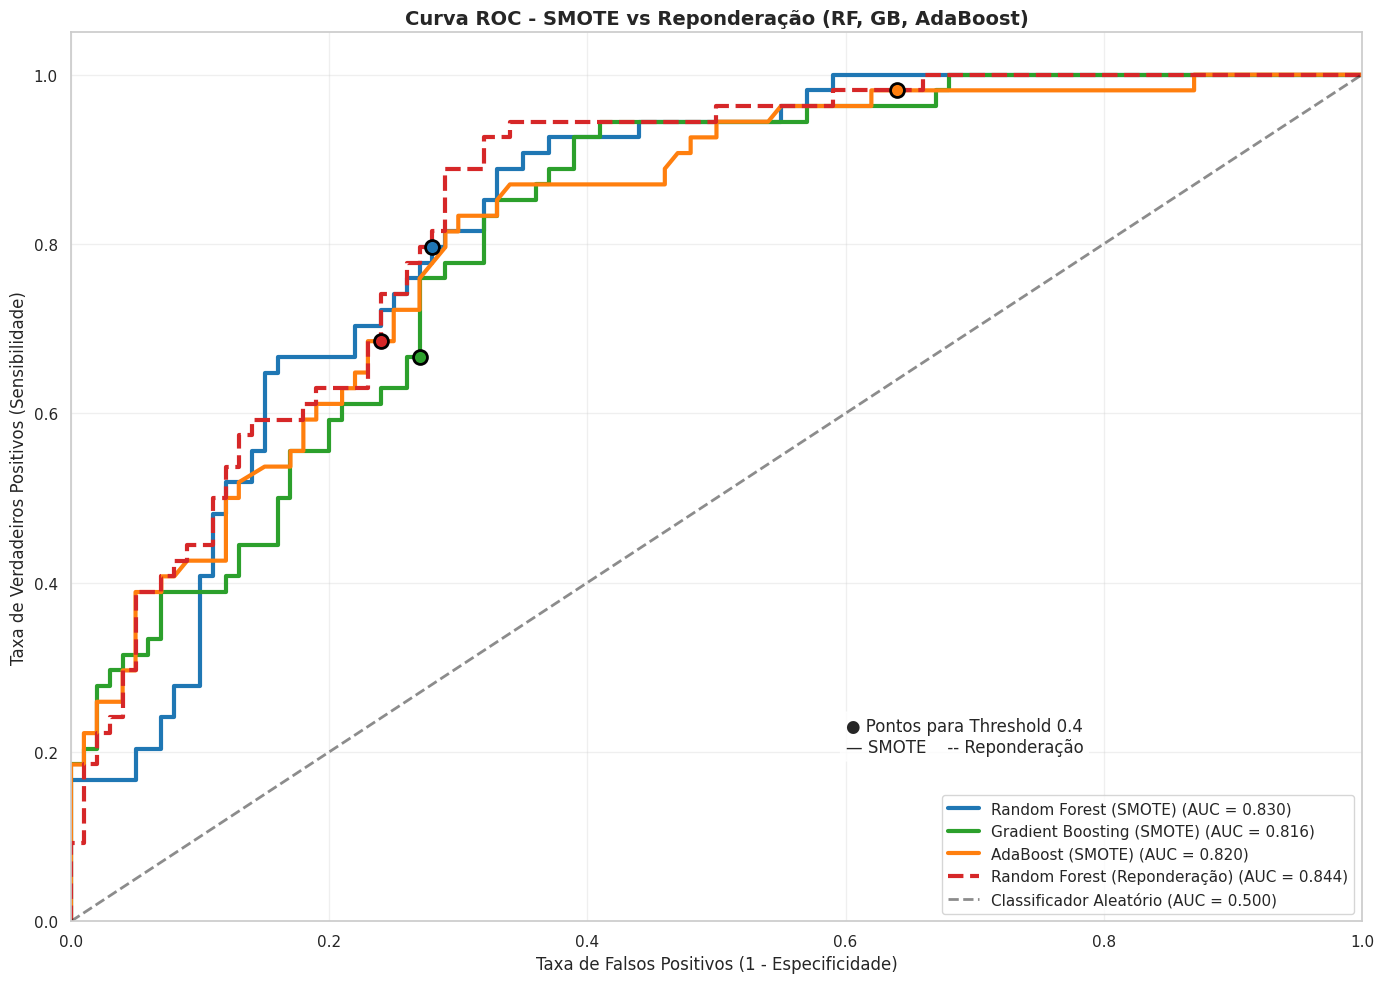


RESUMO COMPARATIVO - THRESHOLD 0.4 (SMOTE E REPONDERAÇÃO)

Modelo                              AUC    Acc    Sens   Spec   Prec   F1     VP  FP  VN  FN 
--------------------------------------------------------------------------------------------------------------
Random Forest (SMOTE)               0.830  0.747  0.796  0.720  0.606  0.688  43  28  72  11 
Gradient Boosting (SMOTE)           0.816  0.708  0.667  0.730  0.571  0.615  36  27  73  18 
AdaBoost (SMOTE)                    0.820  0.578  0.981  0.360  0.453  0.620  53  64  36  1  
Random Forest (Reponderação)        0.844  0.734  0.685  0.760  0.607  0.643  37  24  76  17 

🎯 MELHOR MODELO POR MÉTRICA (Threshold 0.4):
• Melhor AUC: Random Forest (Reponderação) (0.844)
• Melhor F1-Score: Random Forest (SMOTE) (0.688)
• Melhor Sensibilidade: AdaBoost (SMOTE) (0.981)
• Melhor Especificidade: Random Forest (Reponderação) (0.760)

📊 ANÁLISE COMPARATIVA POR MÉTODO:
------------------------------------------------------------
SMOTE 

In [27]:
# ===== FUNÇÃO PARA ANÁLISE DE THRESHOLD =====
def analyze_threshold_for_model(model_name, y_proba, y_true, thresholds):
    """
    Analisa diferentes thresholds para um modelo específico
    """
    results = []
    
    for threshold in thresholds:
        # Gerar predições com o threshold atual
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calcular matriz de confusão
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calcular métricas
        sensibilidade = tp / (tp + fn) if (tp + fn) > 0 else 0
        especificidade = tn / (tn + fp) if (tn + fp) > 0 else 0
        precisao = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score_val = 2 * (precisao * sensibilidade) / (precisao + sensibilidade) if (precisao + sensibilidade) > 0 else 0
        vpn = tn / (tn + fn) if (tn + fn) > 0 else 0  # Valor Preditivo Negativo
        
        results.append({
            'Threshold': threshold,
            'Sensibilidade': sensibilidade,
            'Especificidade': especificidade,
            'Precisão': precisao,
            'F1-Score': f1_score_val,
            'VPN': vpn,
            'VP': tp,
            'FP': fp,
            'VN': tn,
            'FN': fn
        })
    
    return pd.DataFrame(results)

# ===== ANÁLISE DE THRESHOLD PARA RANDOM FOREST, GRADIENT BOOSTING E ADABOOST (SMOTE E REPONDERAÇÃO) =====

print("\n" + "="*80)
print("ANÁLISE DE THRESHOLD - RANDOM FOREST, GRADIENT BOOSTING E ADABOOST")
print("MÉTODOS: SMOTE E REPONDERAÇÃO")
print("="*80)

# Verificar se as variáveis necessárias existem
required_vars = ['y_test']
optional_vars = ['model_scores', 'trained_models', 'results_by_method']
missing_vars = []

for var in required_vars:
    if var not in globals():
        missing_vars.append(var)

if missing_vars:
    print(f"⚠️ Variáveis essenciais ausentes: {missing_vars}")
    print("🔄 Execute primeiro o treinamento dos modelos.")
else:
    # Verificar qual fonte de modelos está disponível
    models_source = None
    available_models = []
    
    if 'model_scores' in globals() and model_scores:
        models_source = 'model_scores'
        target_models = ['Random Forest', 'Gradient Boosting', 'AdaBoost']
        available_models = [model for model in target_models if model in model_scores]
        print(f"✅ Usando model_scores: {len(available_models)} modelos encontrados")
        
    elif 'results_by_method' in globals() and results_by_method:
        models_source = 'results_by_method'
        target_models = ['Random Forest', 'Gradient Boosting', 'AdaBoost']
        # Procurar em SMOTE e Reponderação (removendo apenas Upsampling)
        for method_name in ['SMOTE', 'Reponderação']:
            if method_name in results_by_method:
                method_results = results_by_method[method_name]
                for model_name in target_models:
                    if model_name in method_results:
                        available_models.append((model_name, method_name))
        print(f"✅ Usando results_by_method (SMOTE e Reponderação): {len(available_models)} modelos encontrados")
        
    elif 'trained_models' in globals() and trained_models:
        models_source = 'trained_models'
        target_models = ['Random Forest', 'Gradient Boosting', 'AdaBoost']
        available_models = [model for model in target_models if model in trained_models]
        print(f"✅ Usando trained_models: {len(available_models)} modelos encontrados")
    
    if not available_models:
        print("⚠️ Nenhum modelo target encontrado nas fontes disponíveis")
        print("📋 Fontes verificadas: model_scores, results_by_method (SMOTE e Reponderação), trained_models")
    else:
        print(f"\n🎯 Analisando {len(available_models)} modelos target (SMOTE e Reponderação):")
        
        # Definir diferentes thresholds para análise (0.10 em 0.10)
        thresholds = np.round(np.arange(0.1, 1.0, 0.10), 2)
        
        # Threshold para diagnóstico clínico (0.4)
        diag_threshold = 0.4
        
        # Dicionário para armazenar matrizes de confusão
        confusion_matrices = {}
        roc_data = {}
        
        # Analisar cada modelo individualmente
        for model_info in available_models:
            if models_source == 'results_by_method':
                model_name, method_name = model_info
                model_display_name = f"{model_name} ({method_name})"
                # Obter probabilidades preditas
                y_proba = results_by_method[method_name][model_name]['y_test_proba']
            else:
                model_name = model_info
                model_display_name = model_name
                
                if models_source == 'model_scores':
                    y_proba = model_scores[model_name]['y_test_proba']
                elif models_source == 'trained_models':
                    # Gerar predições se necessário
                    model = trained_models[model_name]
                    if 'X_test_scaled' in globals():
                        y_proba = model.predict_proba(X_test_scaled)[:, 1]
                    else:
                        print(f"⚠️ X_test_scaled não encontrado para {model_name}")
                        continue
            
            print(f"\n{'='*60}")
            print(f"ANÁLISE DO MODELO: {model_display_name}")
            print(f"{'='*60}")
            
            # Calcular métricas para cada threshold
            print(f"\nCalculando métricas para {len(thresholds)} valores de threshold...")
            threshold_df = analyze_threshold_for_model(model_display_name, y_proba, y_test, thresholds)
            
            # Formatar os dados da tabela para exibição com 3 casas decimais nas métricas
            threshold_display = threshold_df.copy()
            threshold_display['Threshold'] = threshold_display['Threshold'].round(3) 
            threshold_display['Sensibilidade'] = threshold_display['Sensibilidade'].round(3)
            threshold_display['Especificidade'] = threshold_display['Especificidade'].round(3)
            threshold_display['Precisão'] = threshold_display['Precisão'].round(3)
            threshold_display['F1-Score'] = threshold_display['F1-Score'].round(3)
            threshold_display['VPN'] = threshold_display['VPN'].round(3)
            
            # Exibir tabela completa de métricas por threshold com números centralizados
            print(f"\nTABELA COMPLETA DE MÉTRICAS POR THRESHOLD - {model_display_name}:")
            
            # Criar string formatada com colunas centralizadas
            header = f"{'Threshold':^10} {'Sens':^7} {'Espec':^7} {'Prec':^7} {'F1':^7} {'VPN':^7} {'VP':^4} {'FP':^4} {'VN':^4} {'FN':^4}"
            print(header)
            print("-" * len(header))
            
            for _, row in threshold_display.iterrows():
                linha = f"{row['Threshold']:^10.2f} {row['Sensibilidade']:^7.3f} {row['Especificidade']:^7.3f} {row['Precisão']:^7.3f} {row['F1-Score']:^7.3f} {row['VPN']:^7.3f} {row['VP']:^4.0f} {row['FP']:^4.0f} {row['VN']:^4.0f} {row['FN']:^4.0f}"
                print(linha)
            
            # Encontrar threshold ótimo para diagnóstico clínico (0.4)
            if diag_threshold not in threshold_df['Threshold'].values:
                diag_idx = abs(threshold_df['Threshold'] - diag_threshold).idxmin()
            else:
                diag_idx = threshold_df[threshold_df['Threshold'] == diag_threshold].index[0]
            diag = threshold_df.iloc[diag_idx]
            
            print(f"\nTHRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO ({diag_threshold:.2f}) - {model_display_name}:")
            print(f"- Sensibilidade: {diag['Sensibilidade']:.3f}")
            print(f"- Especificidade: {diag['Especificidade']:.3f}")
            print(f"- F1-Score: {diag['F1-Score']:.3f}")
            print(f"- Precisão: {diag['Precisão']:.3f}")
            
            # NOVA SEÇÃO: TABELA DE INTERPRETAÇÃO CLÍNICA
            print(f"\n{'='*70}")
            print(f"INTERPRETAÇÃO CLÍNICA DETALHADA - {model_display_name} (Threshold {diag_threshold:.2f})")
            print(f"{'='*70}")
            
            # Extrair valores para interpretação
            VP = int(diag['VP'])
            FN = int(diag['FN']) 
            VN = int(diag['VN'])
            FP = int(diag['FP'])
            total_diabeticos = VP + FN
            total_nao_diabeticos = VN + FP
            total_pred_positivas = VP + FP
            
            # Tabela de interpretação clínica
            print(f"\n📊 RESUMO DE PERFORMANCE:")
            print(f"Sensibilidade: {diag['Sensibilidade']*100:.1f}% - {VP} de {total_diabeticos} diabéticos detectados")
            print(f"Especificidade: {diag['Especificidade']*100:.1f}% - {VN} de {total_nao_diabeticos} não-diabéticos corretos")
            print(f"Precisão: {diag['Precisão']*100:.1f}% - {VP} de {total_pred_positivas} predições positivas corretas")
            print(f"F1-Score: {diag['F1-Score']:.3f} - Equilíbrio geral")
            
            print(f"\n📋 INTERPRETAÇÃO CLÍNICA:")
            print(f"✅ Casos de diabetes detectados: {VP}")
            print(f"❌ Casos de diabetes perdidos: {FN}")
            if FN > 0:
                print(f"⚠️  {FN} pacientes diabéticos não seriam identificados")
            else:
                print(f"🎯 Todos os pacientes diabéticos foram identificados!")
            
            print(f"\n🔍 ANÁLISE DE ERROS:")
            print(f"• Falsos Positivos (FP): {FP} - Pacientes saudáveis incorretamente diagnosticados")
            print(f"• Falsos Negativos (FN): {FN} - Pacientes diabéticos não detectados")
            
            # Calcular percentuais de erro
            if total_nao_diabeticos > 0:
                perc_fp = (FP / total_nao_diabeticos) * 100
                print(f"• Taxa de Falsos Positivos: {perc_fp:.1f}% dos não-diabéticos")
            
            if total_diabeticos > 0:
                perc_fn = (FN / total_diabeticos) * 100
                print(f"• Taxa de Falsos Negativos: {perc_fn:.1f}% dos diabéticos")
            
            # Gerar predições com threshold 0.4 e calcular matriz de confusão
            y_pred_04 = (y_proba >= diag_threshold).astype(int)
            cm = confusion_matrix(y_test, y_pred_04)
            confusion_matrices[model_display_name] = cm
            
            # Calcular dados ROC
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            roc_data[model_display_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
            
            # Criar figura individual para este modelo
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
            fig.suptitle(f'Análise de Threshold para {model_display_name}', fontsize=16, fontweight='bold')
            
            # Gráfico 1: Curvas de Sensibilidade e Especificidade
            ax1.plot(threshold_df['Threshold'], threshold_df['Sensibilidade'], 'b-', linewidth=2, label='Sensibilidade')
            ax1.plot(threshold_df['Threshold'], threshold_df['Especificidade'], 'r-', linewidth=2, label='Especificidade')
            ax1.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'g-', linewidth=2, label='F1-Score')
            ax1.axvline(x=0.5, color='gray', linestyle='--', label='Threshold Padrão (0.5)')
            ax1.axvline(x=diag_threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold Ideal ({diag_threshold:.2f})', alpha=0.6)
            ax1.set_xlabel('Threshold')
            ax1.set_ylabel('Score')
            ax1.set_title('Trade-off entre Sensibilidade e Especificidade', fontsize=14)
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            ax1.set_ylim(0, 1)
            ax1.set_xticks(thresholds) 
            
            # Gráfico 2: Heat map de métricas probabilísticas
            metrics_prob = threshold_df[['Threshold', 'Sensibilidade', 'Especificidade', 'Precisão', 'F1-Score', 'VPN']].copy()
            
            sns.heatmap(metrics_prob.set_index('Threshold'), annot=True, cmap='RdYlGn', center=0.5, 
                       ax=ax2, cbar_kws={'label': 'Score'}, fmt='.3f', 
                       annot_kws={'size': 9})
            ax2.set_title('Mapa de Calor - Métricas Probabilísticas', fontsize=14)
            ax2.set_xlabel('Métricas')
            ax2.set_ylabel('Threshold')
            
            # Gráfico 3: Heat map de contagens absolutas
            metrics_counts = threshold_df[['Threshold', 'VP', 'FP', 'VN', 'FN']].copy()
            
            sns.heatmap(metrics_counts.set_index('Threshold'), annot=True, cmap='viridis', 
                       ax=ax3, cbar_kws={'label': 'Contagem'}, fmt='.0f',
                       annot_kws={'size': 9})
            ax3.set_title('Mapa de Calor - Contagens Absolutas', fontsize=14)
            ax3.set_xlabel('Tipos de Classificação')
            ax3.set_ylabel('Threshold')
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
        
        # ===== MATRIZES DE CONFUSÃO PARA THRESHOLD 0.4 (MELHOR RESOLUÇÃO) =====
        if confusion_matrices:
            print(f"\n{'='*80}")
            print("MATRIZES DE CONFUSÃO - THRESHOLD 0.4 (SMOTE E REPONDERAÇÃO)")
            print(f"{'='*80}")
            
            num_models = len(confusion_matrices)
            # Calcular dimensões da grade (arranjo mais compacto)
            if num_models <= 3:
                rows, cols = 1, num_models
                figsize = (8*num_models, 8)
            else:
                rows = 2
                cols = (num_models + 1) // 2
                figsize = (8*cols, 8*rows)
            
            fig, axes = plt.subplots(rows, cols, figsize=figsize)
            if num_models == 1:
                axes = [axes]
            elif rows == 1:
                axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
            else:
                axes = axes.flatten()
                
            fig.suptitle(f'Matrizes de Confusão - Threshold {diag_threshold:.1f} (SMOTE e Reponderação)', 
                        fontsize=16, fontweight='bold')
            
            for i, (model_name, cm) in enumerate(confusion_matrices.items()):
                if i < len(axes):
                    # Criar heatmap da matriz de confusão com melhor resolução
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                                xticklabels=['Não-Diabetes', 'Diabetes'],
                                yticklabels=['Não-Diabetes', 'Diabetes'],
                                ax=axes[i], annot_kws={'size': 16})  # Fonte maior
                    
                    axes[i].set_title(f'{model_name}', fontsize=14, fontweight='bold')
                    axes[i].set_xlabel('Predito', fontsize=12)
                    axes[i].set_ylabel('Real', fontsize=12)
                    
                    # Adicionar métricas na matriz
                    tn, fp, fn, tp = cm.ravel()
                    total = cm.sum()
                    accuracy = (tp + tn) / total
                    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    
                    # Adicionar texto com métricas (fonte maior)
                    axes[i].text(0.5, -0.15, 
                                f'Acc: {accuracy:.3f} | Sens: {sensitivity:.3f} | Spec: {specificity:.3f} | Prec: {precision:.3f}',
                                transform=axes[i].transAxes, ha='center', fontsize=11, fontweight='bold')
            
            # Esconder eixos extras se houver
            for i in range(len(confusion_matrices), len(axes)):
                axes[i].set_visible(False)
            
            plt.tight_layout(rect=[0, 0.05, 1, 0.92])
            plt.show()
        
        # ===== CURVA ROC COMBINADA (SMOTE E REPONDERAÇÃO) =====
        if roc_data:
            print(f"\n{'='*80}")
            print("CURVA ROC COMBINADA - MODELOS SMOTE E REPONDERAÇÃO")
            print(f"{'='*80}")
            
            plt.figure(figsize=(14, 10))
            
            # Cores organizadas por método e modelo
            method_colors = {
                'SMOTE': ['#1f77b4', '#2ca02c', '#ff7f0e'],      # Azul, Verde, Laranja
                'Reponderação': ['#d62728', '#9467bd', '#8c564b']  # Vermelho, Roxo, Marrom
            }
            
            # Separar modelos por método para melhor organização
            smote_models = []
            reponderacao_models = []
            
            for model_name in roc_data.keys():
                if '(SMOTE)' in model_name:
                    smote_models.append(model_name)
                elif '(Reponderação)' in model_name:
                    reponderacao_models.append(model_name)
            
            # Plotar modelos SMOTE
            for i, model_name in enumerate(smote_models):
                data = roc_data[model_name]
                fpr = data['fpr']
                tpr = data['tpr']
                roc_auc = data['auc']
                
                color = method_colors['SMOTE'][i % len(method_colors['SMOTE'])]
                plt.plot(fpr, tpr, color=color, linewidth=3, linestyle='-',
                         label=f'{model_name} (AUC = {roc_auc:.3f})')
            
            # Plotar modelos Reponderação
            for i, model_name in enumerate(reponderacao_models):
                data = roc_data[model_name]
                fpr = data['fpr']
                tpr = data['tpr']
                roc_auc = data['auc']
                
                color = method_colors['Reponderação'][i % len(method_colors['Reponderação'])]
                plt.plot(fpr, tpr, color=color, linewidth=3, linestyle='--',
                         label=f'{model_name} (AUC = {roc_auc:.3f})')
            
            # Linha diagonal (classificador aleatório)
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Classificador Aleatório (AUC = 0.500)')
            
            # Configurações do gráfico
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=12)
            plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)', fontsize=12)
            plt.title('Curva ROC - SMOTE vs Reponderação (RF, GB, AdaBoost)', fontsize=14, fontweight='bold')
            plt.legend(loc="lower right", fontsize=11)
            plt.grid(True, alpha=0.3)
            
            # Adicionar pontos para threshold 0.4
            all_models = list(roc_data.keys())
            point_colors = []
            
            for model_name in all_models:
                if '(SMOTE)' in model_name:
                    idx = smote_models.index(model_name)
                    point_colors.append(method_colors['SMOTE'][idx % len(method_colors['SMOTE'])])
                elif '(Reponderação)' in model_name:
                    idx = reponderacao_models.index(model_name)
                    point_colors.append(method_colors['Reponderação'][idx % len(method_colors['Reponderação'])])
            
            for i, (model_name, data) in enumerate(roc_data.items()):
                # Recalcular predições para threshold 0.4
                if models_source == 'results_by_method':
                    # Extrair nome do modelo e método
                    if '(SMOTE)' in model_name:
                        model_orig_name = model_name.replace(' (SMOTE)', '')
                        method_name = 'SMOTE'
                    elif '(Reponderação)' in model_name:
                        model_orig_name = model_name.replace(' (Reponderação)', '')
                        method_name = 'Reponderação'
                    else:
                        continue
                    
                    y_proba = results_by_method[method_name][model_orig_name]['y_test_proba']
                else:
                    # Buscar probabilidades
                    if models_source == 'model_scores':
                        y_proba = model_scores[model_name]['y_test_proba']
                    elif models_source == 'trained_models':
                        model = trained_models[model_name]
                        if 'X_test_scaled' in globals():
                            y_proba = model.predict_proba(X_test_scaled)[:, 1]
                        else:
                            continue
                
                y_pred_04 = (y_proba >= diag_threshold).astype(int)
                
                # Calcular FPR e TPR para threshold 0.4
                tn, fp, fn, tp = confusion_matrix(y_test, y_pred_04).ravel()
                fpr_04 = fp / (fp + tn) if (fp + tn) > 0 else 0
                tpr_04 = tp / (tp + fn) if (tp + fn) > 0 else 0
                
                plt.plot(fpr_04, tpr_04, 'o', color=point_colors[i], markersize=10, 
                         markeredgecolor='black', markeredgewidth=2)
            
            # Adicionar legenda para os pontos de threshold 0.4
            plt.text(0.6, 0.2, f'● Pontos para Threshold {diag_threshold:.1f}\n— SMOTE    -- Reponderação', 
                     fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            plt.tight_layout()
            plt.show()
        
        # ===== RESUMO COMPARATIVO (SMOTE E REPONDERAÇÃO) =====
        if confusion_matrices:
            print(f"\n{'='*80}")
            print("RESUMO COMPARATIVO - THRESHOLD 0.4 (SMOTE E REPONDERAÇÃO)")
            print(f"{'='*80}")
            
            # Criar tabela resumo
            summary_data = []
            for model_name, cm in confusion_matrices.items():
                tn, fp, fn, tp = cm.ravel()
                
                accuracy = (tp + tn) / (tp + tn + fp + fn)
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                f1_score_val = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
                auc_score = roc_data[model_name]['auc']
                
                summary_data.append({
                    'Modelo': model_name,
                    'AUC': auc_score,
                    'Accuracy': accuracy,
                    'Sensibilidade': sensitivity,
                    'Especificidade': specificity,
                    'Precisão': precision,
                    'F1-Score': f1_score_val,
                    'VP': tp,
                    'FP': fp,
                    'VN': tn,
                    'FN': fn
                })
            
            # Exibir tabela formatada
            print(f"\n{'Modelo':<35} {'AUC':<6} {'Acc':<6} {'Sens':<6} {'Spec':<6} {'Prec':<6} {'F1':<6} {'VP':<3} {'FP':<3} {'VN':<3} {'FN':<3}")
            print("-" * 110)
            
            for data in summary_data:
                print(f"{data['Modelo']:<35} {data['AUC']:<6.3f} {data['Accuracy']:<6.3f} {data['Sensibilidade']:<6.3f} {data['Especificidade']:<6.3f} {data['Precisão']:<6.3f} {data['F1-Score']:<6.3f} {data['VP']:<3} {data['FP']:<3} {data['VN']:<3} {data['FN']:<3}")
            
            print(f"\n🎯 MELHOR MODELO POR MÉTRICA (Threshold {diag_threshold:.1f}):")
            best_auc = max(summary_data, key=lambda x: x['AUC'])
            best_f1 = max(summary_data, key=lambda x: x['F1-Score'])
            best_sens = max(summary_data, key=lambda x: x['Sensibilidade'])
            best_spec = max(summary_data, key=lambda x: x['Especificidade'])
            
            print(f"• Melhor AUC: {best_auc['Modelo']} ({best_auc['AUC']:.3f})")
            print(f"• Melhor F1-Score: {best_f1['Modelo']} ({best_f1['F1-Score']:.3f})")
            print(f"• Melhor Sensibilidade: {best_sens['Modelo']} ({best_sens['Sensibilidade']:.3f})")
            print(f"• Melhor Especificidade: {best_spec['Modelo']} ({best_spec['Especificidade']:.3f})")
            
            # ===== ANÁLISE COMPARATIVA POR MÉTODO =====
            print(f"\n📊 ANÁLISE COMPARATIVA POR MÉTODO:")
            print("-" * 60)
            
            # Separar por método
            smote_data = [data for data in summary_data if '(SMOTE)' in data['Modelo']]
            reponderacao_data = [data for data in summary_data if '(Reponderação)' in data['Modelo']]
            
            if smote_data:
                smote_avg_auc = np.mean([data['AUC'] for data in smote_data])
                smote_avg_f1 = np.mean([data['F1-Score'] for data in smote_data])
                print(f"SMOTE - AUC médio: {smote_avg_auc:.3f} | F1 médio: {smote_avg_f1:.3f}")
            
            if reponderacao_data:
                repond_avg_auc = np.mean([data['AUC'] for data in reponderacao_data])
                repond_avg_f1 = np.mean([data['F1-Score'] for data in reponderacao_data])
                print(f"Reponderação - AUC médio: {repond_avg_auc:.3f} | F1 médio: {repond_avg_f1:.3f}")
            
            # Comparação direta por modelo
            print(f"\n🔄 COMPARAÇÃO DIRETA POR MODELO BASE:")
            models_base = ['Random Forest', 'Gradient Boosting', 'AdaBoost']
            
            for base_model in models_base:
                smote_model = next((data for data in smote_data if base_model in data['Modelo']), None)
                repond_model = next((data for data in reponderacao_data if base_model in data['Modelo']), None)
                
                if smote_model and repond_model:
                    print(f"\n{base_model}:")
                    print(f"  SMOTE:       AUC={smote_model['AUC']:.3f} | F1={smote_model['F1-Score']:.3f} | Sens={smote_model['Sensibilidade']:.3f}")
                    print(f"  Reponderação: AUC={repond_model['AUC']:.3f} | F1={repond_model['F1-Score']:.3f} | Sens={repond_model['Sensibilidade']:.3f}")
                    
                    # Determinar vencedor
                    if smote_model['AUC'] > repond_model['AUC']:
                        print(f"  🏆 Vencedor: SMOTE (AUC superior)")
                    elif repond_model['AUC'] > smote_model['AUC']:
                        print(f"  🏆 Vencedor: Reponderação (AUC superior)")
                    else:
                        print(f"  🤝 Empate técnico")
        
        print(f"\n✅ Análise de threshold concluída!")
        print(f"📊 {len(available_models)} modelos analisados")
        print(f"🎯 Comparação: SMOTE vs Reponderação (RF, GB, AdaBoost)")
        print(f"🔍 Threshold avaliado: {diag_threshold} (ideal para diagnóstico clínico)")